In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_148515/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [3]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

In [4]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

In [5]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

In [6]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.06it/s]


nskipped | ntotal: 119  |  50000


In [7]:
lowptpho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho2to15_27092024/"
lowptpho_dataset = ClassificationDataset(lowptpho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho2to15_27092024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 32.25it/s]


nskipped | ntotal: 589  |  30000


In [8]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 484/500 [00:35<00:01, 13.79it/s]


nskipped | ntotal: 20625  |  70628


In [9]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|███████████████████▌                                                                                                 | 1/6 [00:42<03:32, 42.53s/it]


nskipped | ntotal: 0  |  95549


In [10]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset), " lenlowptpho:",len(lowptpho_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 95549  lenlowptpho: 29411


In [11]:
nphos_high = len(pho_dataset)
nphos_low = len(lowptpho_dataset)
nphos_tot = int(1.3 * nphos_high) # tot number of photons = high pt pho + 30% low pt pho
idxstotsamp = np.arange(nphos_tot)
lowptpho = torch.utils.data.Subset(lowptpho_dataset, idxstotsamp[:int(0.3*nphos_high)]) #low pt photons: 30% of high pt photons 
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.3*nphos_tot)])
lowzpusel = torch.utils.data.Subset(lowzpu_dataset, idxstotsamp[:int(0.7*nphos_tot)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, lowptpho, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600 # one could try 128 (usually power of 2)
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)


print("total samples > nphohigh | nlowpho | nphotot | nhizpu | nlozpu | nTOT:",
      len(pho_dataset)," | ",len(lowptpho)," | ",nphos_tot," | ",len(hizpusel)," | ",len(lowzpusel)," | ",nsamp)
print("N_train, N_test:",len(trdata),",",len(tsdata))

print(idxs)

total samples > nphohigh | nlowpho | nphotot | nhizpu | nlozpu | nTOT: 49881  |  14964  |  64845  |  19453  |  45391  |  129689
N_train, N_test: 103751 , 25938
[57969 67341 22041 ... 42362 90981 15008]


In [12]:
# test
nphos_tot + len(hizpusel) +len(lowzpusel)

129689

In [13]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            nn.Dropout(0.3),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            nn.Dropout(0.3),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                dropout = 0.3,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    nn.Dropout(0.15),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.1),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    #nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

In [14]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:0')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 64, #16,#32 #changed to test -> this plays on the size of the layers
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


epoch: 0
Learning rate: 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:50<00:00,  3.44it/s]


train loss: 0.3596196059202183
train acc: 0.8386811


  0%|                                                                                                                            | 0/44 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.84it/s]


test loss: 0.43093058399178763
test acc: 0.8415452
new best acc: 0.8415452
epoch: 1
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.22906990943616526
train acc: 0.89615524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.2278091748329726
test acc: 0.9041946
new best acc: 0.9041946
epoch: 2
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.23it/s]


train loss: 0.16501496788221975
train acc: 0.9272971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.26206534017216077
test acc: 0.9024212
epoch: 3
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.15356617093603045
train acc: 0.93308014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.1661798737265847
test acc: 0.92694116
new best acc: 0.92694116
epoch: 4
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.13782624461058246
train acc: 0.94077164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.2027134204452688
test acc: 0.9264785
epoch: 5
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.13600243072461532
train acc: 0.9410319


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.1542975292964415
test acc: 0.94544685
new best acc: 0.94544685
epoch: 6
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.12778012682764517
train acc: 0.94519573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.16095757823098789
test acc: 0.9403963
epoch: 7
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.12459097010207314
train acc: 0.94695956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.58it/s]


test loss: 0.17290670729496263
test acc: 0.9334953
epoch: 8
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.12739578432085885
train acc: 0.94522464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.58it/s]


test loss: 0.11924918944185431
test acc: 0.95007324
new best acc: 0.95007324
epoch: 9
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.38it/s]


train loss: 0.12312176384333241
train acc: 0.9467957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.84it/s]


test loss: 0.11810732074081898
test acc: 0.95196235
new best acc: 0.95196235


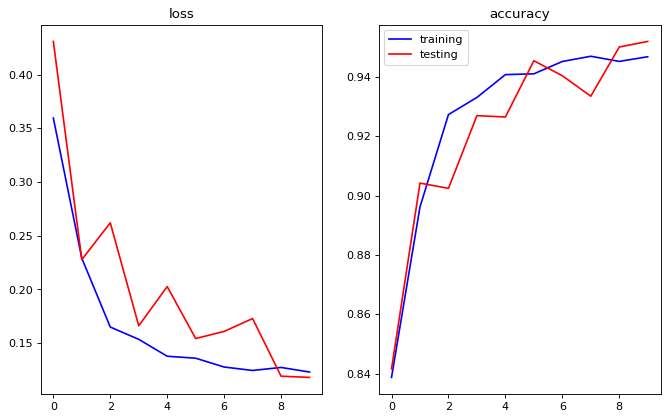

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


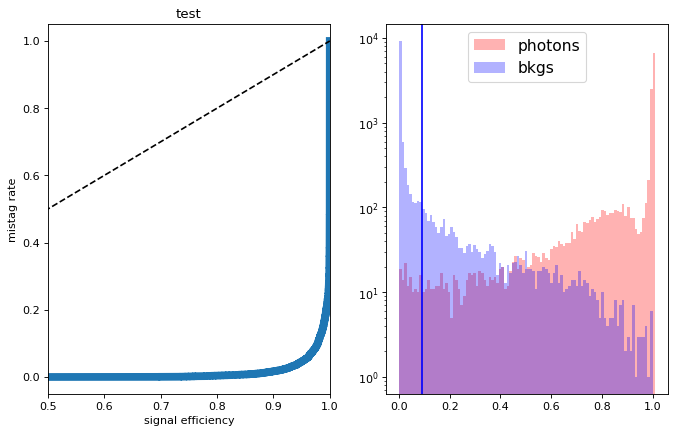

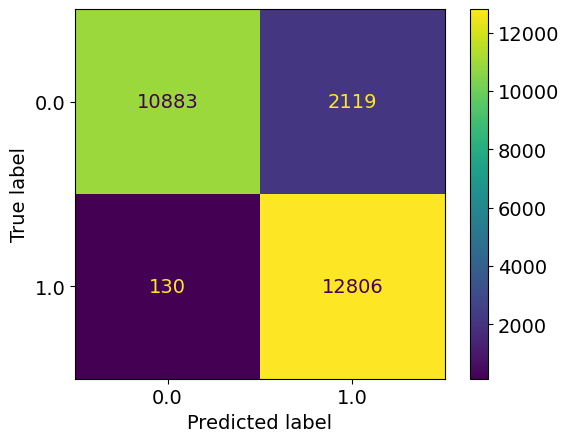

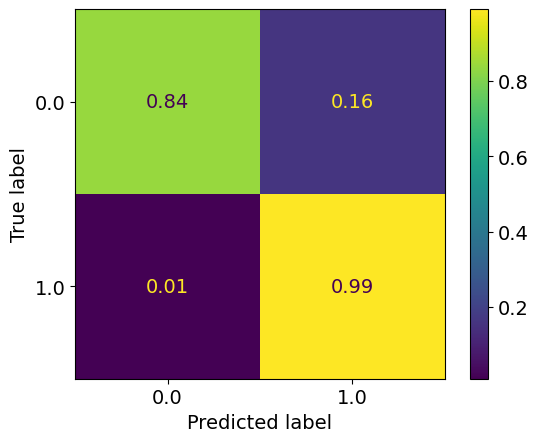

epoch: 10
Learning rate: 0.0009046152093405279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.12088423584065686
train acc: 0.9483571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.12085163186896931
test acc: 0.9520009
new best acc: 0.9520009
epoch: 11
Learning rate: 0.000885372348954578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.11889163223821993
train acc: 0.94879085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.80it/s]


test loss: 0.1268844653598287
test acc: 0.94914794
epoch: 12
Learning rate: 0.0008646085999671836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.11625613009481761
train acc: 0.9511041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.1581452079117298
test acc: 0.9253605
epoch: 13
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.11539482527730092
train acc: 0.9508342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.13252224553037772
test acc: 0.946295
epoch: 14
Learning rate: 0.0008188518951657368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.11620718335485183
train acc: 0.9503619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.11023878983475945
test acc: 0.9541985
new best acc: 0.9541985
epoch: 15
Learning rate: 0.0007940395201612855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.11498969956974074
train acc: 0.95032334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.1115550674836744
test acc: 0.9547382
new best acc: 0.9547382
epoch: 16
Learning rate: 0.0007680667055046367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.11378206583978123
train acc: 0.95127755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.59it/s]


test loss: 0.12259548038921574
test acc: 0.9505359
epoch: 17
Learning rate: 0.0007410359540293891


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.11062946799345788
train acc: 0.95274264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.11371724934063175
test acc: 0.9522708
epoch: 18
Learning rate: 0.0007130539437624405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.11351873962520864
train acc: 0.9519523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.80it/s]


test loss: 0.11003616723147305
test acc: 0.9540443
epoch: 19
Learning rate: 0.0006842311069145497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.11057773676049502
train acc: 0.95261735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.10865817913277583
test acc: 0.9537358


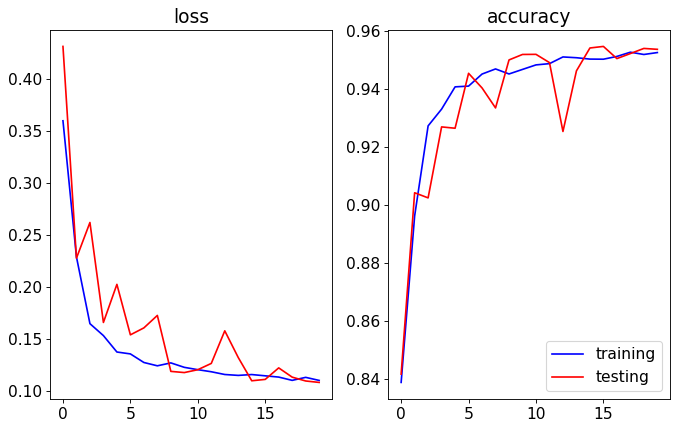

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


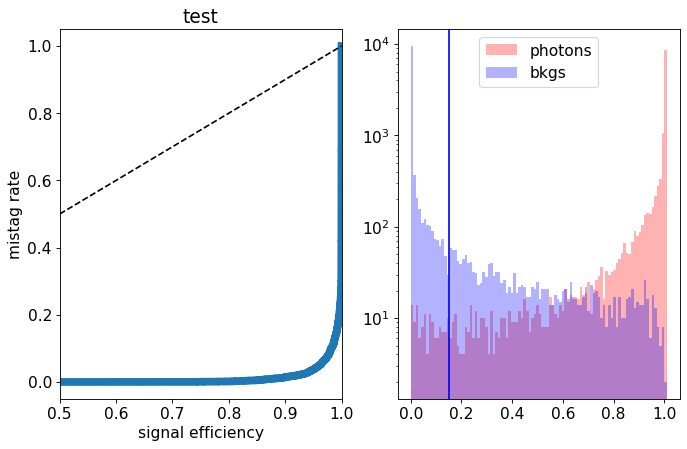

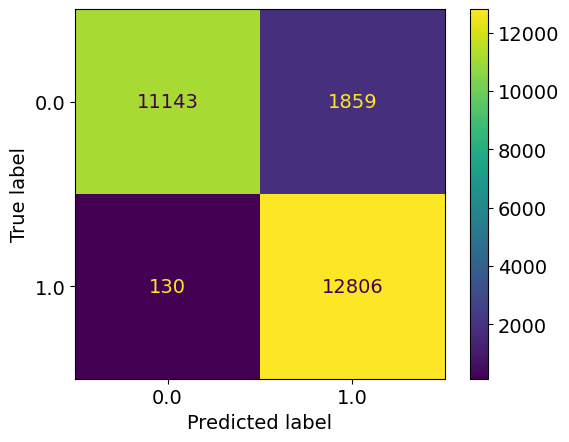

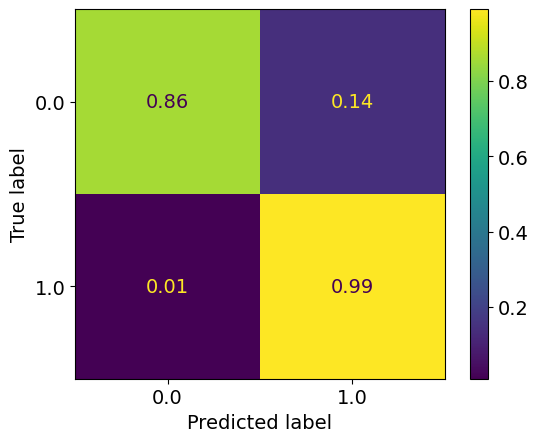

epoch: 20
Learning rate: 0.0006546811940548538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.10973186704809267
train acc: 0.95324385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.13989510810510677
test acc: 0.94062763
epoch: 21
Learning rate: 0.0006245208251893391


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10944680512123714
train acc: 0.9524342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.13129221986640582
test acc: 0.94301796
epoch: 22
Learning rate: 0.0005938690295149558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.10739783903939186
train acc: 0.9542655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.11402364024384455
test acc: 0.9548539
new best acc: 0.9548539
epoch: 23
Learning rate: 0.0005628467756657573


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10904058628860926
train acc: 0.95308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.10771186124872077
test acc: 0.95574063
new best acc: 0.95574063
epoch: 24
Learning rate: 0.0005315764943049666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.10776350655824463
train acc: 0.95402455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.1039127880199389
test acc: 0.95570207
epoch: 25
Learning rate: 0.0005001815949470823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.10659588925066711
train acc: 0.95452577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.77it/s]


test loss: 0.10748160901394757
test acc: 0.9555093
epoch: 26
Learning rate: 0.0004687859789169048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.20it/s]


train loss: 0.1067651208339399
train acc: 0.9543908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.76it/s]


test loss: 0.1207619250159372
test acc: 0.95034313
epoch: 27
Learning rate: 0.0004375135503676123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.10649500369508831
train acc: 0.9539185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.10730445926839655
test acc: 0.95705146
new best acc: 0.95705146
epoch: 28
Learning rate: 0.0004064877272876757


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.10579620848673617
train acc: 0.9546992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.10371675951914354
test acc: 0.95628035
epoch: 29
Learning rate: 0.00037583095442644083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.10460259649105844
train acc: 0.95508474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.72it/s]


test loss: 0.11325952258299697
test acc: 0.9525407


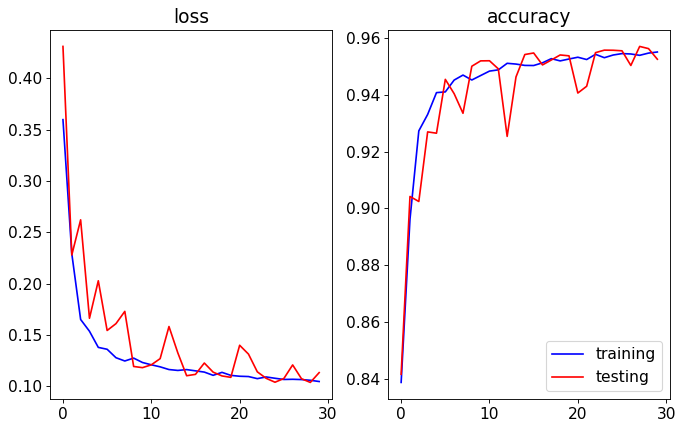

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


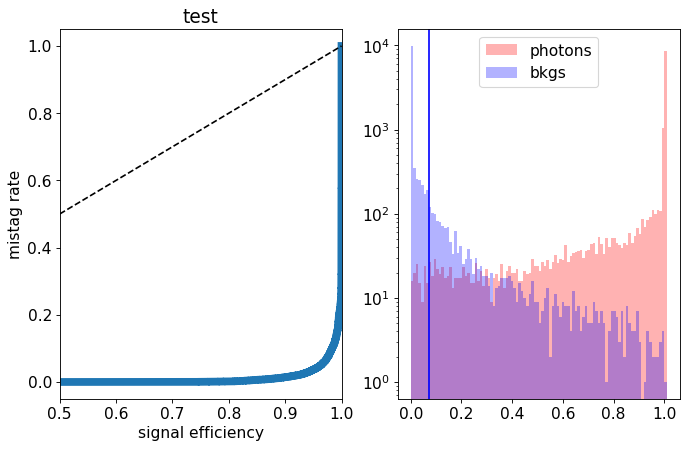

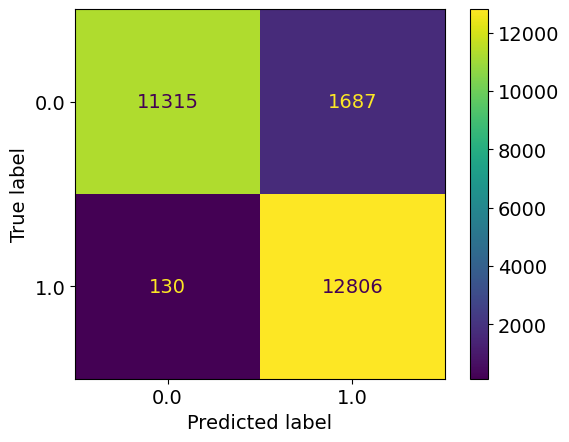

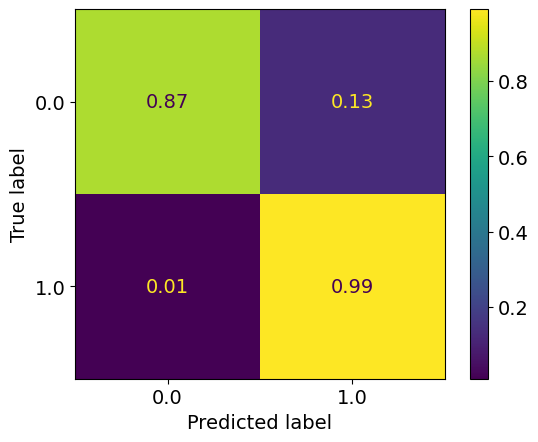

epoch: 30
Learning rate: 0.000345664220060644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.39it/s]


train loss: 0.10515746513026299
train acc: 0.9546703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.80it/s]


test loss: 0.11014887690544128
test acc: 0.9540828
epoch: 31
Learning rate: 0.00031610657850895675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.23it/s]


train loss: 0.1042283304423266
train acc: 0.95538354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.82it/s]


test loss: 0.1244651075791229
test acc: 0.94409746
epoch: 32
Learning rate: 0.00028727468027898187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.10465248161657698
train acc: 0.9550173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.78it/s]


test loss: 0.10404478877105496
test acc: 0.95597196
epoch: 33
Learning rate: 0.00025928231170099157


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.10341938671176833
train acc: 0.95538354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.11059999279677868
test acc: 0.95273346
epoch: 34
Learning rate: 0.0002322399458652666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10359477040740107
train acc: 0.9550655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.10695154964923859
test acc: 0.95585626
epoch: 35
Learning rate: 0.00020625430663527867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.10270031166903545
train acc: 0.9561161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.10414932752874764
test acc: 0.95662737
epoch: 36
Learning rate: 0.0001814279474573593


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10247408654648445
train acc: 0.9564438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.10667056607251818
test acc: 0.95597196
epoch: 37
Learning rate: 0.00015785884662909916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.10107962864671828
train acc: 0.9565305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.10299882089549844
test acc: 0.9573984
new best acc: 0.9573984
epoch: 38
Learning rate: 0.0001356400206237693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.10139377751102337
train acc: 0.95638597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.82it/s]


test loss: 0.10159072669392283
test acc: 0.95789963
new best acc: 0.95789963
epoch: 39
Learning rate: 0.00011485915699679673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.10071416957185447
train acc: 0.95681006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.10370701128108935
test acc: 0.95751405


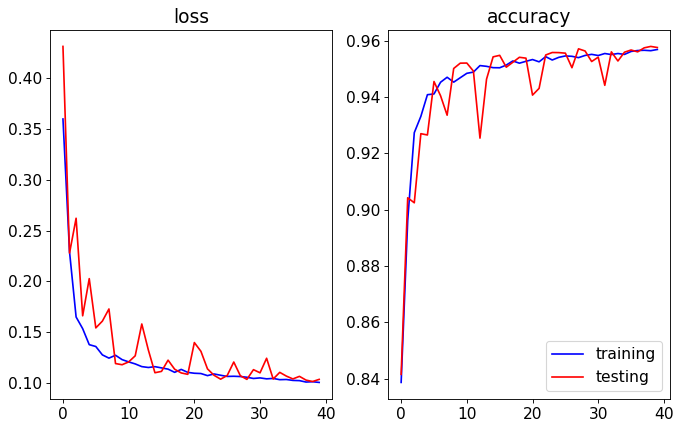

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.82it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


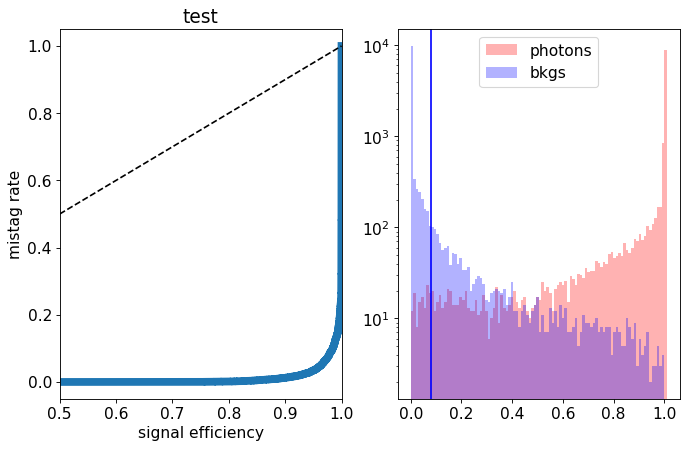

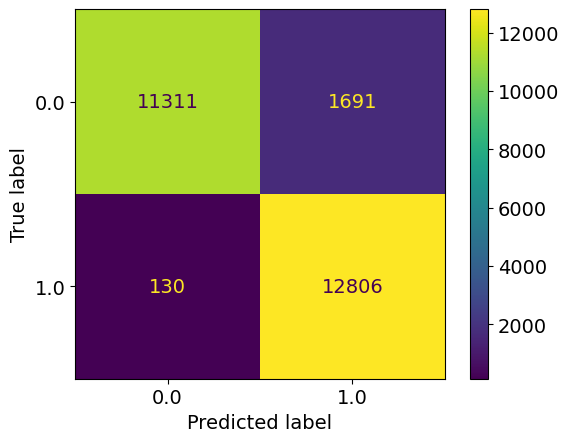

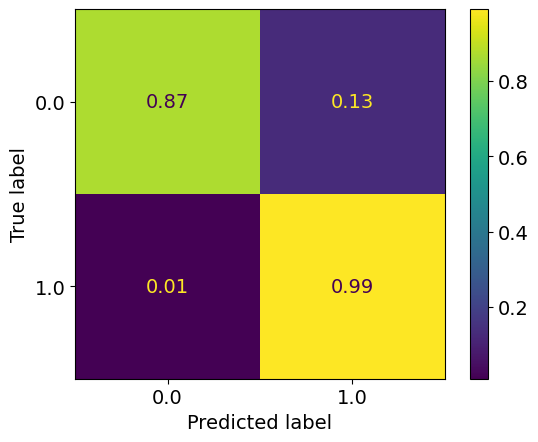

epoch: 40
Learning rate: 9.559826832304369e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.10011276309889865
train acc: 0.95696425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.10405116960067641
test acc: 0.95628035
epoch: 41
Learning rate: 7.793336853064242e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.10077068959012886
train acc: 0.9568775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.10499503344974735
test acc: 0.95720565
epoch: 42
Learning rate: 6.193417290874859e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.10042636753248342
train acc: 0.95660764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.10663272609764879
test acc: 0.9561647
epoch: 43
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.09965104803529089
train acc: 0.95746547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.10619150322269309
test acc: 0.9565117
epoch: 44
Learning rate: 3.5178637275523064e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.09958440616640742
train acc: 0.95710886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.10321001310578802
test acc: 0.957437
epoch: 45
Learning rate: 2.4527889139894345e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.09974888397779079
train acc: 0.9570414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.10668483376502991
test acc: 0.95662737
epoch: 46
Learning rate: 1.5753612203285418e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.09964405452412677
train acc: 0.9572149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.10410887680270454
test acc: 0.9571671
epoch: 47
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.38it/s]


train loss: 0.09969947338534918
train acc: 0.95734984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.10473393022336742
test acc: 0.95735985
epoch: 48
Learning rate: 3.965441941372383e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.09892819115536751
train acc: 0.95710886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.1041395024142482
test acc: 0.9573984
epoch: 49
Learning rate: 9.980711385892405e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.0986105750794011
train acc: 0.9572149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.10406612994318659
test acc: 0.957437


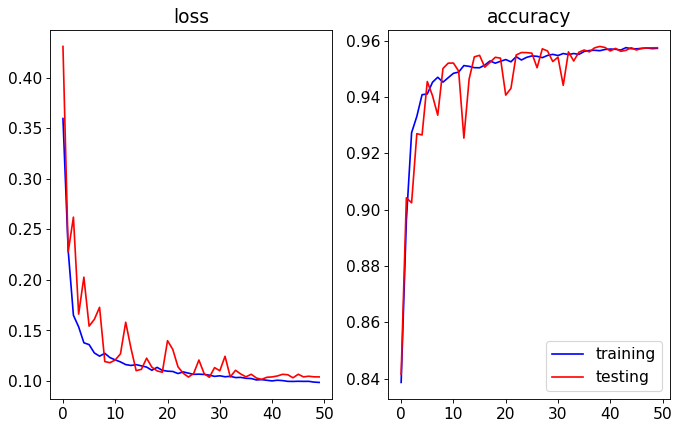

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


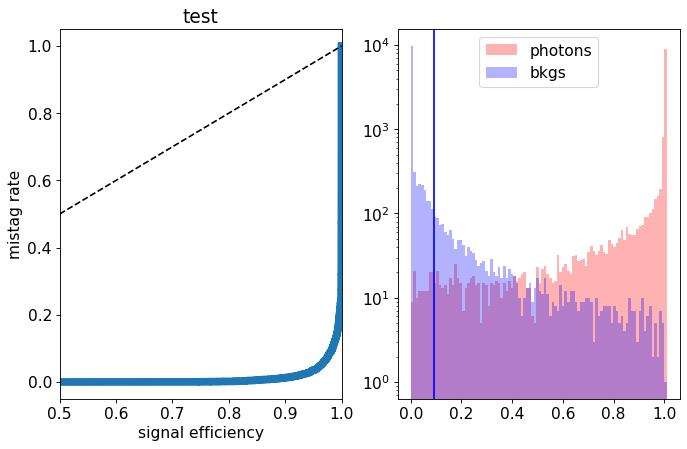

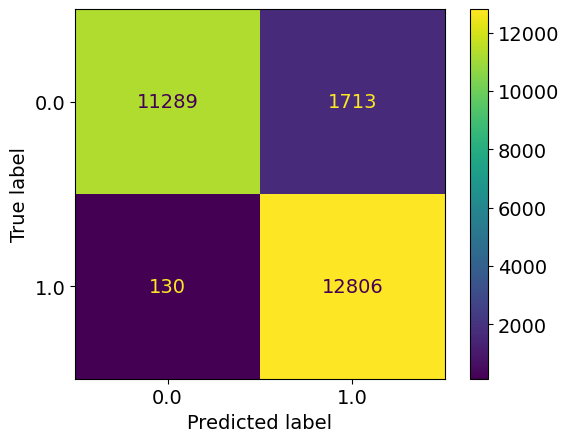

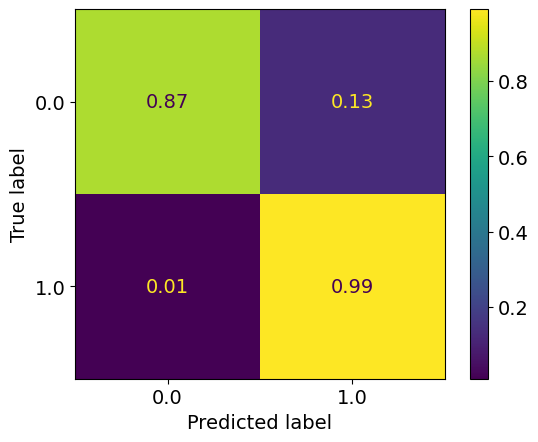

epoch: 50
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.11350053268877756
train acc: 0.95067036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.11958752098408612
test acc: 0.9515768
epoch: 51
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.11161953986035605
train acc: 0.951827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.12212413566356356
test acc: 0.9494564
epoch: 52
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.11129785970800873
train acc: 0.9520294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.11181824637407606
test acc: 0.9557792
epoch: 53
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.1071990330870441
train acc: 0.9541595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.11527907577427951
test acc: 0.9521551
epoch: 54
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10881828581322135
train acc: 0.9533306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.11470358547839252
test acc: 0.9490709
epoch: 55
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.10690868223850437
train acc: 0.9541016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.10354695807803761
test acc: 0.95655024
epoch: 56
Learning rate: 0.0009649550618418059


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.10687827030358286
train acc: 0.9535137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.10278264653276313
test acc: 0.95670444
epoch: 57
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.10557965171991746
train acc: 0.95498836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.10644076188856905
test acc: 0.955278
epoch: 58
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10514393517736755
train acc: 0.9552679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.11027203483337705
test acc: 0.9551623
epoch: 59
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.10457738342484987
train acc: 0.95520043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.10052818449383433
test acc: 0.95813096
new best acc: 0.95813096


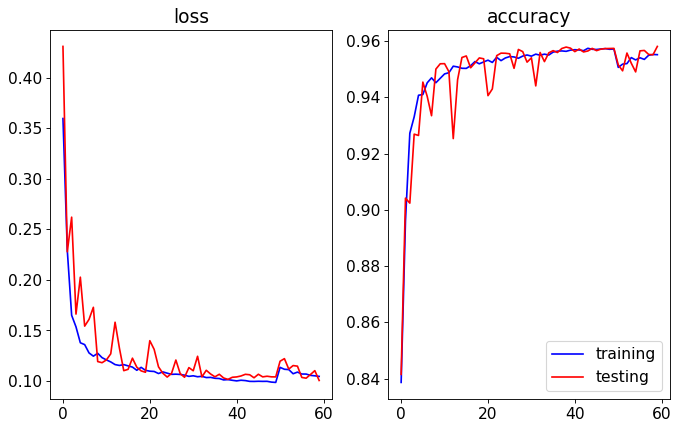

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.72it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


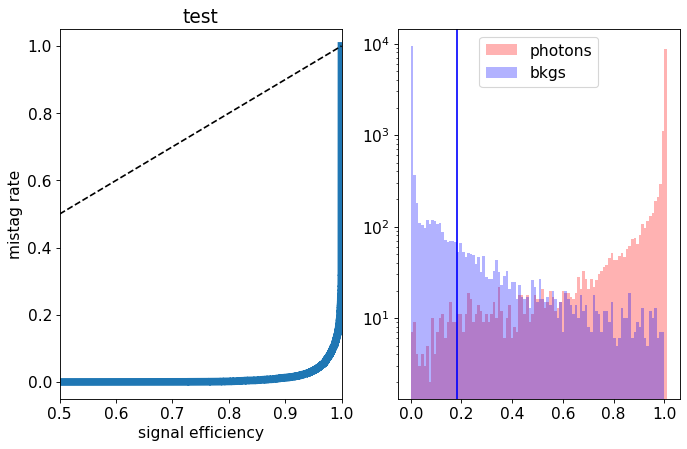

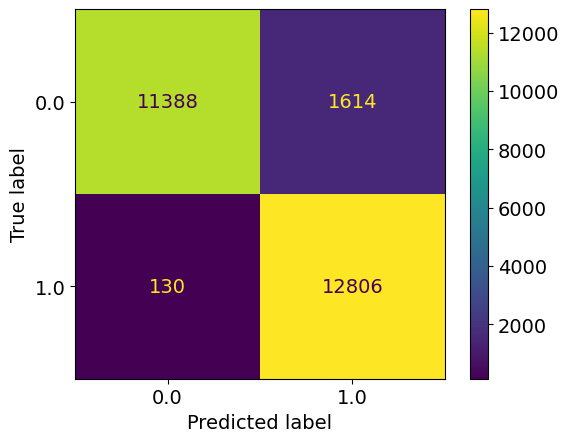

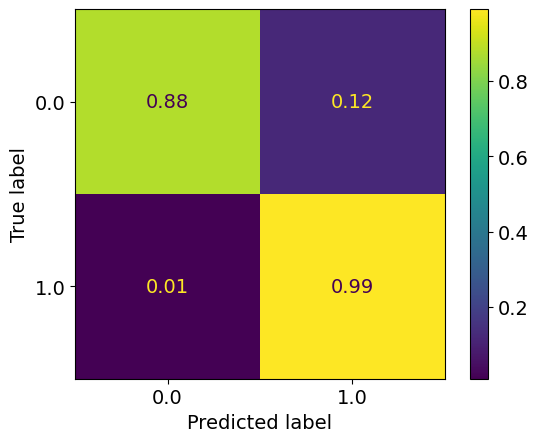

epoch: 60
Learning rate: 0.0009046152093405278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.10377053442717976
train acc: 0.9556342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.76it/s]


test loss: 0.10670360922813416
test acc: 0.95601046
epoch: 61
Learning rate: 0.000885372348954578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.39it/s]


train loss: 0.10322493379343452
train acc: 0.95601004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.84it/s]


test loss: 0.10765681551261382
test acc: 0.9554322
epoch: 62
Learning rate: 0.0008646085999671836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.10352907545132443
train acc: 0.9556631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.10149860026484187
test acc: 0.95855504
new best acc: 0.95855504
epoch: 63
Learning rate: 0.0008424059074095433


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10531906658686654
train acc: 0.9548535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.10372172575443983
test acc: 0.9562033
epoch: 64
Learning rate: 0.0008188518951657367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.10213542169745947
train acc: 0.9567329


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.10801579904827205
test acc: 0.95439124
epoch: 65
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10196753539618729
train acc: 0.9562703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.10234036669135094
test acc: 0.9577454
epoch: 66
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.10208754418040976
train acc: 0.9561161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.71it/s]


test loss: 0.09875748086382043
test acc: 0.9588249
new best acc: 0.9588249
epoch: 67
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.10327894852168298
train acc: 0.9557787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09967049956321716
test acc: 0.9580538
epoch: 68
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.10087820685150996
train acc: 0.9569739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.09949072839861567
test acc: 0.9588249
epoch: 69
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.10024153910620365
train acc: 0.95672333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.10664504918862473
test acc: 0.9573984


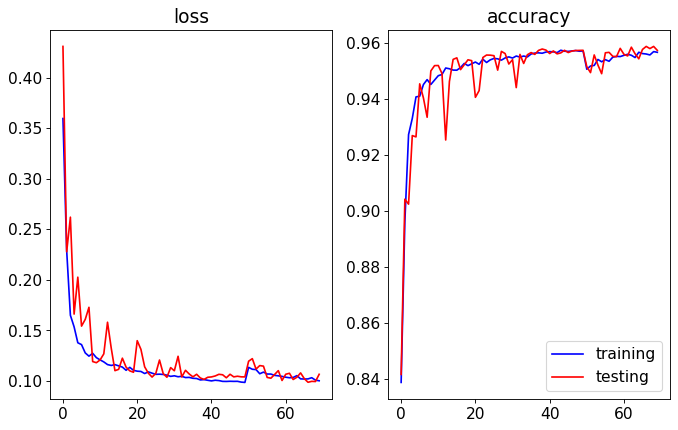

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


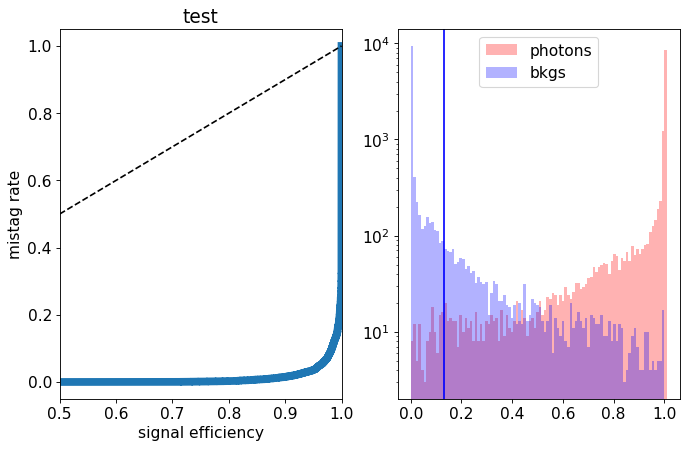

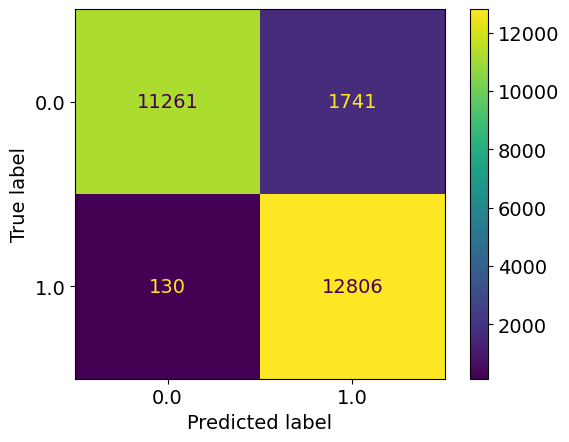

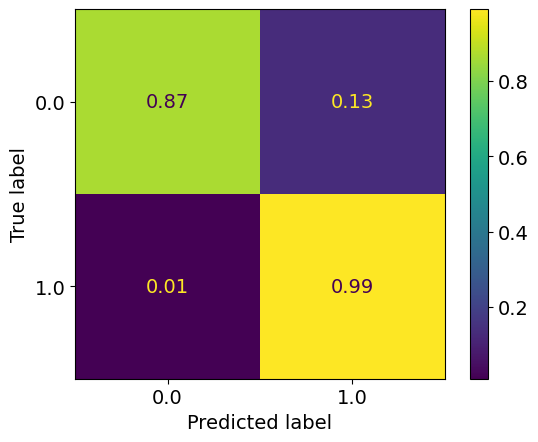

epoch: 70
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.0994676879547924
train acc: 0.95726305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.10343369282782078
test acc: 0.95662737
epoch: 71
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09963354942081981
train acc: 0.95740765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.81it/s]


test loss: 0.10494001903994517
test acc: 0.9570129
epoch: 72
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09896753702549577
train acc: 0.95788956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.10064980980347503
test acc: 0.9584008
epoch: 73
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.09831940240598139
train acc: 0.9578992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.10937570915980772
test acc: 0.95554787
epoch: 74
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09884099567556656
train acc: 0.95780283


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.10498138297010552
test acc: 0.9571285
epoch: 75
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.09865471113451643
train acc: 0.95737875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.10076784969053486
test acc: 0.9589791
new best acc: 0.9589791
epoch: 76
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.09825340309584071
train acc: 0.9579956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.09688344987278635
test acc: 0.959596
new best acc: 0.959596
epoch: 77
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.0978262467535934
train acc: 0.95848715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.10177079164846377
test acc: 0.95886344
epoch: 78
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09644239572431311
train acc: 0.9591233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.10398742048577829
test acc: 0.95670444
epoch: 79
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.09733136590419478
train acc: 0.958092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.10281990112906153
test acc: 0.95685863


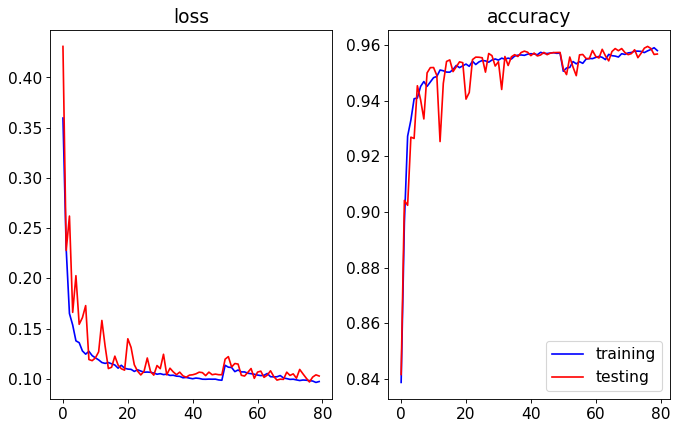

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


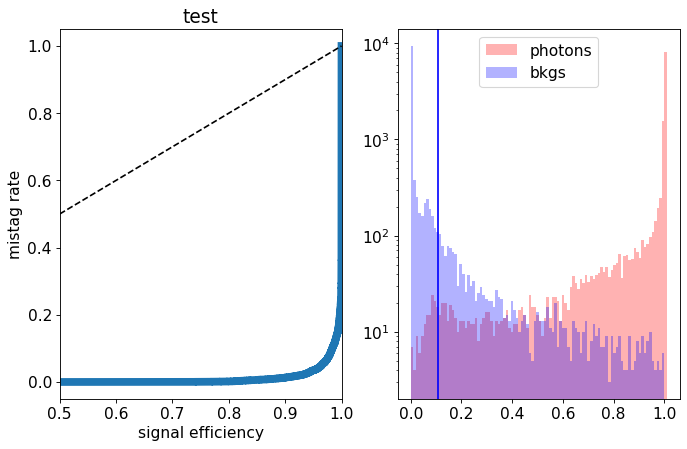

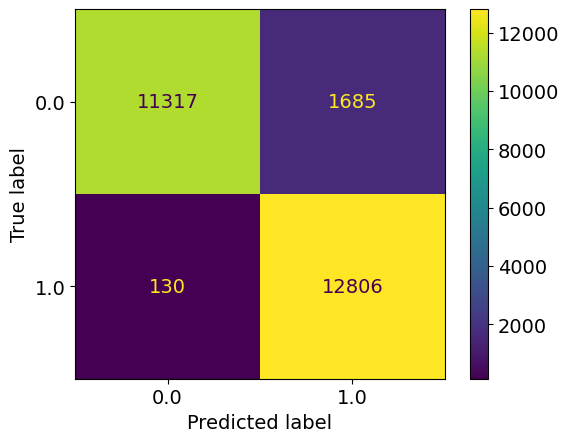

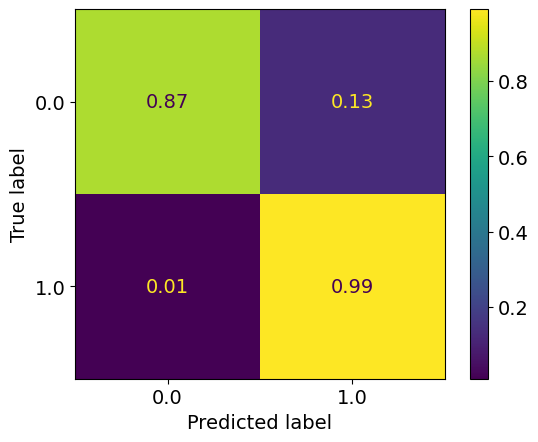

epoch: 80
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09706354227369231
train acc: 0.9587185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.77it/s]


test loss: 0.10071038268506527
test acc: 0.9594803
epoch: 81
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09650691969029476
train acc: 0.958863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.10697338552298871
test acc: 0.9565888
epoch: 82
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09495166475976134
train acc: 0.95981723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.73it/s]


test loss: 0.10679323293946007
test acc: 0.95747554
epoch: 83
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09528679596637026
train acc: 0.9592004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.10085405764931982
test acc: 0.95870924
epoch: 84
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.09470608699097799
train acc: 0.95962447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.61it/s]


test loss: 0.10330745848742398
test acc: 0.9580538
epoch: 85
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.0944200597617323
train acc: 0.96004856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.57it/s]


test loss: 0.10207006978717717
test acc: 0.9588249
epoch: 86
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.22it/s]


train loss: 0.0944366806073685
train acc: 0.95911366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.54it/s]


test loss: 0.0984150781719522
test acc: 0.96002007
new best acc: 0.96002007
epoch: 87
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.09488333804758987
train acc: 0.9598462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.09723006290468303
test acc: 0.9604056
new best acc: 0.9604056
epoch: 88
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.09395394418280938
train acc: 0.9598751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.09625871792774308
test acc: 0.9598273
epoch: 89
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.09341019241279261
train acc: 0.9602124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.09967935711822727
test acc: 0.9594032


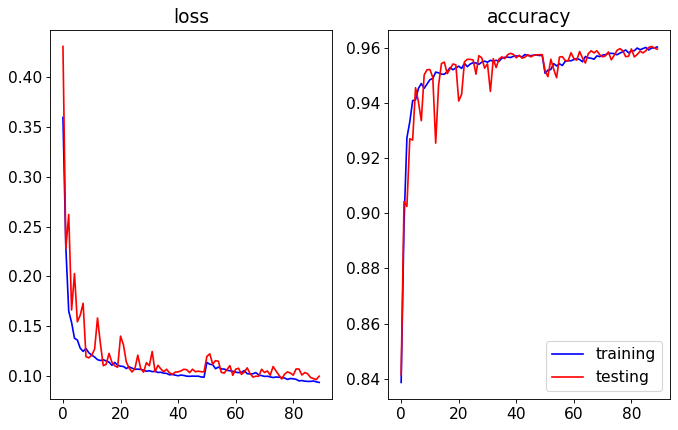

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


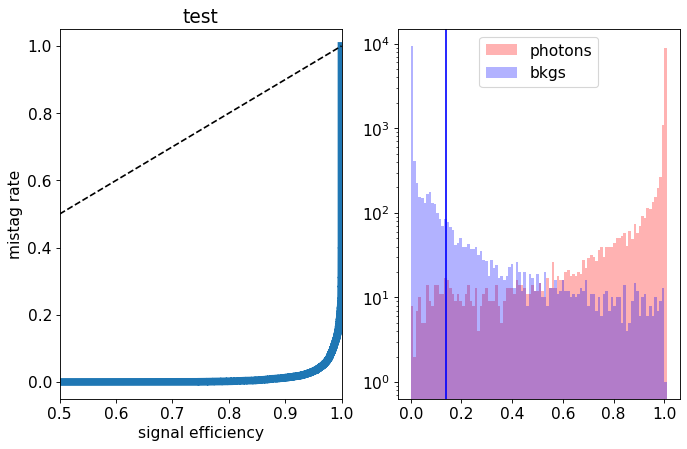

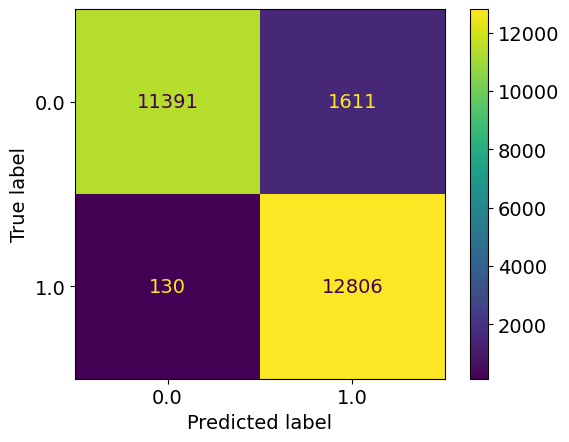

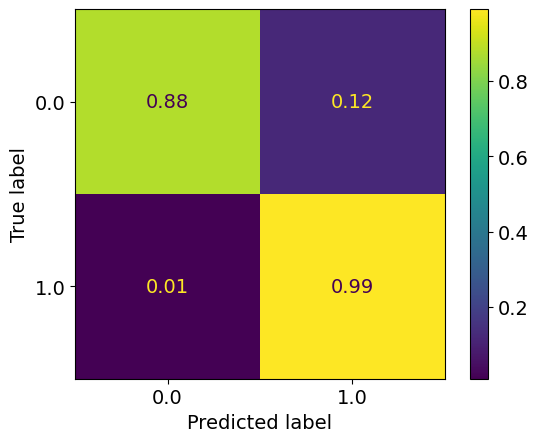

epoch: 90
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.09300018360332257
train acc: 0.96040523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.09498050046915357
test acc: 0.9605598
new best acc: 0.9605598
epoch: 91
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09280941417882208
train acc: 0.9602992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.05it/s]


test loss: 0.09766452056779103
test acc: 0.95951885
epoch: 92
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.0936200750098063
train acc: 0.95981723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.09666073144498197
test acc: 0.95936465
epoch: 93
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09282356291750953
train acc: 0.96031845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.80it/s]


test loss: 0.10006442174992779
test acc: 0.9587863
epoch: 94
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09267396792080361
train acc: 0.96064615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.09711779450828378
test acc: 0.95978874
epoch: 95
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09257388750166562
train acc: 0.9605691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.79it/s]


test loss: 0.09684652936729518
test acc: 0.95978874
epoch: 96
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09246068818203976
train acc: 0.96061724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.09635238586501642
test acc: 0.9599044
epoch: 97
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.09216553192434973
train acc: 0.96067506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.09793089905923064
test acc: 0.9599044
epoch: 98
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09289627690191214
train acc: 0.96080035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.09600510880012404
test acc: 0.9598658
epoch: 99
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.09224188144754812
train acc: 0.960116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.09794756431471217
test acc: 0.9599044


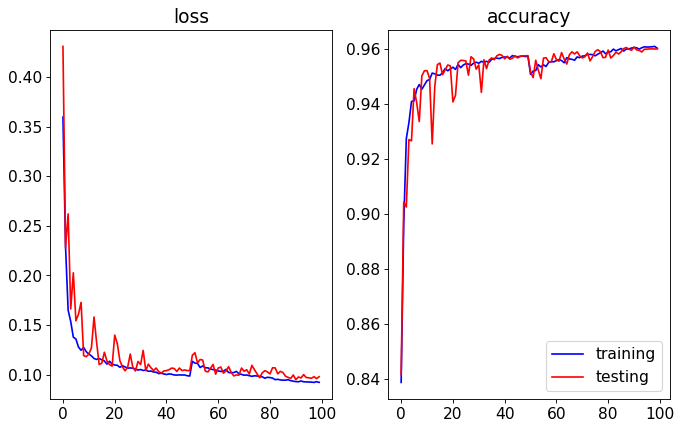

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


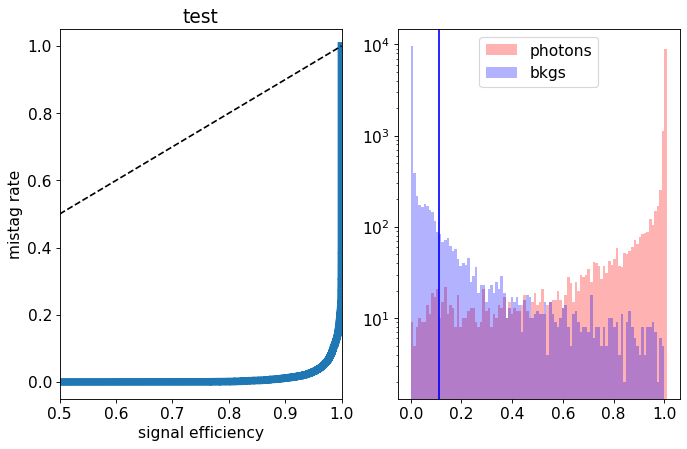

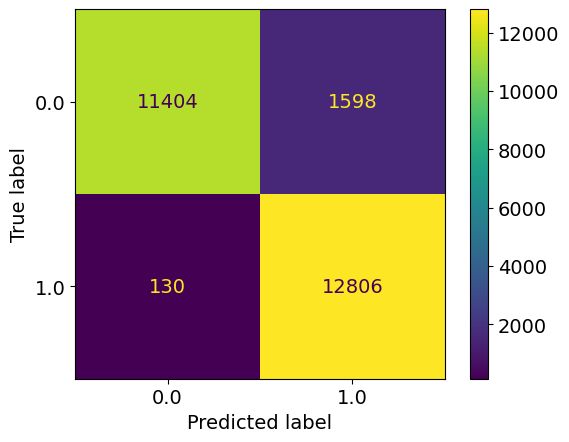

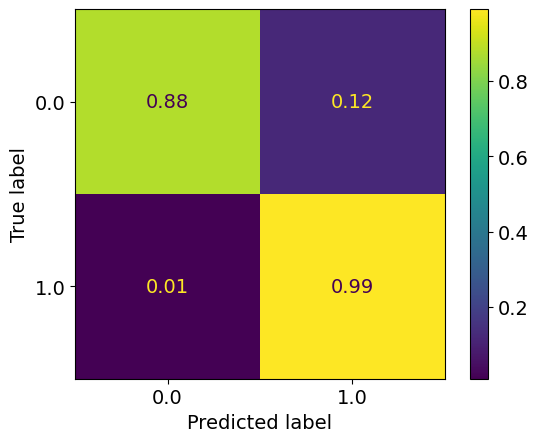

epoch: 100
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.10074089271570906
train acc: 0.95693535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.05it/s]


test loss: 0.10853189687159928
test acc: 0.9541599
epoch: 101
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.10022208391758748
train acc: 0.95741725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.10591765086759221
test acc: 0.9570129
epoch: 102
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.0992543066857178
train acc: 0.9582751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.10079792522909967
test acc: 0.95859355
epoch: 103
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.09883434364216866
train acc: 0.9580823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.11426273056051948
test acc: 0.95705146
epoch: 104
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09922499390523558
train acc: 0.95768714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.11197088574143974
test acc: 0.956049
epoch: 105
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.10039732361890677
train acc: 0.95765823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.10888644629581408
test acc: 0.9529648
epoch: 106
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09871022855443072
train acc: 0.95783174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.71it/s]


test loss: 0.10672950710762631
test acc: 0.95720565
epoch: 107
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09826696562887616
train acc: 0.9578124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.10133553380993279
test acc: 0.95705146
epoch: 108
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.09814814835614552
train acc: 0.9584004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.70it/s]


test loss: 0.10104602202773094
test acc: 0.95859355
epoch: 109
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.09705040526355622
train acc: 0.9590751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.45it/s]


test loss: 0.09897057593546131
test acc: 0.959596


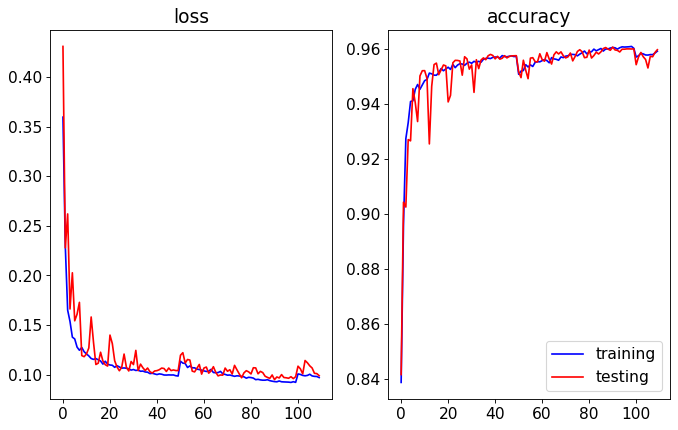

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


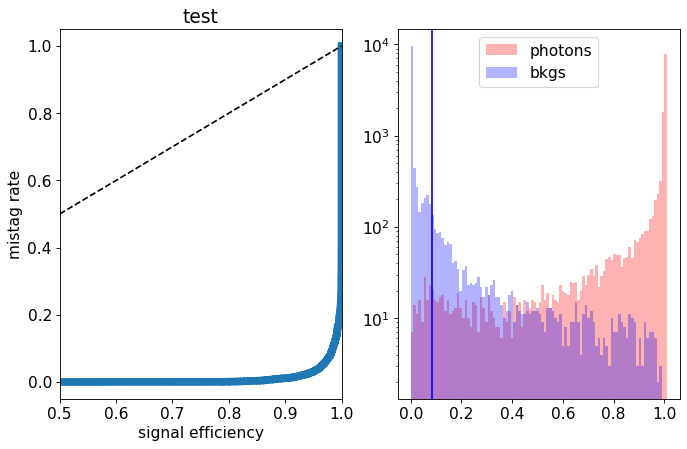

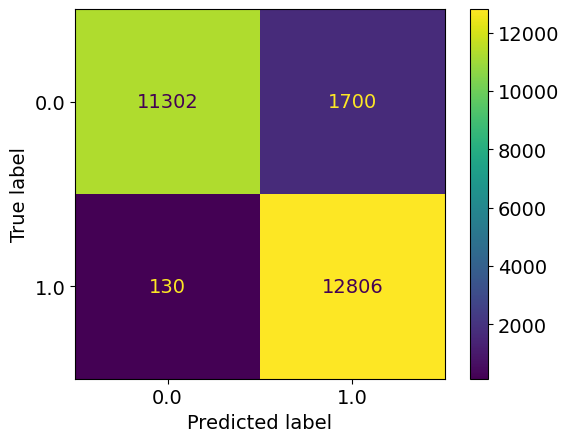

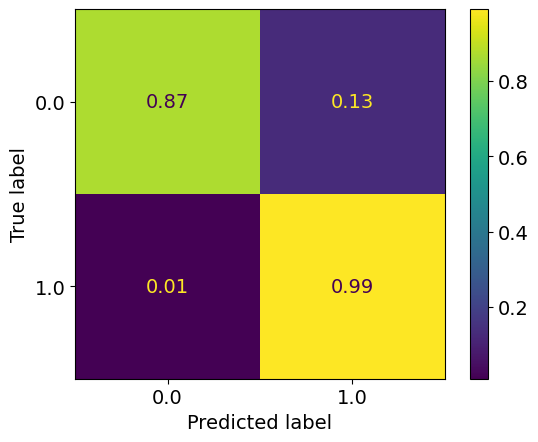

epoch: 110
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.09569359652568839
train acc: 0.95921004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.10948683338409121
test acc: 0.95207804
epoch: 111
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09700524350466756
train acc: 0.95911366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.09518898058344018
test acc: 0.960367
epoch: 112
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.30it/s]


train loss: 0.09607181499975954
train acc: 0.9592293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.1008168255740946
test acc: 0.9594032
epoch: 113
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.0966801016747607
train acc: 0.9586896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.10034543208100578
test acc: 0.9583622
epoch: 114
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.09629609134328158
train acc: 0.9590751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.10012861900031567
test acc: 0.95978874
epoch: 115
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09541227115113611
train acc: 0.9593257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.12411975911395116
test acc: 0.955278
epoch: 116
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.09641473034041466
train acc: 0.9585546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.0916009388694709
test acc: 0.96059835
new best acc: 0.96059835
epoch: 117
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09563849702735856
train acc: 0.9590269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.78it/s]


test loss: 0.1056692861020565
test acc: 0.9571671
epoch: 118
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09509253984241817
train acc: 0.9590173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.09682303065942093
test acc: 0.9598273
epoch: 119
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09431546297721091
train acc: 0.9596438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.81it/s]


test loss: 0.09275564627552574
test acc: 0.9607911
new best acc: 0.9607911


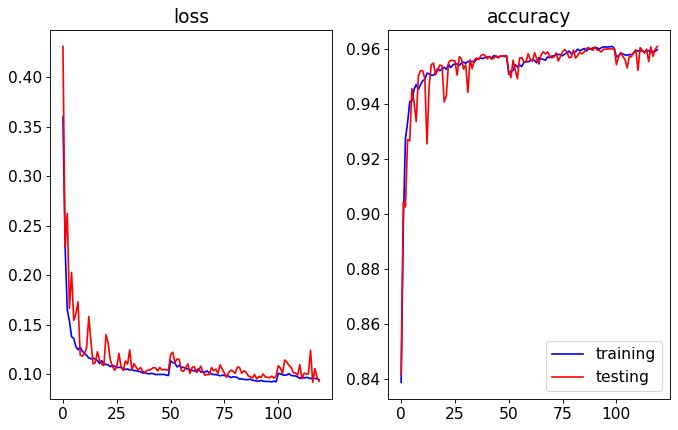

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


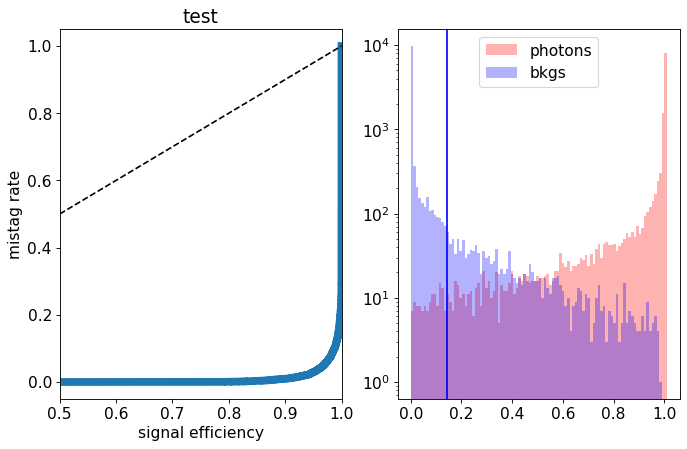

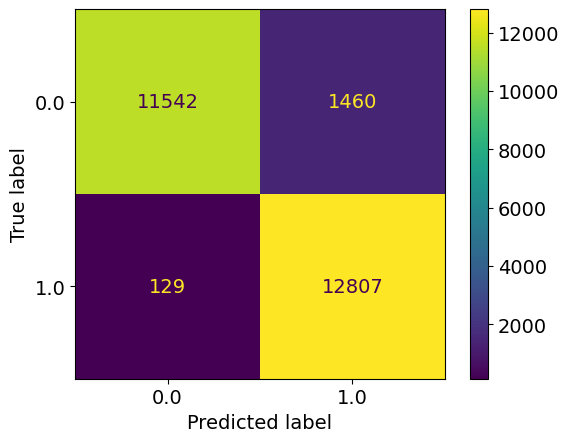

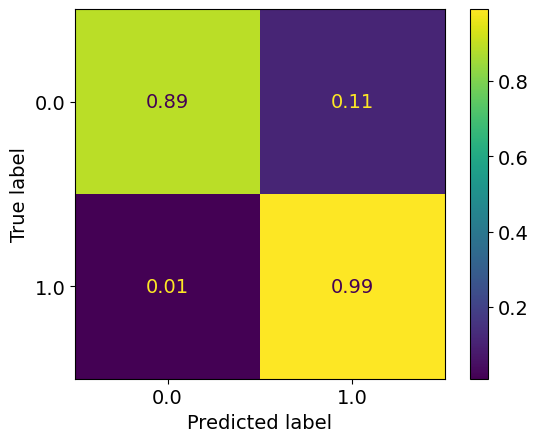

epoch: 120
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09425829727784057
train acc: 0.95896906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.09432702460749583
test acc: 0.9602899
epoch: 121
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.09341900106627128
train acc: 0.9599136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.0969586196270856
test acc: 0.96032846
epoch: 122
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.0930759082252235
train acc: 0.960251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09648698974739421
test acc: 0.9591719
epoch: 123
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.09295144748222621
train acc: 0.9604823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.09774248945442113
test acc: 0.9591719
epoch: 124
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09270596183362724
train acc: 0.96001005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.09754507700827988
test acc: 0.9605598
epoch: 125
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.20it/s]


train loss: 0.09200304828454993
train acc: 0.9606076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.53it/s]


test loss: 0.09775479933754964
test acc: 0.9594803
epoch: 126
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.09240694430177611
train acc: 0.96088713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.49it/s]


test loss: 0.10534601116722281
test acc: 0.95894057
epoch: 127
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.24it/s]


train loss: 0.09153974310338842
train acc: 0.9609642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.09634853425351056
test acc: 0.9597502
epoch: 128
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09128134081818465
train acc: 0.9611666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.09361374886198477
test acc: 0.9609839
new best acc: 0.9609839
epoch: 129
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.09170241085435614
train acc: 0.96076185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.77it/s]


test loss: 0.10217329470271413
test acc: 0.95828515


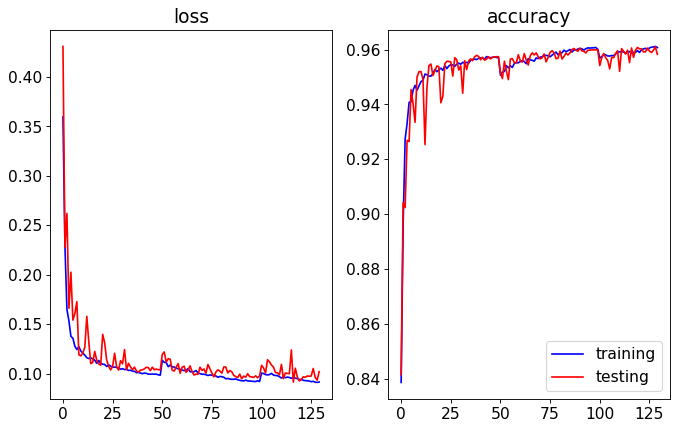

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


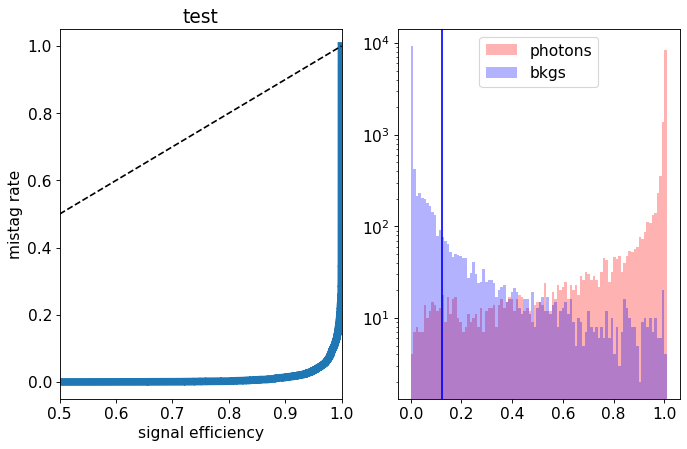

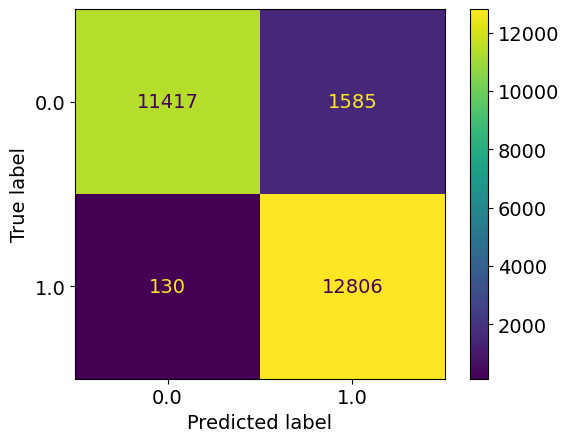

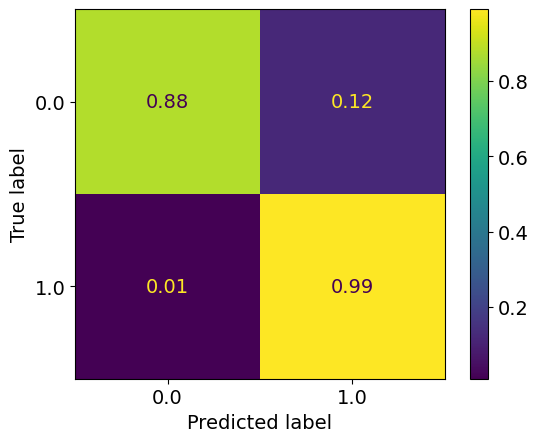

epoch: 130
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.22it/s]


train loss: 0.09065254075678787
train acc: 0.9604534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.75it/s]


test loss: 0.10136175731366331
test acc: 0.958902
epoch: 131
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09053416440338757
train acc: 0.9611088


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.0959620066833767
test acc: 0.96075255
epoch: 132
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.09074353306107438
train acc: 0.9613305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.09692944958806038
test acc: 0.9598658
epoch: 133
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09070701152086258
train acc: 0.9614365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09383833560753953
test acc: 0.9604056
epoch: 134
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.0894054626195417
train acc: 0.9619377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.09889490479095416
test acc: 0.9594032
epoch: 135
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09003457668199705
train acc: 0.96129197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.09180928800593723
test acc: 0.96183205
new best acc: 0.96183205
epoch: 136
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.08927950878880617
train acc: 0.9614943


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.09680016736753962
test acc: 0.959596
epoch: 137
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08923052561420926
train acc: 0.9616871


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.09293943626636808
test acc: 0.9608297
epoch: 138
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08916550975917392
train acc: 0.96166784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.09743964062495665
test acc: 0.9602899
epoch: 139
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08863151097142627
train acc: 0.96174496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.09319691105999729
test acc: 0.96102244


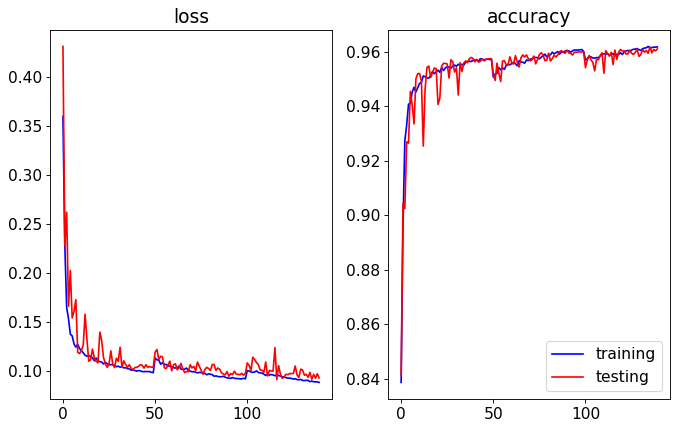

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.68it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


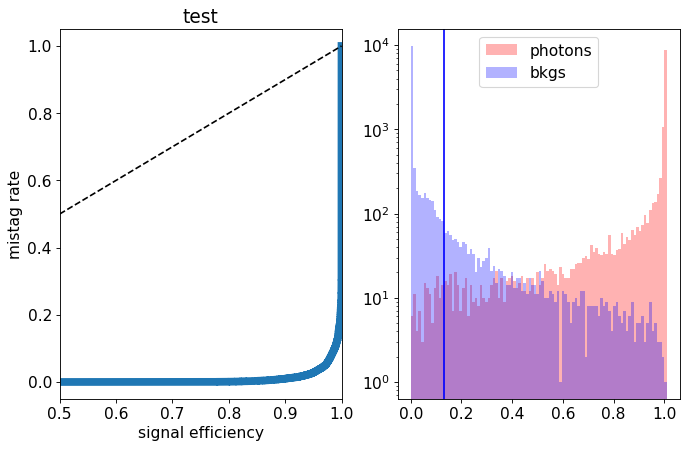

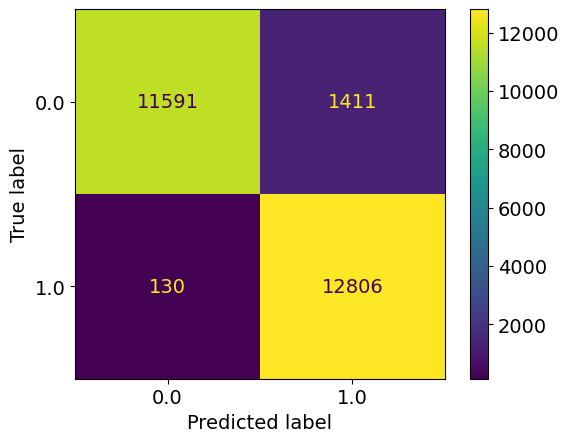

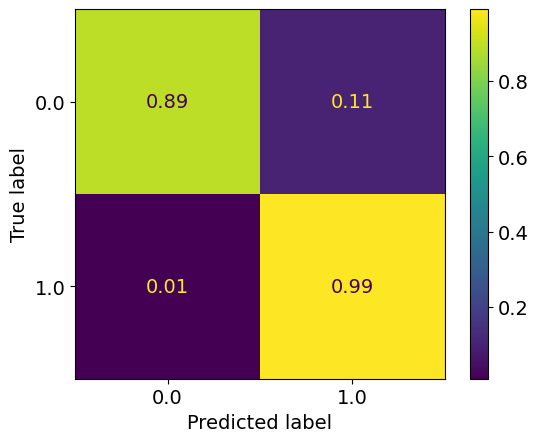

epoch: 140
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08890514523652247
train acc: 0.9618799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.09283330477774143
test acc: 0.9614851
epoch: 141
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.0887612193564459
train acc: 0.9622076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.09194918514483354
test acc: 0.96117663
epoch: 142
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08834731318271918
train acc: 0.9625738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.06it/s]


test loss: 0.09435496674003926
test acc: 0.96032846
epoch: 143
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.0884576337358166
train acc: 0.9620727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.09395160238173875
test acc: 0.9607911
epoch: 144
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08832687229951681
train acc: 0.9622172


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.09305767791176384
test acc: 0.9612152
epoch: 145
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.0881930886407119
train acc: 0.962063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.09295328621837226
test acc: 0.961061
epoch: 146
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.08779040413957111
train acc: 0.9622558


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.39it/s]


test loss: 0.09454052251848308
test acc: 0.960714
epoch: 147
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.24it/s]


train loss: 0.08775084693996893
train acc: 0.962063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.09373123173347929
test acc: 0.96075255
epoch: 148
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08778506640151057
train acc: 0.9625546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.09493613090704787
test acc: 0.960714
epoch: 149
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.30it/s]


train loss: 0.08790052352699242
train acc: 0.96243894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.07it/s]


test loss: 0.09436870095404712
test acc: 0.96075255


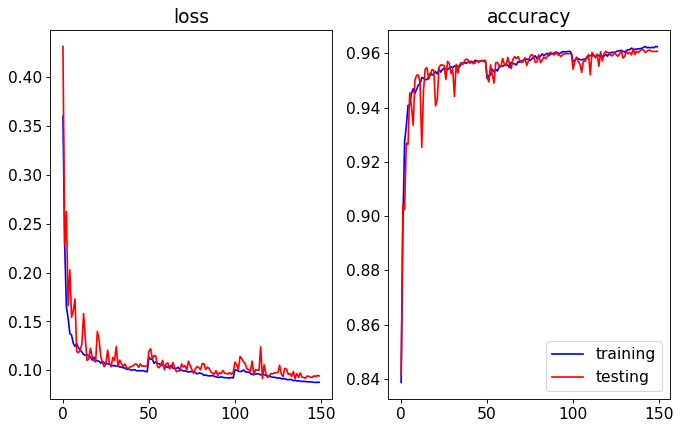

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


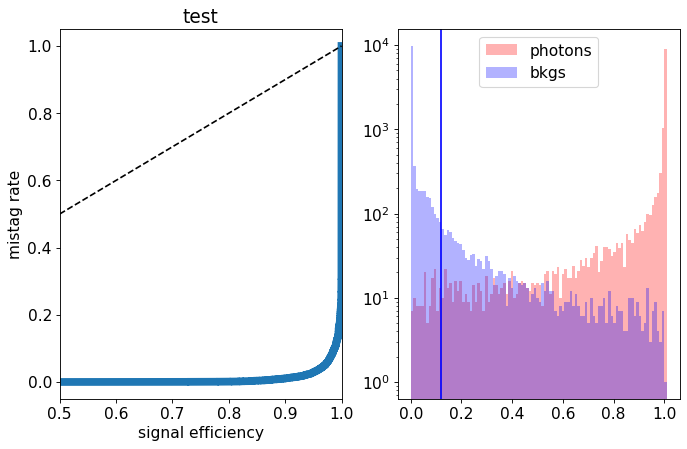

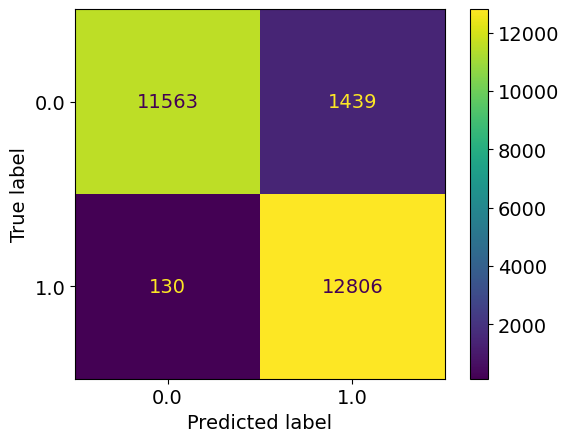

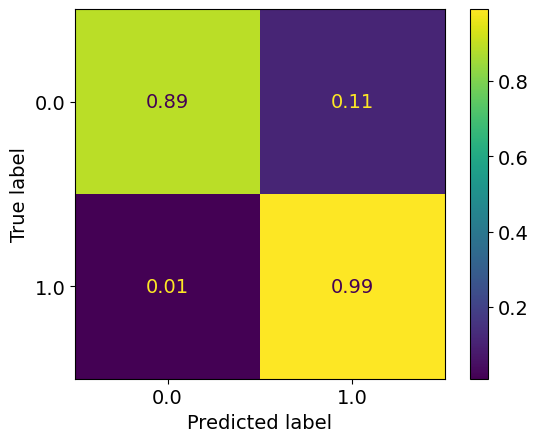

epoch: 150
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09523267591792035
train acc: 0.9591715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.73it/s]


test loss: 0.11410427686165679
test acc: 0.9531961
epoch: 151
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09525562069147309
train acc: 0.959345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.09567396088757298
test acc: 0.96002007
epoch: 152
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.0946891209422853
train acc: 0.95974016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.11775081553919749
test acc: 0.95230937
epoch: 153
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09594060256646547
train acc: 0.95834255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.0926367100328207
test acc: 0.9602514
epoch: 154
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.0932126659576948
train acc: 0.96013534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.09796094708144665
test acc: 0.95901763
epoch: 155
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.09467461336985489
train acc: 0.9591907


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.09393450668589635
test acc: 0.9590562
epoch: 156
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.23it/s]


train loss: 0.09290415418974926
train acc: 0.96037626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.55it/s]


test loss: 0.09975024024871262
test acc: 0.9594417
epoch: 157
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.34it/s]


train loss: 0.09348851235615725
train acc: 0.9600004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.48it/s]


test loss: 0.10241154208779335
test acc: 0.9585165
epoch: 158
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.09292371075794187
train acc: 0.9604534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.40it/s]


test loss: 0.1016096445647153
test acc: 0.9593261
epoch: 159
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.34it/s]


train loss: 0.09353256669175418
train acc: 0.9602028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.11225380934774876
test acc: 0.95682013


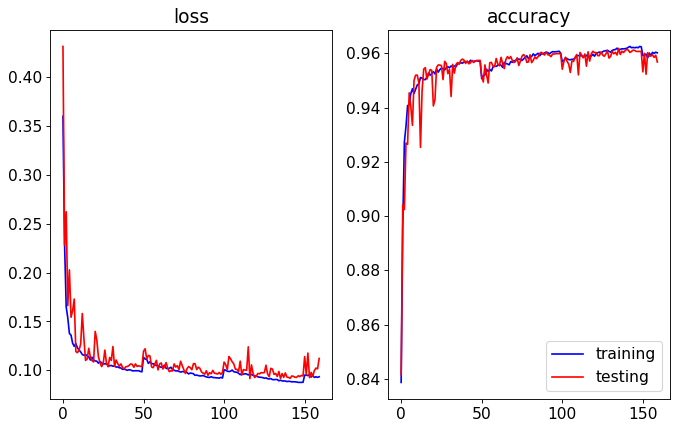

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


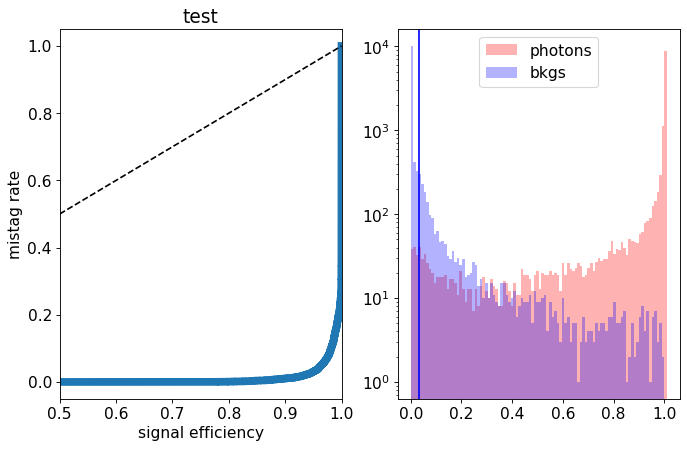

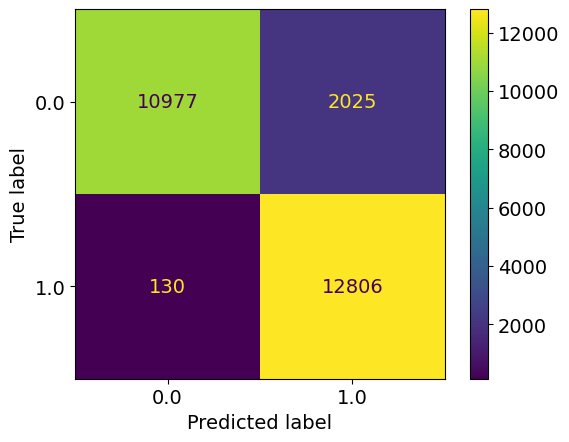

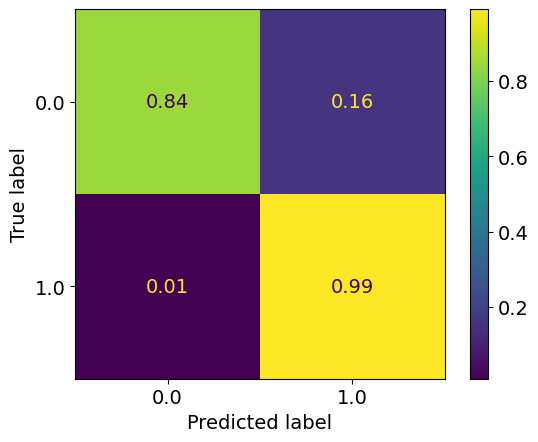

epoch: 160
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.20it/s]


train loss: 0.09371742840877847
train acc: 0.96001965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.54it/s]


test loss: 0.09346340029415759
test acc: 0.96113807
epoch: 161
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.38it/s]


train loss: 0.09207042377722056
train acc: 0.96061724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.47it/s]


test loss: 0.10393449206921188
test acc: 0.9585165
epoch: 162
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09271066032909933
train acc: 0.96106064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.10373119214041666
test acc: 0.9588249
epoch: 163
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.09243088118688908
train acc: 0.960251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.79it/s]


test loss: 0.1103682103143497
test acc: 0.95612615
epoch: 164
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09201815732986252
train acc: 0.9606944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.09327721409499645
test acc: 0.96059835
epoch: 165
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.09138977316590403
train acc: 0.9604148


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.09215771102092483
test acc: 0.960714
epoch: 166
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09051124885075354
train acc: 0.9616389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.08it/s]


test loss: 0.09000591628930786
test acc: 0.9614851
epoch: 167
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.09089958508407449
train acc: 0.96138835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.0922706758772785
test acc: 0.9609839
epoch: 168
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09086849040895528
train acc: 0.9609257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.0920757802880623
test acc: 0.96125376
epoch: 169
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.22it/s]


train loss: 0.09058181504379807
train acc: 0.9613209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.09802359986034306
test acc: 0.95843935


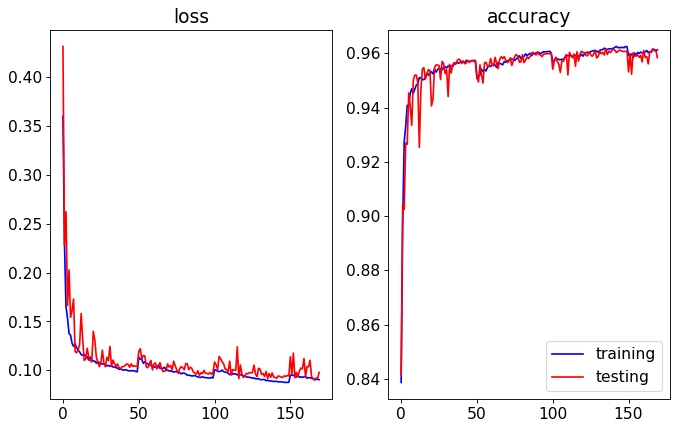

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.06it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


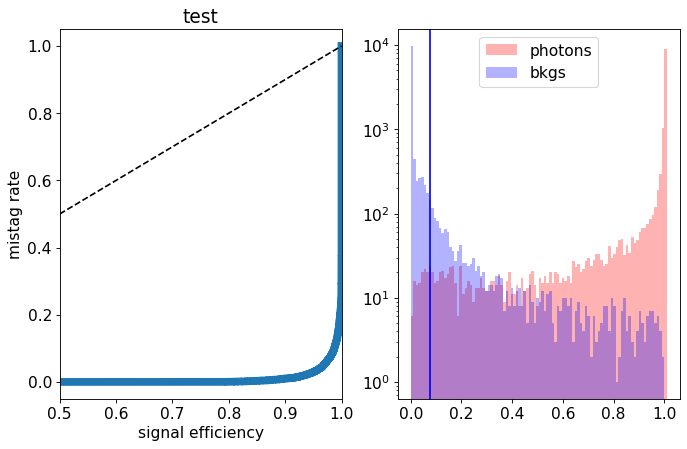

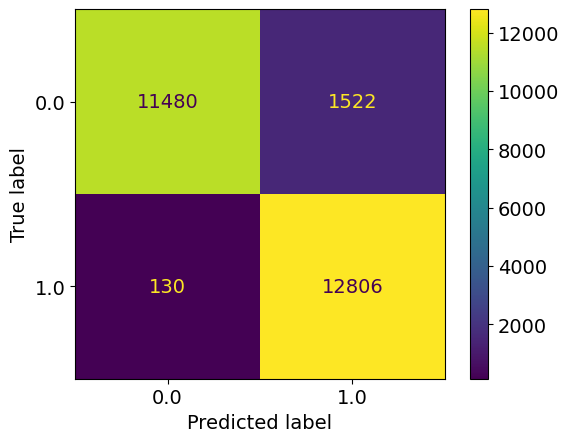

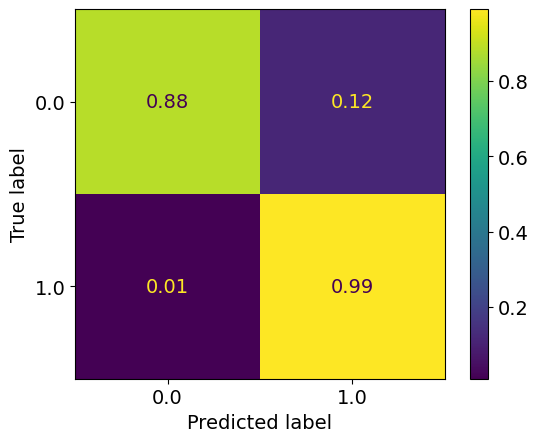

epoch: 170
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.09039661932112164
train acc: 0.9613401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.50it/s]


test loss: 0.10333817519924858
test acc: 0.9583237
epoch: 171
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.23it/s]


train loss: 0.09053859635756883
train acc: 0.96094495


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.09083921851759608
test acc: 0.96125376
epoch: 172
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.089093836250505
train acc: 0.96175456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.09737660092386333
test acc: 0.96032846
epoch: 173
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.08947791949431332
train acc: 0.9615329


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.09210189889100465
test acc: 0.9616393
epoch: 174
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08853494731246392
train acc: 0.96189916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.47it/s]


test loss: 0.09346669268879024
test acc: 0.96075255
epoch: 175
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.08851361031391028
train acc: 0.9622076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.09484389754520221
test acc: 0.9609068
epoch: 176
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.0882651112284619
train acc: 0.9620148


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.65it/s]


test loss: 0.09616583128544418
test acc: 0.9600586
epoch: 177
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08837119349940664
train acc: 0.96234256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.09328667125241323
test acc: 0.9619863
new best acc: 0.9619863
epoch: 178
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.08722515946867838
train acc: 0.9631811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.1014323215931654
test acc: 0.9586321
epoch: 179
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08764048153265364
train acc: 0.96309435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.09466891397129405
test acc: 0.9601357


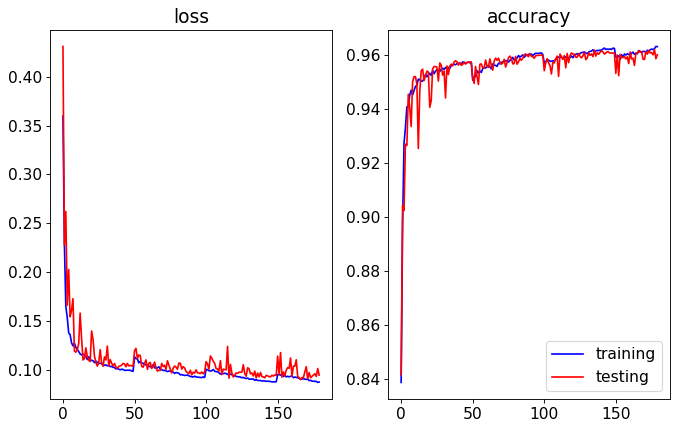

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


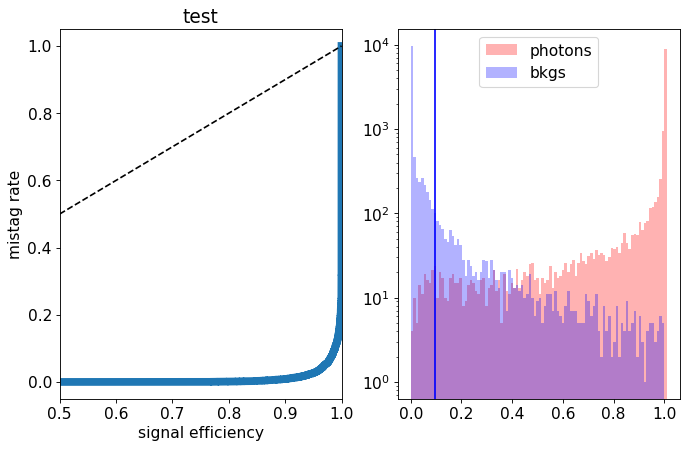

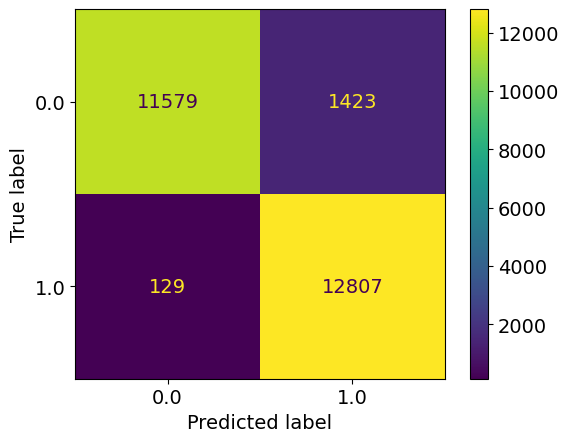

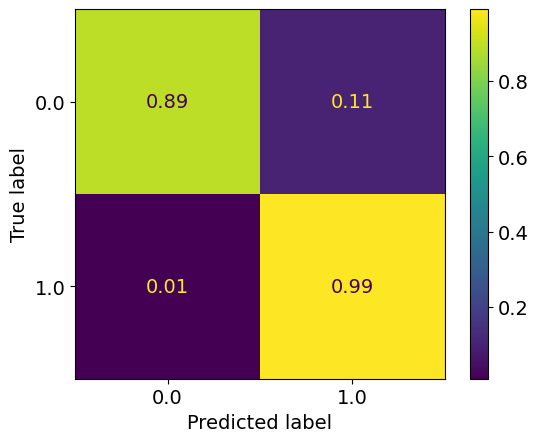

epoch: 180
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.08705585949510508
train acc: 0.9626992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.0965929955074733
test acc: 0.96075255
epoch: 181
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08715774065066624
train acc: 0.96246785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.09508372318338264
test acc: 0.9602514
epoch: 182
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.08663334979573427
train acc: 0.9628148


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.08929751491682096
test acc: 0.9629501
new best acc: 0.9629501
epoch: 183
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08550787226140844
train acc: 0.963557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.08895042978904465
test acc: 0.9624104
epoch: 184
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.0863748583404315
train acc: 0.96300757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.0894415383650498
test acc: 0.9626802
epoch: 185
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.08571185386938855
train acc: 0.9634702


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.56it/s]


test loss: 0.09308428012511948
test acc: 0.9609839
epoch: 186
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.08517664061547014
train acc: 0.96343166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.092053526843136
test acc: 0.9615622
epoch: 187
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08538586682925335
train acc: 0.96345097


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.75it/s]


test loss: 0.0938716996461153
test acc: 0.9606755
epoch: 188
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08561144222241605
train acc: 0.96378833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.09889669614759358
test acc: 0.96102244
epoch: 189
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.45it/s]


train loss: 0.08477877282855138
train acc: 0.9635666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.34it/s]


test loss: 0.0926164063540372
test acc: 0.96167785


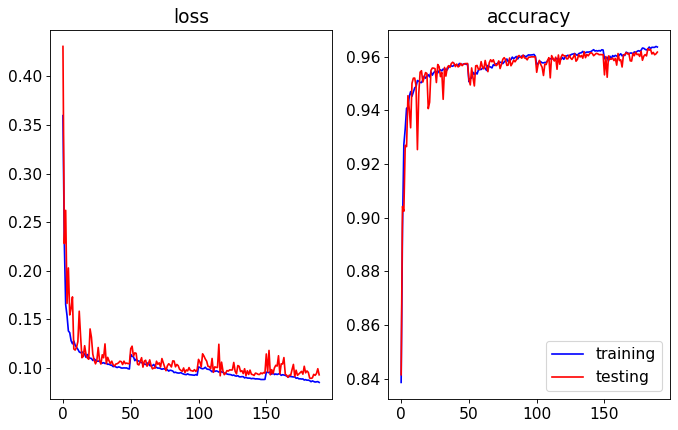

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


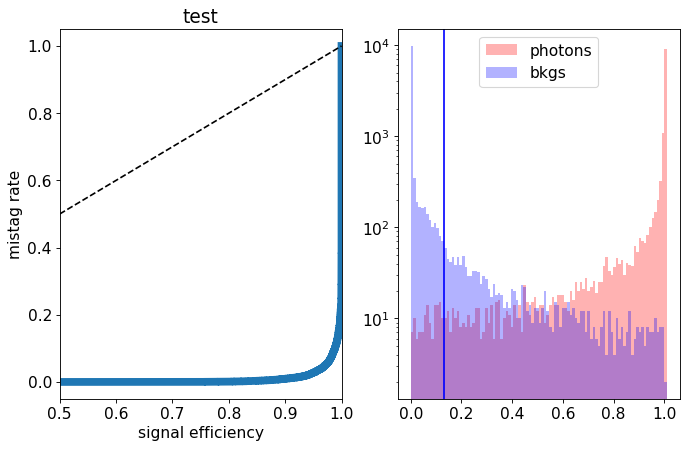

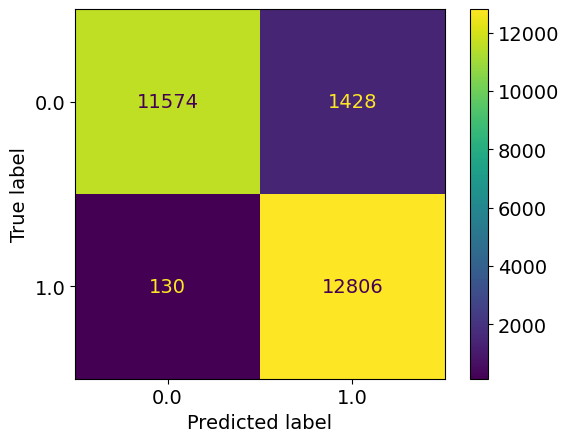

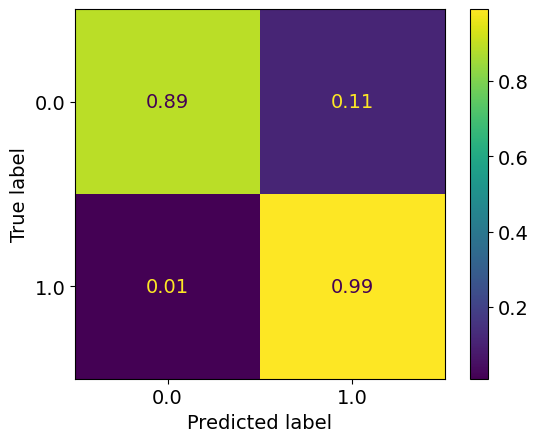

epoch: 190
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08487343678326276
train acc: 0.9635377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.06it/s]


test loss: 0.0920415051620115
test acc: 0.96183205
epoch: 191
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.23it/s]


train loss: 0.08494053365436592
train acc: 0.9637112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.08947505446320231
test acc: 0.9622947
epoch: 192
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08428065608002547
train acc: 0.96397144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.09264777897095139
test acc: 0.9617935
epoch: 193
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.0842062693326115
train acc: 0.96405816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.06it/s]


test loss: 0.09280351320789619
test acc: 0.96210194
epoch: 194
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08440229585232763
train acc: 0.96420276


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.09061372601850466
test acc: 0.9619863
epoch: 195
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.08407785334339031
train acc: 0.9641064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.09139854571020062
test acc: 0.9614465
epoch: 196
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08460028153020523
train acc: 0.9634991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.09129916842688214
test acc: 0.9618706
epoch: 197
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08382183044201377
train acc: 0.9639232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.09142947146161036
test acc: 0.96152365
epoch: 198
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08387940585871652
train acc: 0.9638365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.0924470533024181
test acc: 0.9616393
epoch: 199
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.24it/s]


train loss: 0.08436482416928848
train acc: 0.9641642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.65it/s]


test loss: 0.09194747544825077
test acc: 0.9616393


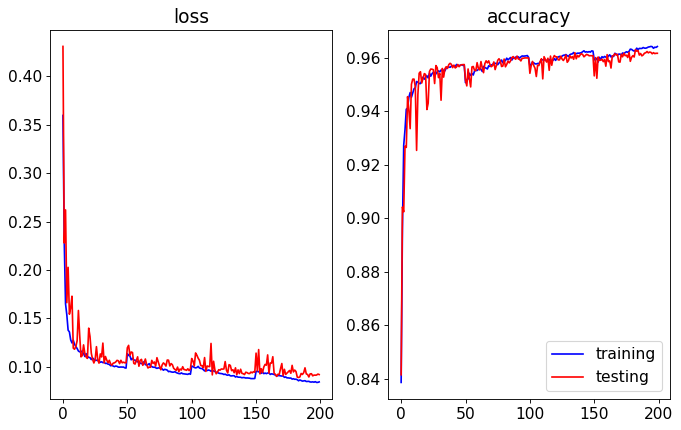

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


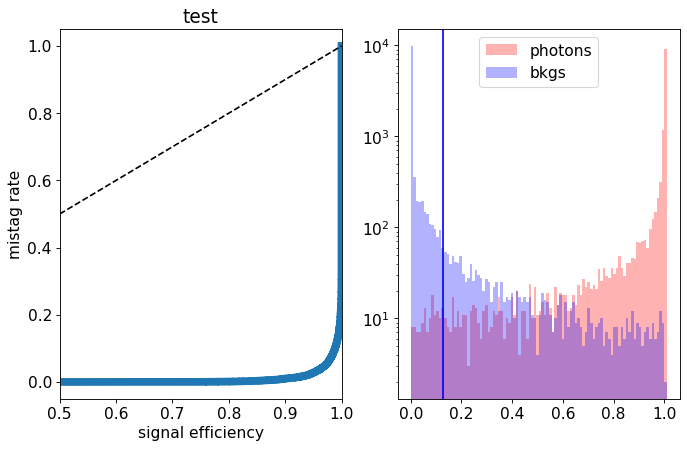

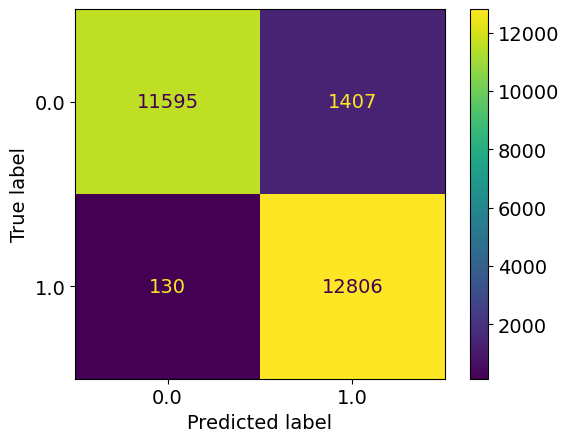

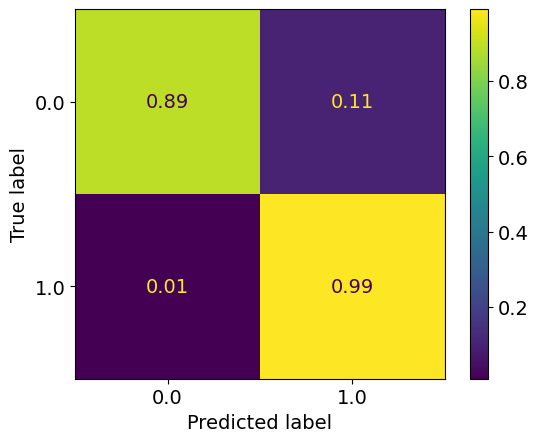

epoch: 200
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.19it/s]


train loss: 0.09211141501978642
train acc: 0.9609353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.81it/s]


test loss: 0.09404552948068488
test acc: 0.96044415
epoch: 201
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09106939514248358
train acc: 0.961504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.09950260242277925
test acc: 0.95828515
epoch: 202
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.090620893295962
train acc: 0.96130157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.09147103266282515
test acc: 0.96109957
epoch: 203
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.09099194534510546
train acc: 0.9609546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.09284135318276557
test acc: 0.9609068
epoch: 204
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.30it/s]


train loss: 0.0903052556936796
train acc: 0.96109915


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.10549088753759861
test acc: 0.9563189
epoch: 205
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.09010121794794336
train acc: 0.96157146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.09017009169540623
test acc: 0.96264166
epoch: 206
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08968577256178581
train acc: 0.96112806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.06it/s]


test loss: 0.08867178188467567
test acc: 0.9629501
epoch: 207
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08958351592710942
train acc: 0.9620052


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.82it/s]


test loss: 0.08839498443359678
test acc: 0.9627188
epoch: 208
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.24it/s]


train loss: 0.0890532988904184
train acc: 0.96222687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.43it/s]


test loss: 0.08870931240645322
test acc: 0.9617164
epoch: 209
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.08942865345605536
train acc: 0.96169674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.0888535820625045
test acc: 0.96217906


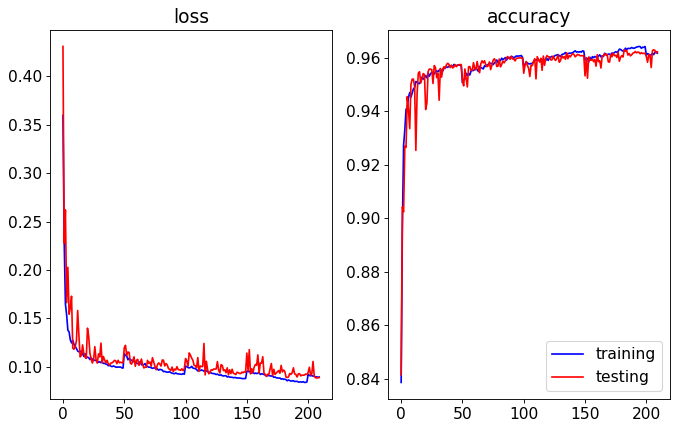

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.78it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


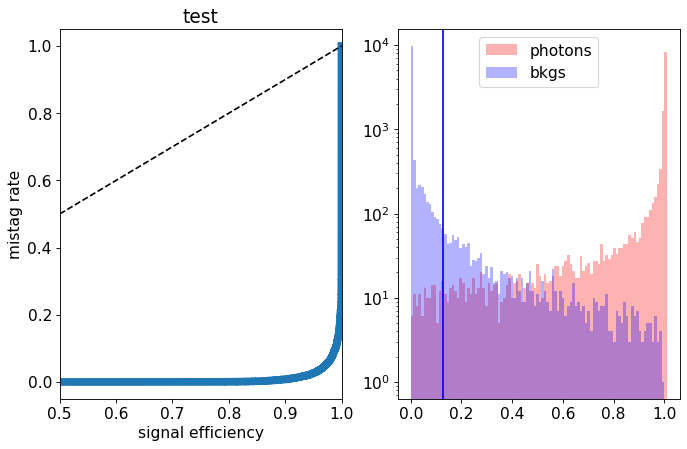

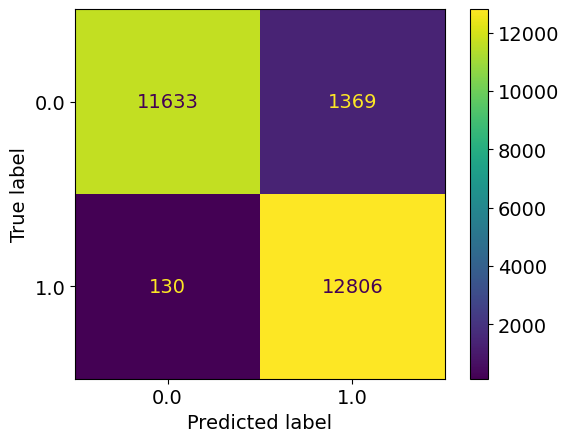

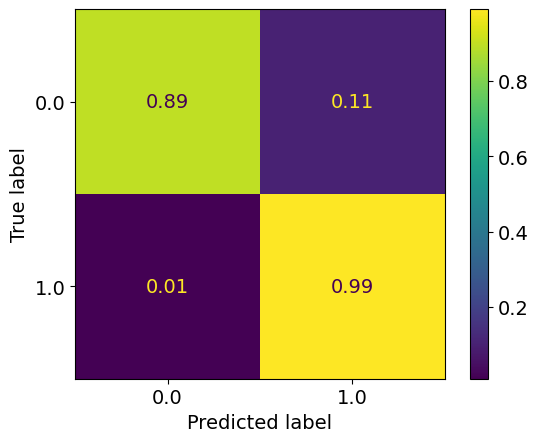

epoch: 210
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.0883525207294205
train acc: 0.9624004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.10065796023065393
test acc: 0.96032846
epoch: 211
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08846548746603762
train acc: 0.9622076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09144760439680381
test acc: 0.96217906
epoch: 212
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08795151353485323
train acc: 0.9621787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.10054348256777633
test acc: 0.95855504
epoch: 213
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.23it/s]


train loss: 0.08773441989556213
train acc: 0.9625835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.58it/s]


test loss: 0.09972141429104588
test acc: 0.9608297
epoch: 214
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08750999645690698
train acc: 0.96244854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.08765412511473353
test acc: 0.96275735
epoch: 215
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.08769549466023556
train acc: 0.9624582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.08865788003260439
test acc: 0.9631429
new best acc: 0.9631429
epoch: 216
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.0874216251635138
train acc: 0.96279556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.0976918510754
test acc: 0.9599815
epoch: 217
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.08713289895068015
train acc: 0.96259314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09424565851011059
test acc: 0.9614465
epoch: 218
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08646348878913532
train acc: 0.9632293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.09038192465562712
test acc: 0.96333563
new best acc: 0.96333563
epoch: 219
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08625496331753069
train acc: 0.96315217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.09562837738882411
test acc: 0.9608297


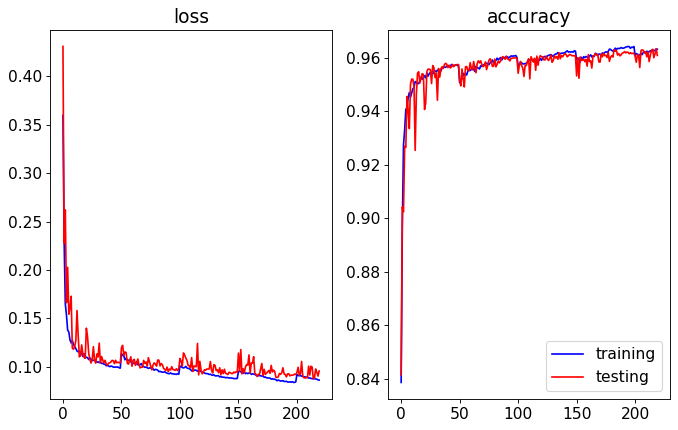

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


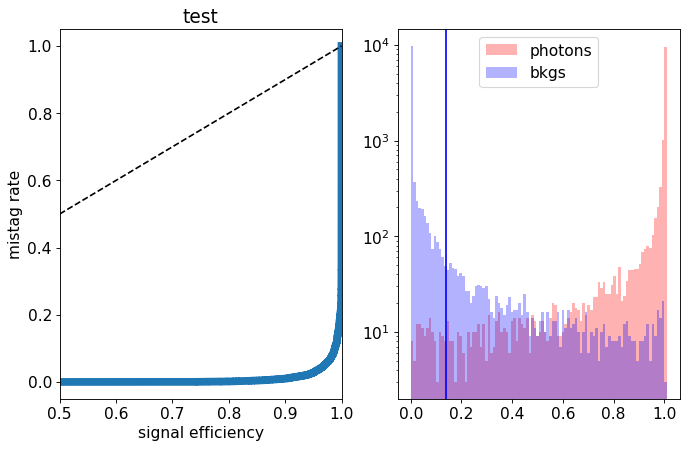

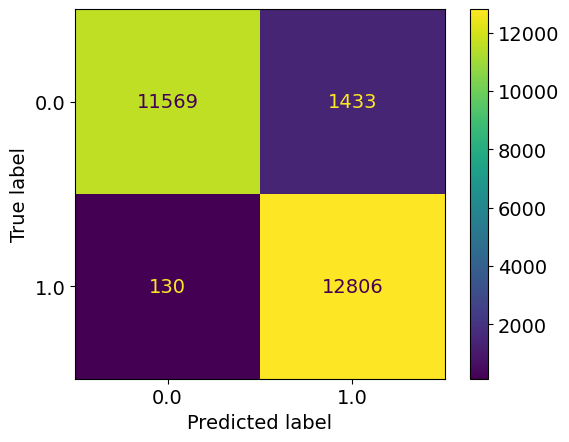

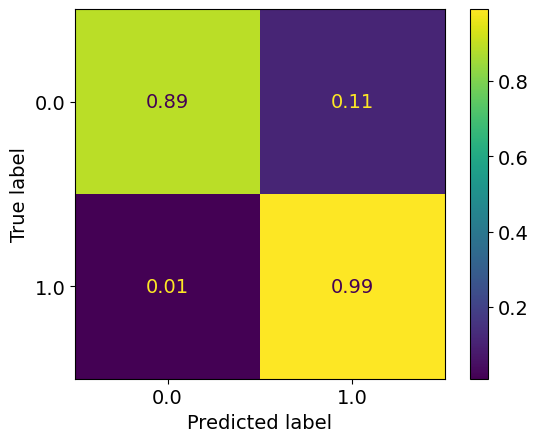

epoch: 220
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08644003713923383
train acc: 0.962969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.69it/s]


test loss: 0.09752947769381783
test acc: 0.9605598
epoch: 221
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08527521192596826
train acc: 0.9633257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09794286185536873
test acc: 0.95963454
epoch: 222
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08562745896808674
train acc: 0.9636437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.78it/s]


test loss: 0.10253857516429642
test acc: 0.9600586
epoch: 223
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.08455481912100936
train acc: 0.96468467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.08865813504565846
test acc: 0.96302724
epoch: 224
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08427803526293336
train acc: 0.96400034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.08892952532253483
test acc: 0.9627959
epoch: 225
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08427877123386873
train acc: 0.96414495


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.0979041379283775
test acc: 0.9607911
epoch: 226
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.08401892390209816
train acc: 0.96453047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.08785109137269584
test acc: 0.96302724
epoch: 227
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08391384500471842
train acc: 0.96418345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.09546084185554223
test acc: 0.9609453
epoch: 228
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08350456930223228
train acc: 0.9645594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.09405920485203917
test acc: 0.9618706
epoch: 229
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08313893436351953
train acc: 0.96447265


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.09178381972014904
test acc: 0.9625646


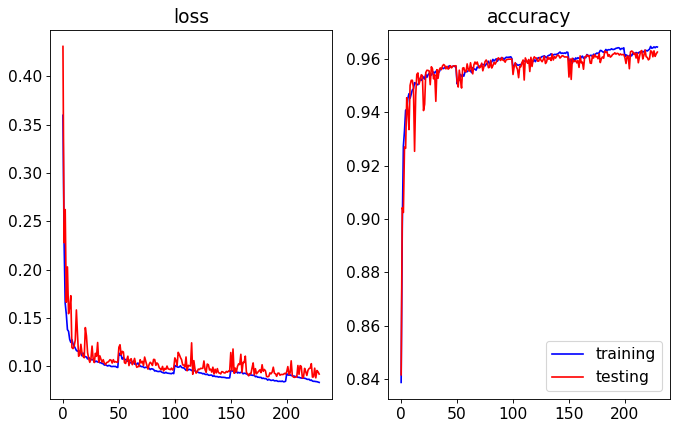

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


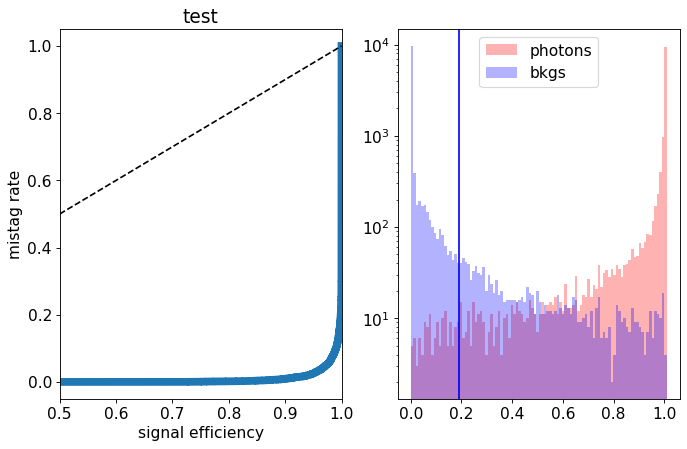

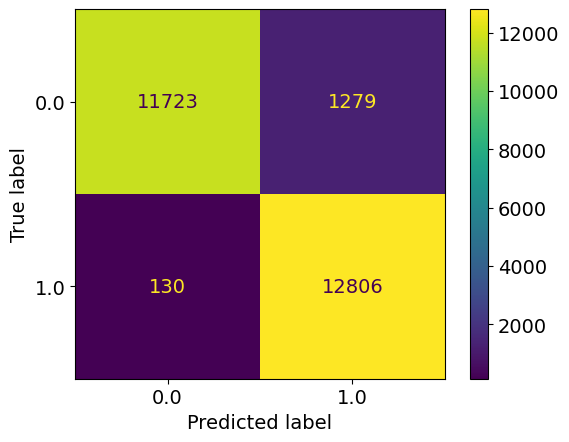

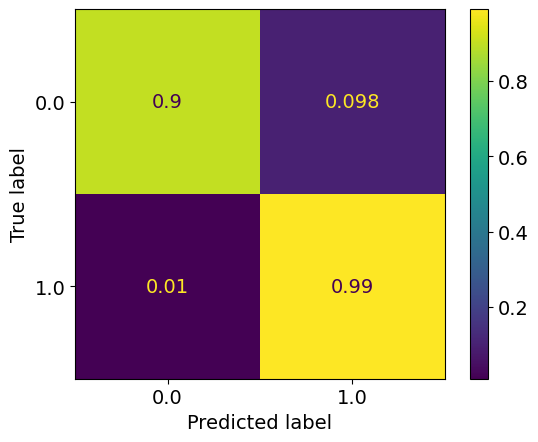

epoch: 230
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08358238394119147
train acc: 0.9646943


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.08906867863102393
test acc: 0.963914
new best acc: 0.963914
epoch: 231
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08258896982135801
train acc: 0.9647618


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.08910343474285169
test acc: 0.96291155
epoch: 232
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08285183829896023
train acc: 0.9649642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.0879697058011185
test acc: 0.96322
epoch: 233
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08249810114072237
train acc: 0.9646654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.64it/s]


test loss: 0.08824468632652001
test acc: 0.9638754
epoch: 234
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08210807351793857
train acc: 0.9649353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.09649327219548551
test acc: 0.9620634
epoch: 235
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08162201516803978
train acc: 0.96555215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.51it/s]


test loss: 0.090234156020663
test acc: 0.9636055
epoch: 236
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08199292718502828
train acc: 0.96498346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.08817211208357052
test acc: 0.9634899
epoch: 237
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.20it/s]


train loss: 0.0812131863927221
train acc: 0.9659859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.48it/s]


test loss: 0.0958471917970614
test acc: 0.9616007
epoch: 238
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.08097003062250298
train acc: 0.9652919


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.57it/s]


test loss: 0.08948412537574768
test acc: 0.96329707
epoch: 239
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.21it/s]


train loss: 0.0813741761265118
train acc: 0.965716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.70it/s]


test loss: 0.08949152905155312
test acc: 0.9636055


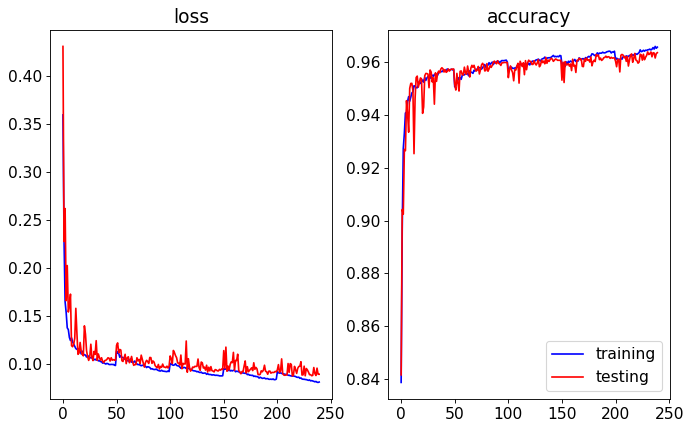

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


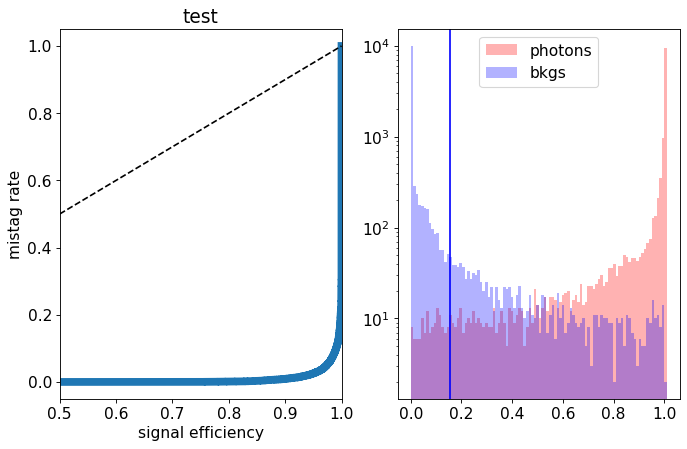

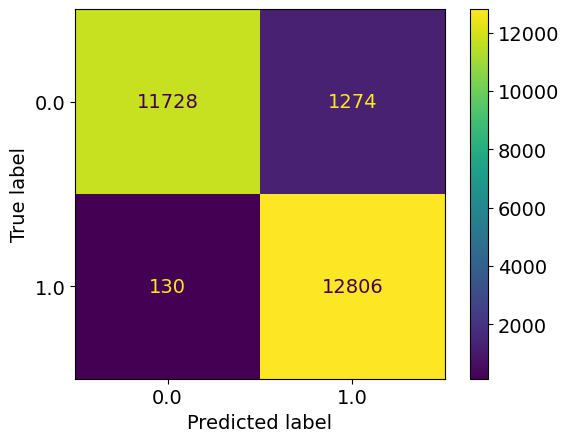

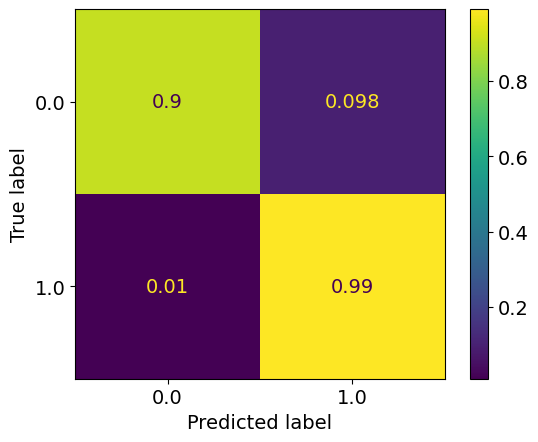

epoch: 240
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.08073455347232736
train acc: 0.9659955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.09408509511161935
test acc: 0.96302724
epoch: 241
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08070684683030051
train acc: 0.96573526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09149454398588701
test acc: 0.962873
epoch: 242
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08045378045281233
train acc: 0.96603405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.08832626027817075
test acc: 0.9636055
epoch: 243
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08067625106414618
train acc: 0.9656003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.0894474263556979
test acc: 0.9636441
epoch: 244
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.079936636622586
train acc: 0.96605337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.088780237023126
test acc: 0.963914
epoch: 245
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.0798287751702215
train acc: 0.9666124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.08816486097533595
test acc: 0.96399105
new best acc: 0.96399105
epoch: 246
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.34it/s]


train loss: 0.08003170329625207
train acc: 0.9656003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.48it/s]


test loss: 0.08839036490429532
test acc: 0.96372116
epoch: 247
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.08002770713643531
train acc: 0.9660437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.58it/s]


test loss: 0.08866306699135086
test acc: 0.96383685
epoch: 248
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.07943055544027014
train acc: 0.9661979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.19it/s]


test loss: 0.08840725376186045
test acc: 0.9639525
epoch: 249
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07990006865621302
train acc: 0.9659184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.08848079878159544
test acc: 0.96399105


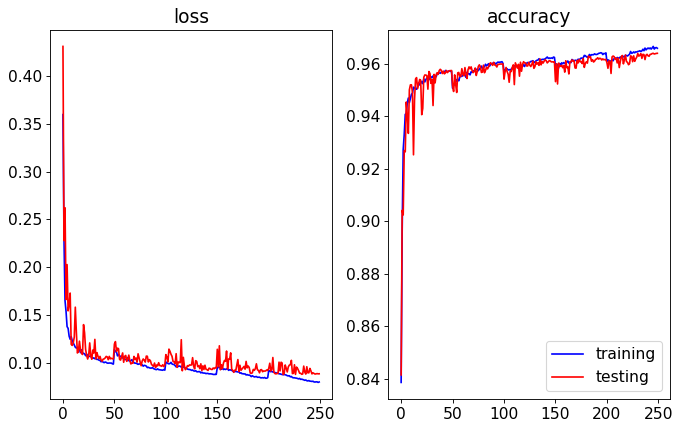

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


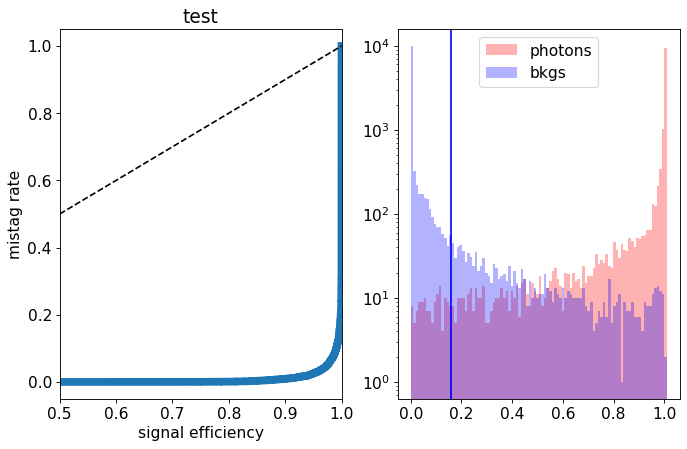

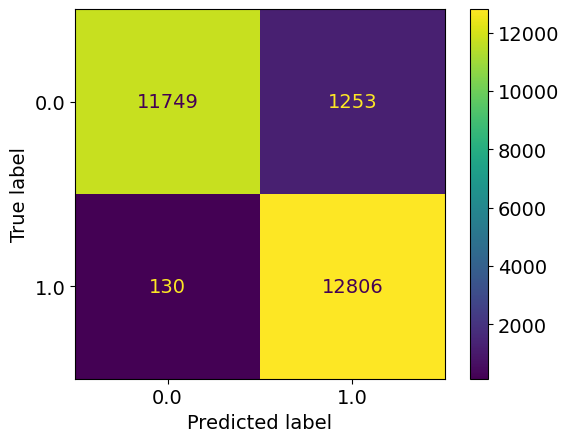

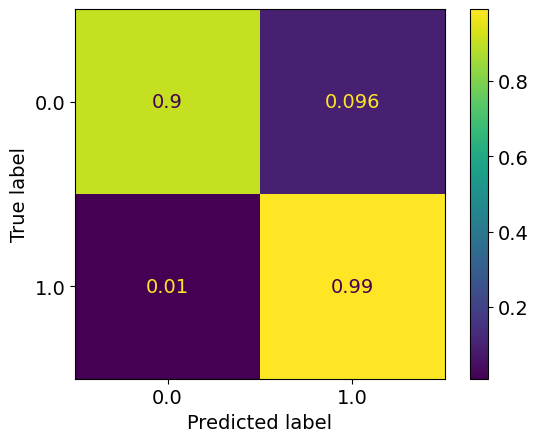

epoch: 250
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08718589635167508
train acc: 0.96324855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.13204697604206475
test acc: 0.9548539
epoch: 251
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08755082893319902
train acc: 0.962998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.08928325467488983
test acc: 0.9624489
epoch: 252
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.08651617470848767
train acc: 0.96334493


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.09423391690308397
test acc: 0.9619863
epoch: 253
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.44it/s]


train loss: 0.08742170188726717
train acc: 0.96306545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.10664432487365874
test acc: 0.9583622
epoch: 254
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08467693006716712
train acc: 0.9633835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.09405760907314041
test acc: 0.96221757
epoch: 255
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08508955086500658
train acc: 0.96352804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.08930483045564457
test acc: 0.9628345
epoch: 256
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08635648520867949
train acc: 0.96351844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.0996424566785043
test acc: 0.9584779
epoch: 257
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.0846907531982557
train acc: 0.9640775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.08960537307641724
test acc: 0.96329707
epoch: 258
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.08453714190793864
train acc: 0.9644919


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.09677909094501626
test acc: 0.96260315
epoch: 259
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08545266068136761
train acc: 0.96405816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.1278134189884771
test acc: 0.9544298


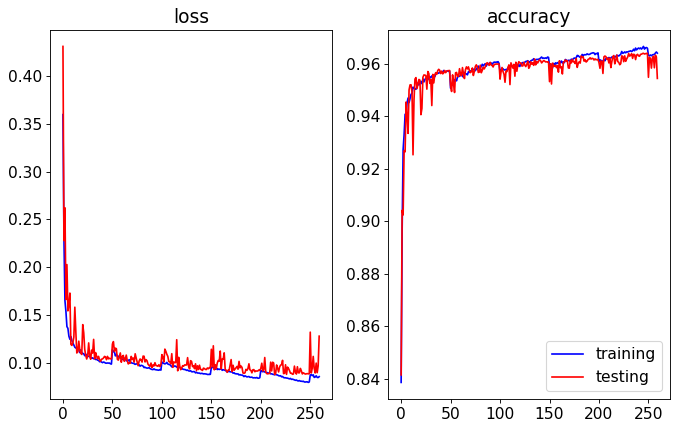

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.63it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


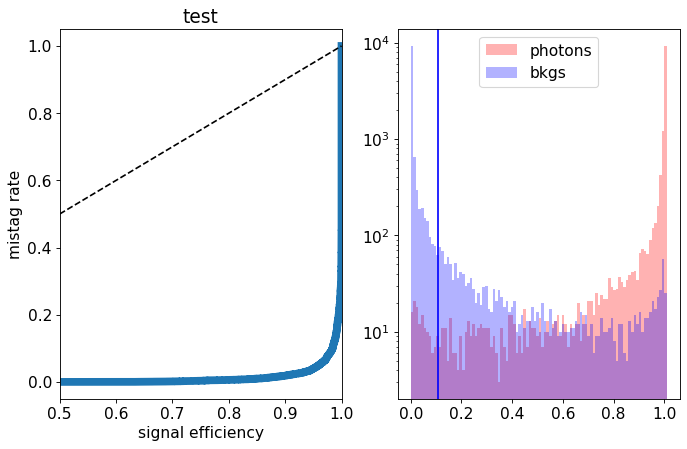

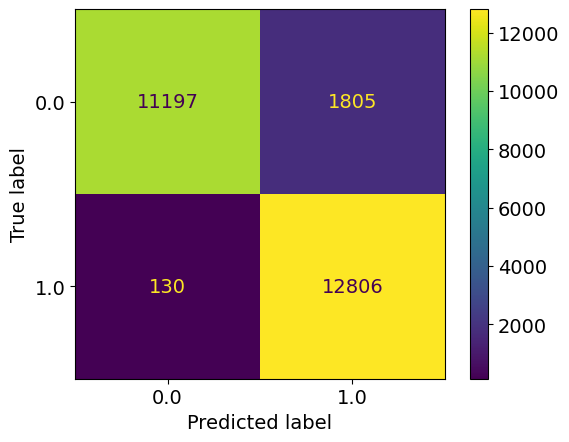

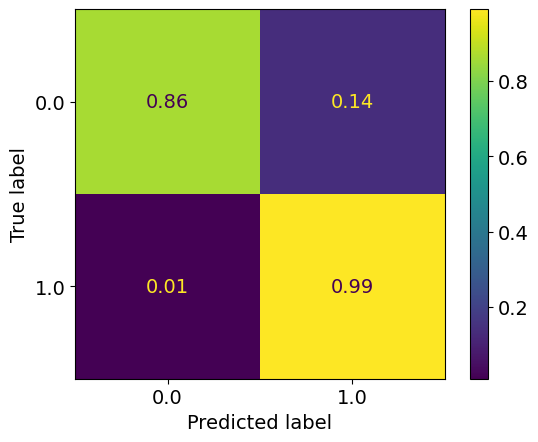

epoch: 260
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.084769139981511
train acc: 0.9640196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.11368896422738378
test acc: 0.9594417
epoch: 261
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08420058240780251
train acc: 0.9647425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.79it/s]


test loss: 0.09092745489694855
test acc: 0.961755
epoch: 262
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08433765631621283
train acc: 0.96459794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.12081379155543717
test acc: 0.95705146
epoch: 263
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.08450607440805849
train acc: 0.9642799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.05it/s]


test loss: 0.09043353677473286
test acc: 0.96399105
epoch: 264
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08282117250596167
train acc: 0.9653401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.09817113786597144
test acc: 0.961061
epoch: 265
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.24it/s]


train loss: 0.08267423805559991
train acc: 0.9656389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.54it/s]


test loss: 0.09329988104714589
test acc: 0.9623718
epoch: 266
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.08188632016495473
train acc: 0.96620756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.08574609306048263
test acc: 0.96476215
new best acc: 0.96476215
epoch: 267
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.08215969312139329
train acc: 0.9656389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.08592602517455816
test acc: 0.96507055
new best acc: 0.96507055
epoch: 268
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.08164637563803981
train acc: 0.9655907


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.1007435718043284
test acc: 0.9614851
epoch: 269
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.0816581753120257
train acc: 0.9653979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.09017212587324056
test acc: 0.96426094


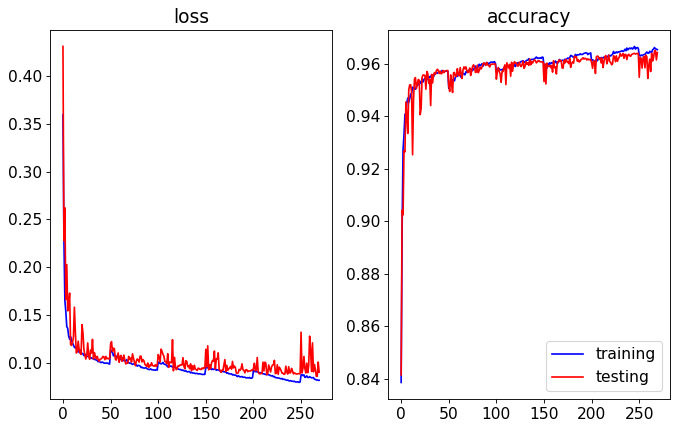

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


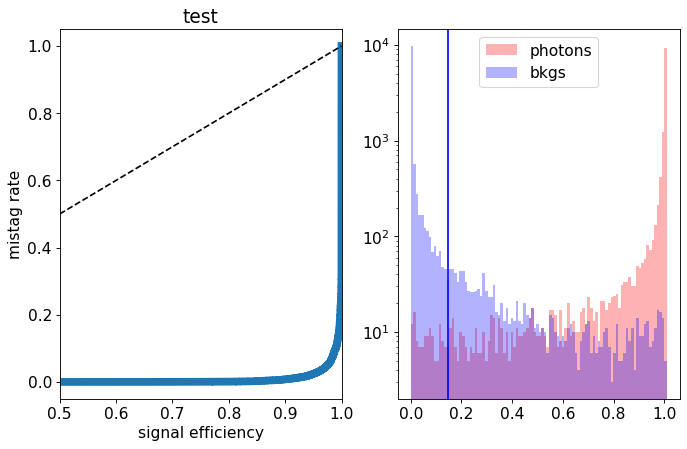

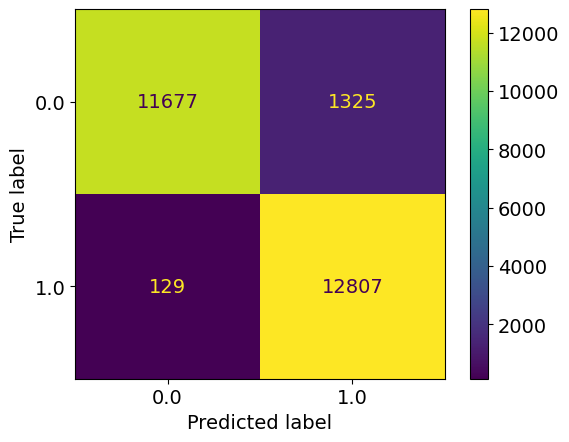

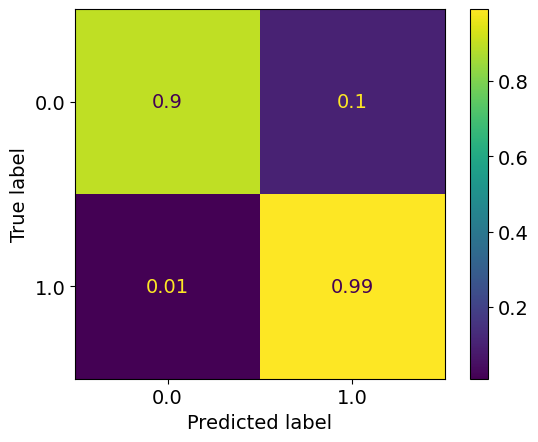

epoch: 270
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.24it/s]


train loss: 0.08064377781628185
train acc: 0.96594733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.82it/s]


test loss: 0.10453016649593007
test acc: 0.96009713
epoch: 271
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08054440574063731
train acc: 0.96660274


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.08686170921745626
test acc: 0.96302724
epoch: 272
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.08040283605284085
train acc: 0.96606296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.0940078418193893
test acc: 0.96341276
epoch: 273
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08034655361334024
train acc: 0.9661979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.09837794447825714
test acc: 0.96233326
epoch: 274
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07981629329437466
train acc: 0.9668919


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.09771843652494928
test acc: 0.96210194
epoch: 275
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.079637785522924
train acc: 0.9664389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.11300591252405535
test acc: 0.9598658
epoch: 276
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07920290454360791
train acc: 0.96677625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.47it/s]


test loss: 0.09250144990669056
test acc: 0.96356696
epoch: 277
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.07875594944623164
train acc: 0.9670075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.84it/s]


test loss: 0.10868536867201328
test acc: 0.9598658
epoch: 278
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.0782476083908467
train acc: 0.96677625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.10376500863243233
test acc: 0.9609839
epoch: 279
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07820031098547699
train acc: 0.96713287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.50it/s]


test loss: 0.09818724492056803
test acc: 0.9627188


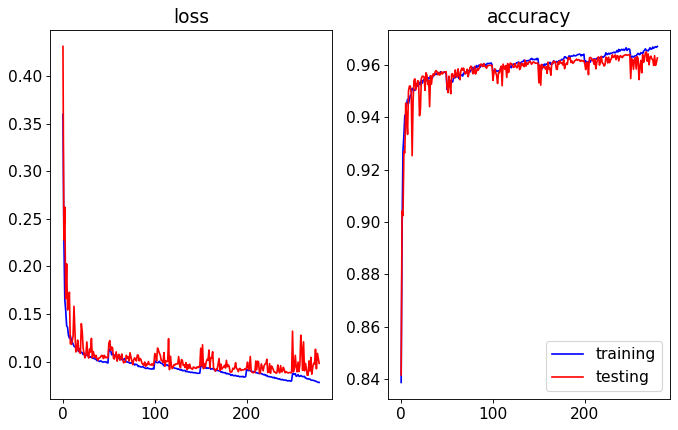

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


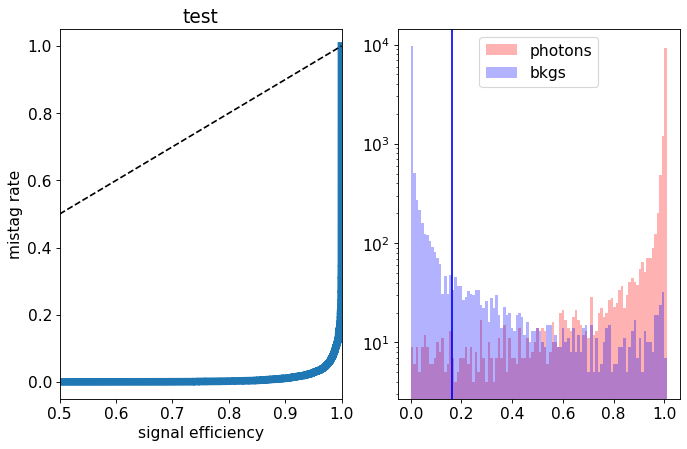

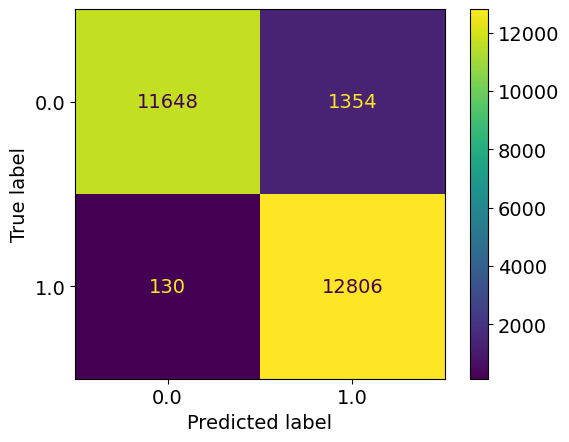

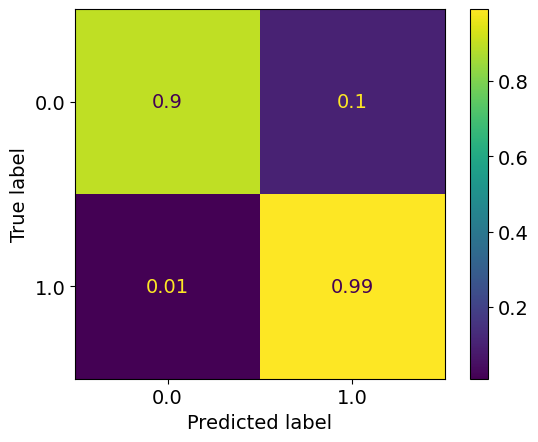

epoch: 280
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07848863256287712
train acc: 0.9669401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09590930898081172
test acc: 0.96329707
epoch: 281
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07823838218185254
train acc: 0.9672485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.77it/s]


test loss: 0.11260138147256592
test acc: 0.9587478
epoch: 282
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07795793694481684
train acc: 0.9669786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.72it/s]


test loss: 0.1347923189062964
test acc: 0.95705146
epoch: 283
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.07746446810964215
train acc: 0.9673256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.59it/s]


test loss: 0.11196854168718512
test acc: 0.96017426
epoch: 284
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07647621801736727
train acc: 0.96813524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.12866554476998068
test acc: 0.9583237
epoch: 285
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07654464608758171
train acc: 0.96827984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.50it/s]


test loss: 0.10458728806539015
test acc: 0.9609453
epoch: 286
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.07716122517265336
train acc: 0.96780753


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.50it/s]


test loss: 0.1018379358574748
test acc: 0.9614465
epoch: 287
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.07584511299181536
train acc: 0.9683955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.11656125871972604
test acc: 0.9594032
epoch: 288
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07589676894376733
train acc: 0.96803886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.10122024149379948
test acc: 0.962526
epoch: 289
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07561480919319082
train acc: 0.9676919


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.42it/s]


test loss: 0.09993408086963675
test acc: 0.96260315


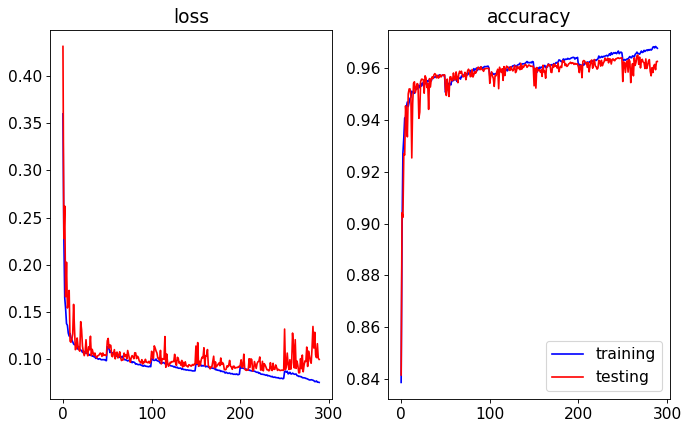

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


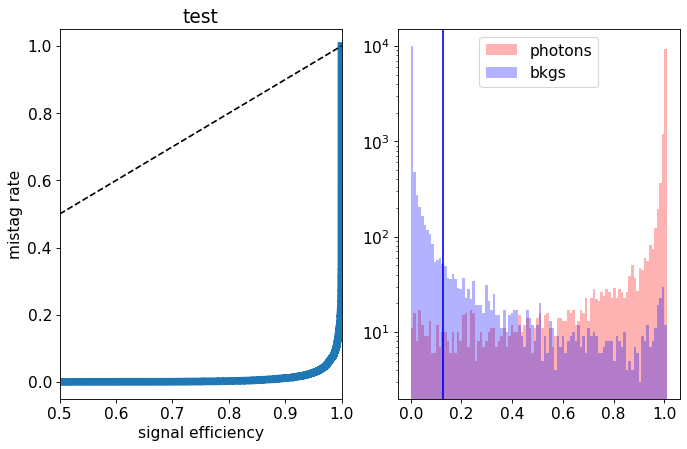

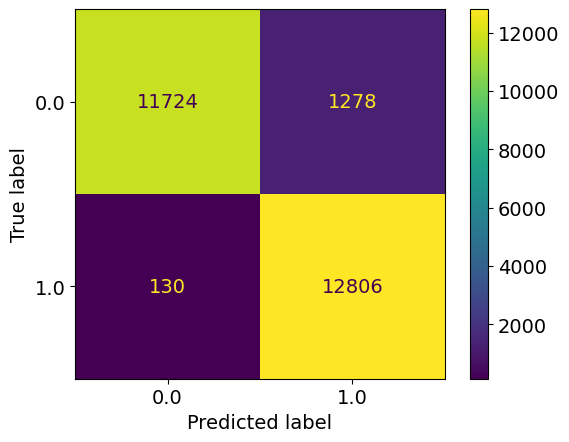

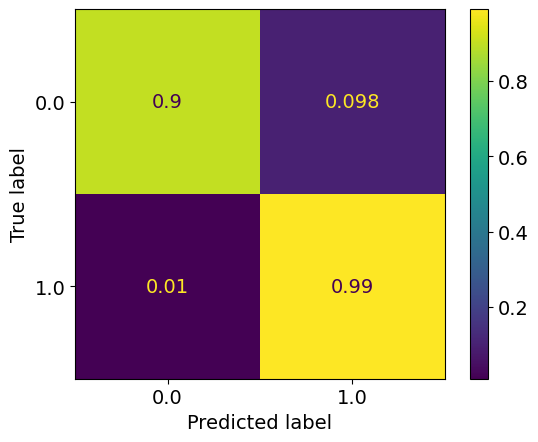

epoch: 290
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.07560440645999991
train acc: 0.96819305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.09914362405172804
test acc: 0.96325856
epoch: 291
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07589052882411576
train acc: 0.9685015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.10470903707160191
test acc: 0.96210194
epoch: 292
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.07545862880917643
train acc: 0.9682605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.45it/s]


test loss: 0.10339737497270107
test acc: 0.9622947
epoch: 293
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.17it/s]


train loss: 0.07519130985860879
train acc: 0.96830875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.10994750718501481
test acc: 0.96194774
epoch: 294
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.07521577095451383
train acc: 0.96833766


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.55it/s]


test loss: 0.10331753243438223
test acc: 0.9624489
epoch: 295
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.0752948195259006
train acc: 0.968569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.101289734413678
test acc: 0.96275735
epoch: 296
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.0749392041968817
train acc: 0.96863645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.78it/s]


test loss: 0.10253995132039893
test acc: 0.9623718
epoch: 297
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07474623357801768
train acc: 0.96880996


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.10130992413244465
test acc: 0.962526
epoch: 298
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.19it/s]


train loss: 0.07491939226326914
train acc: 0.96858823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.10182864362881942
test acc: 0.9626802
epoch: 299
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07507762510997022
train acc: 0.96851116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.10300663782452996
test acc: 0.9626802


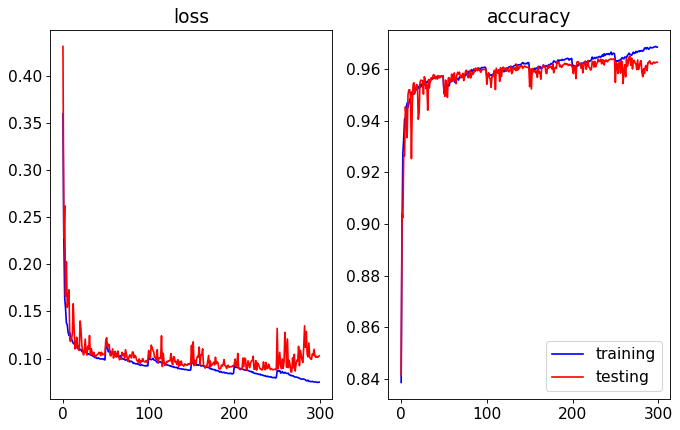

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


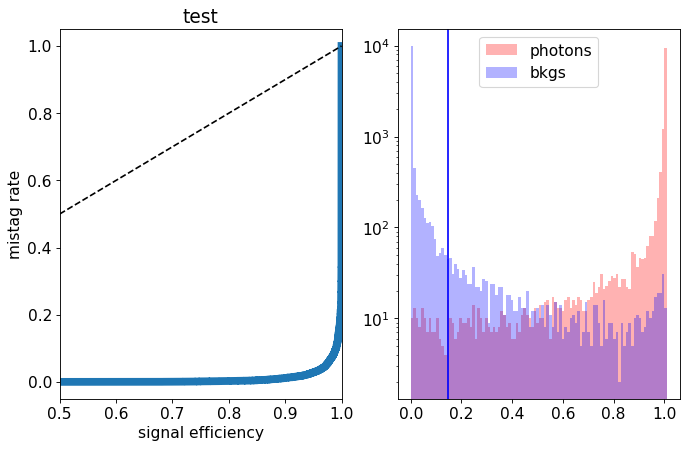

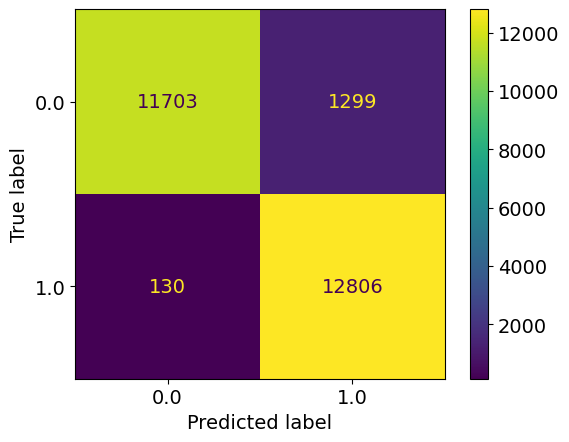

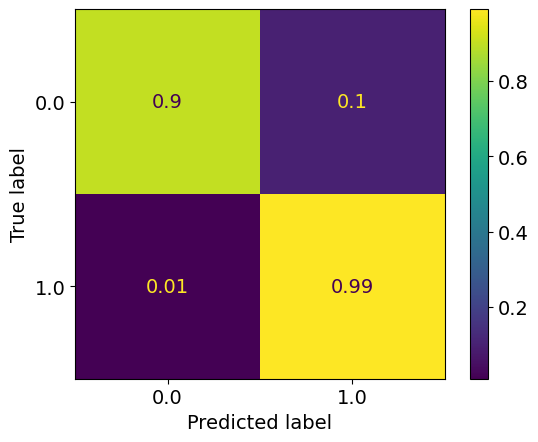

epoch: 300
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08284367427143748
train acc: 0.96522444


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.10049664703282443
test acc: 0.95855504
epoch: 301
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.08244317350101608
train acc: 0.96534973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.44it/s]


test loss: 0.09949623251503165
test acc: 0.9626802
epoch: 302
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.22it/s]


train loss: 0.08217473390560619
train acc: 0.9650028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.08511909825558012
test acc: 0.964685
epoch: 303
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.34it/s]


train loss: 0.08168458680196994
train acc: 0.9659666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.09291169894012538
test acc: 0.96456933
epoch: 304
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.0807543315337917
train acc: 0.9659569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.73it/s]


test loss: 0.09052946748719974
test acc: 0.96564883
new best acc: 0.96564883
epoch: 305
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.08081263376970511
train acc: 0.9657931


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.11155930042944172
test acc: 0.9592875
epoch: 306
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.07966997129896472
train acc: 0.96630394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.09543071670288389
test acc: 0.96372116
epoch: 307
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.39it/s]


train loss: 0.0807616643909085
train acc: 0.9662172


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.23it/s]


test loss: 0.09802025107836182
test acc: 0.96194774
epoch: 308
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.08039210717371434
train acc: 0.96636176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.1328907712278041
test acc: 0.9566659
epoch: 309
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.08077726659574949
train acc: 0.9663232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.80it/s]


test loss: 0.11237768117677081
test acc: 0.958902


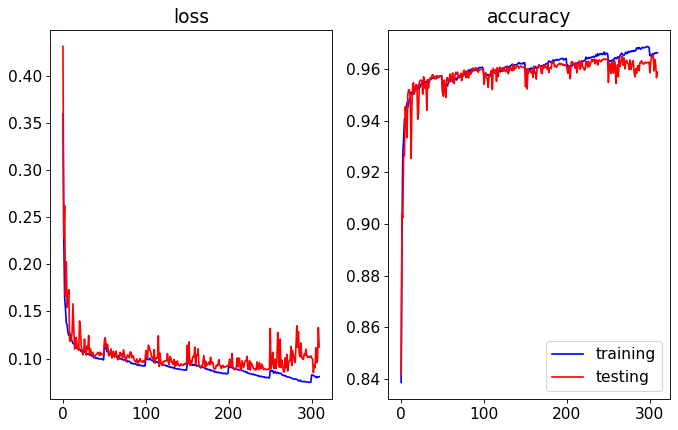

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


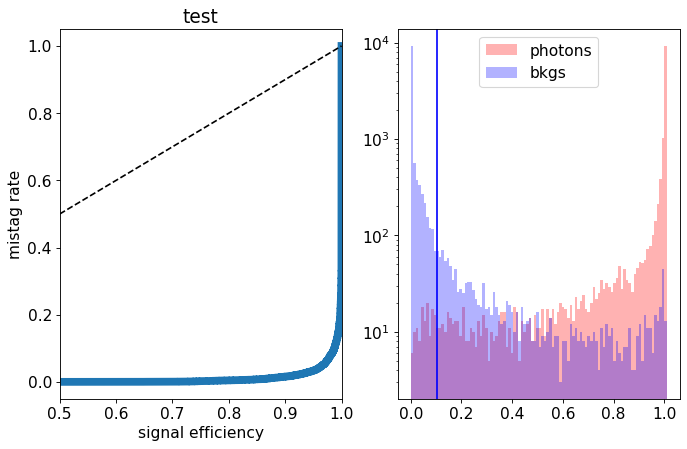

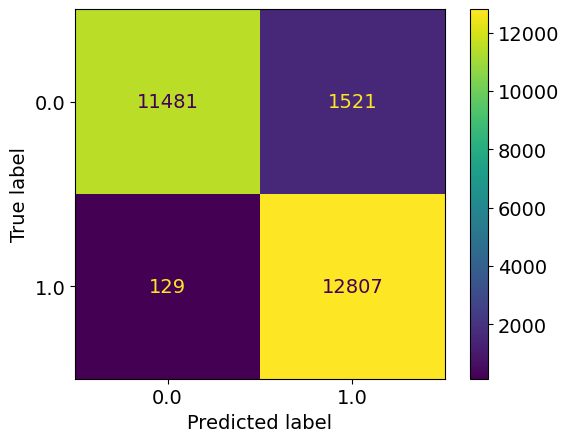

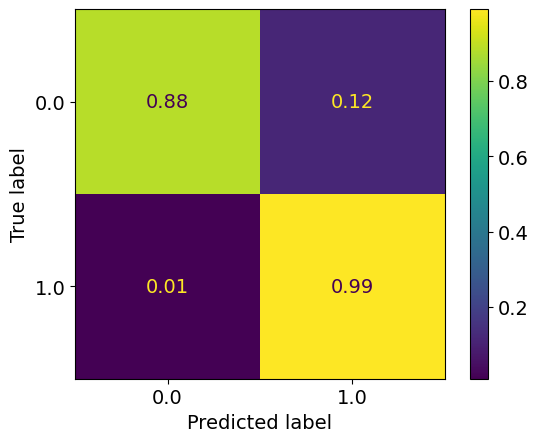

epoch: 310
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.0809130964294679
train acc: 0.9655425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.52it/s]


test loss: 0.12638105282729323
test acc: 0.9586321
epoch: 311
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.20it/s]


train loss: 0.08036500760327185
train acc: 0.9665449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.11885092509063808
test acc: 0.95801526
epoch: 312
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07997566450796376
train acc: 0.9667377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.12364442240108144
test acc: 0.95828515
epoch: 313
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.08022143207275109
train acc: 0.96641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.11536880599504168
test acc: 0.9586321
epoch: 314
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.08003269857323239
train acc: 0.9667666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.11504673957824707
test acc: 0.9604827
epoch: 315
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07893850008359535
train acc: 0.96681476


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.15029775850813498
test acc: 0.95678157
epoch: 316
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.07872546500811688
train acc: 0.9673353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.70it/s]


test loss: 0.11705694491551681
test acc: 0.9617935
epoch: 317
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.19it/s]


train loss: 0.07832110050871882
train acc: 0.967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.61it/s]


test loss: 0.10452473942529071
test acc: 0.9624489
epoch: 318
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.0785806769063707
train acc: 0.96743166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.1107061007483439
test acc: 0.9624104
epoch: 319
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.07799887807899816
train acc: 0.9673353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.09057204780930822
test acc: 0.9648392


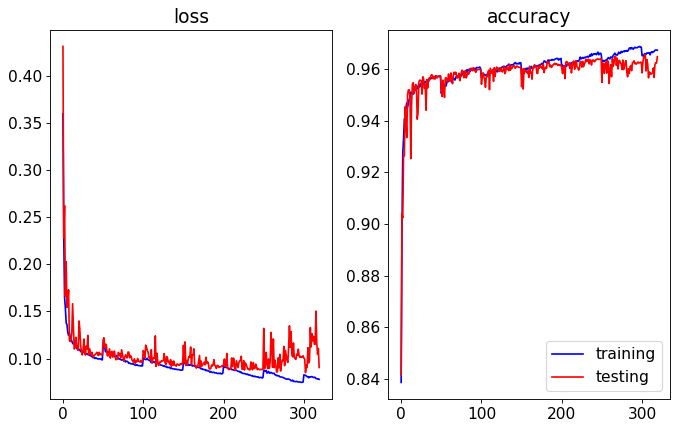

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


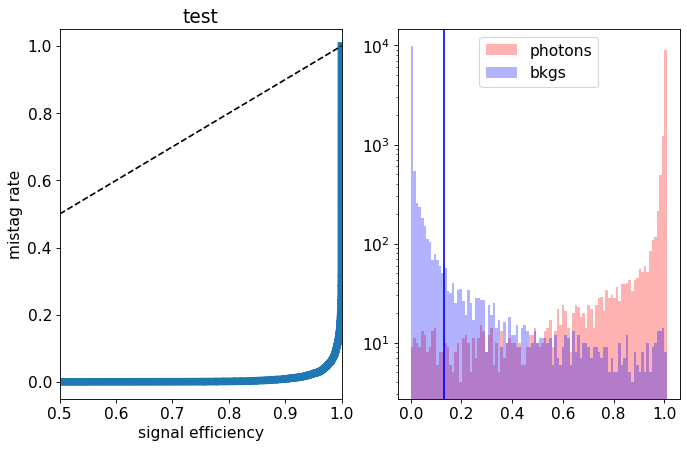

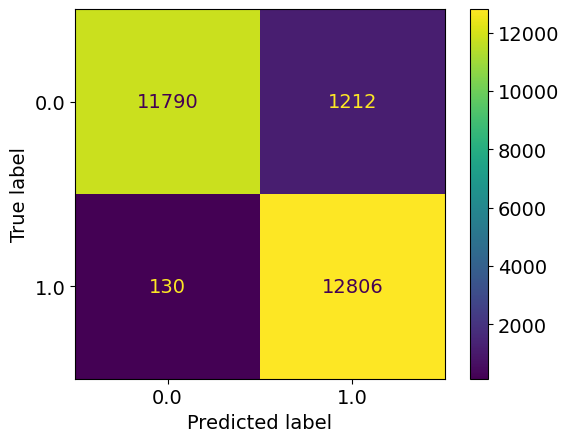

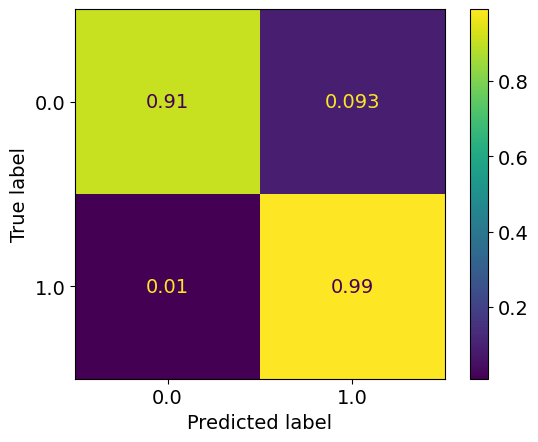

epoch: 320
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.16it/s]


train loss: 0.07831840811437266
train acc: 0.9669208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.15471394089135257
test acc: 0.95682013
epoch: 321
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.07835863276540889
train acc: 0.96722925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.11345229247076945
test acc: 0.96210194
epoch: 322
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.07807787794167596
train acc: 0.96680516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.12224992906505411
test acc: 0.9587863
epoch: 323
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.07745602061552119
train acc: 0.96788466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.97it/s]


test loss: 0.12078175304288213
test acc: 0.9583622
epoch: 324
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.23it/s]


train loss: 0.0769496155267506
train acc: 0.9679907


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.42it/s]


test loss: 0.10665783015164462
test acc: 0.9609839
epoch: 325
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.30it/s]


train loss: 0.07665196810499092
train acc: 0.96753764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.70it/s]


test loss: 0.12223150530322031
test acc: 0.95855504
epoch: 326
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07684535649470511
train acc: 0.9677497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.13467942872508007
test acc: 0.95597196
epoch: 327
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07680086808742126
train acc: 0.96846294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.11826361817392436
test acc: 0.96086824
epoch: 328
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07552423319547852
train acc: 0.9684726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.12219694138250568
test acc: 0.9594417
epoch: 329
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07590719603131273
train acc: 0.968569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.10738934982906688
test acc: 0.9609068


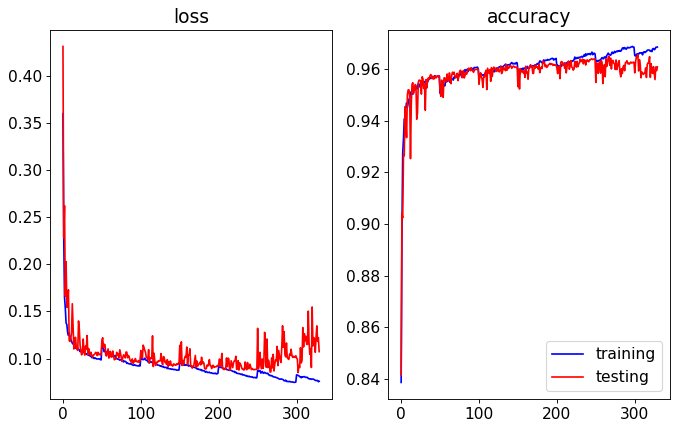

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


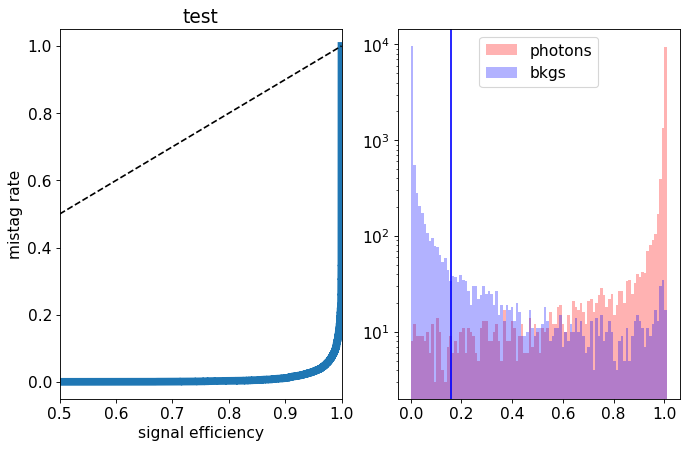

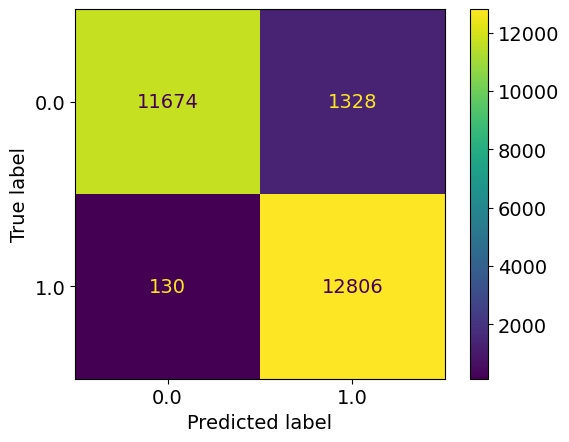

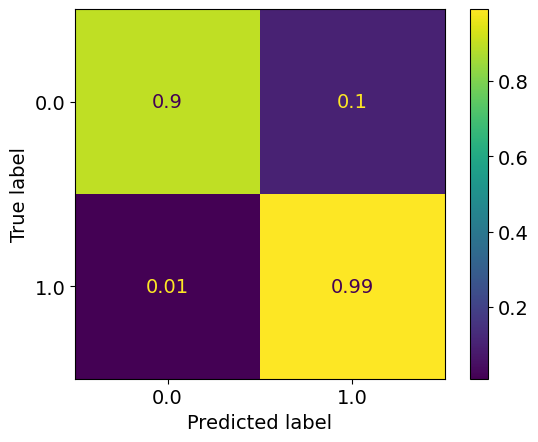

epoch: 330
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.07514307858971501
train acc: 0.96821237


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.11244182119315321
test acc: 0.9608297
epoch: 331
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07546810196400378
train acc: 0.96851116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.11732380718670109
test acc: 0.9609068
epoch: 332
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.45it/s]


train loss: 0.07517334549671653
train acc: 0.9686268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.30it/s]


test loss: 0.11580923335118727
test acc: 0.9602899
epoch: 333
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07481313415000894
train acc: 0.9687521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.12313161587173288
test acc: 0.95951885
epoch: 334
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.07415741432264361
train acc: 0.96890634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.64it/s]


test loss: 0.12241162588311867
test acc: 0.9595574
epoch: 335
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.07460549213207526
train acc: 0.9689545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.82it/s]


test loss: 0.1251656131988222
test acc: 0.9594803
epoch: 336
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.07396929469928576
train acc: 0.9690413


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.06it/s]


test loss: 0.11255578374998136
test acc: 0.96086824
epoch: 337
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.07418499772862203
train acc: 0.96896416


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.1098977422172373
test acc: 0.96167785
epoch: 338
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.38it/s]


train loss: 0.07378366229937255
train acc: 0.9691858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.11943241141059181
test acc: 0.9602899
epoch: 339
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07344714360516195
train acc: 0.9690027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.11040705315430056
test acc: 0.9624489


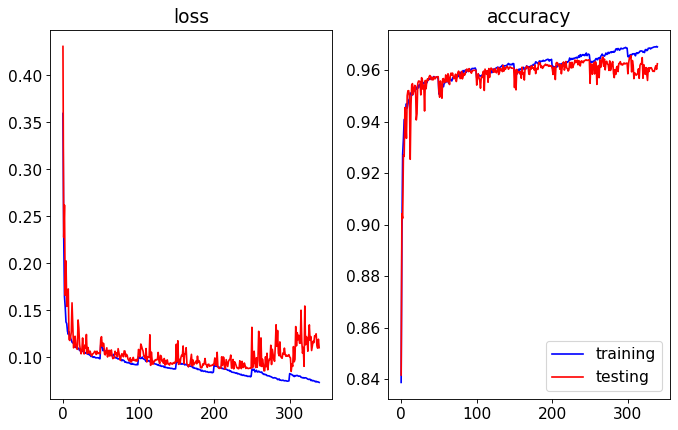

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


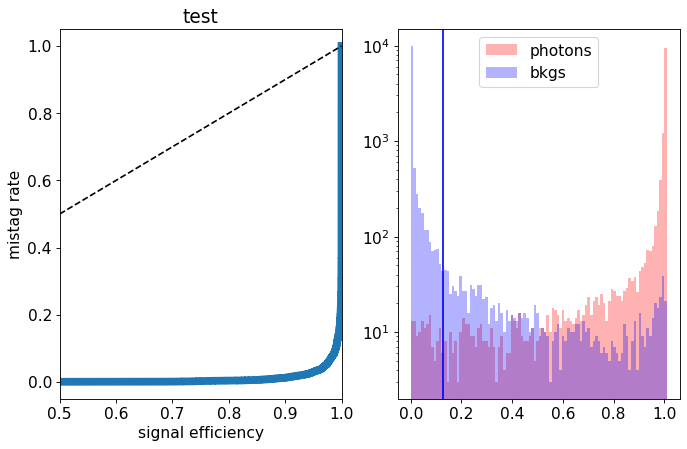

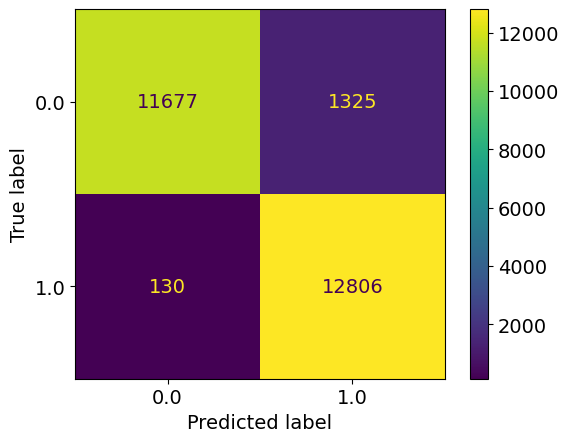

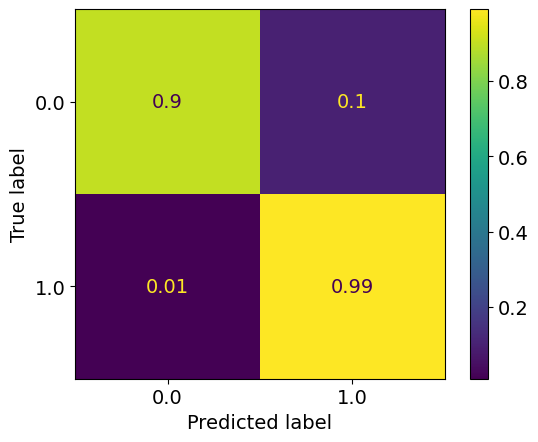

epoch: 340
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07400000360229111
train acc: 0.96914726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.10390586524524471
test acc: 0.96306574
epoch: 341
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.0729741466829198
train acc: 0.9694268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.12100480987944386
test acc: 0.96032846
epoch: 342
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07309132586152567
train acc: 0.96910876


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.58it/s]


test loss: 0.11627296680076556
test acc: 0.9614851
epoch: 343
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.072570847336612
train acc: 0.9697931


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.1160228420895609
test acc: 0.9612152
epoch: 344
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.072911485986558
train acc: 0.9699087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.68it/s]


test loss: 0.11734330874275077
test acc: 0.96125376
epoch: 345
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.30it/s]


train loss: 0.07212611277065525
train acc: 0.9699184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.41it/s]


test loss: 0.11424999836493623
test acc: 0.96152365
epoch: 346
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:49<00:00,  3.47it/s]


train loss: 0.07269407742026913
train acc: 0.96959066


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.1187178236855702
test acc: 0.96059835
epoch: 347
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.34it/s]


train loss: 0.07284768746164492
train acc: 0.96953285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.67it/s]


test loss: 0.1211254552684047
test acc: 0.9606369
epoch: 348
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.12it/s]


train loss: 0.07244934509858231
train acc: 0.9696196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.75it/s]


test loss: 0.1201108821921728
test acc: 0.9607911
epoch: 349
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.0717949348076575
train acc: 0.96996653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.67it/s]


test loss: 0.11905163594267586
test acc: 0.96086824


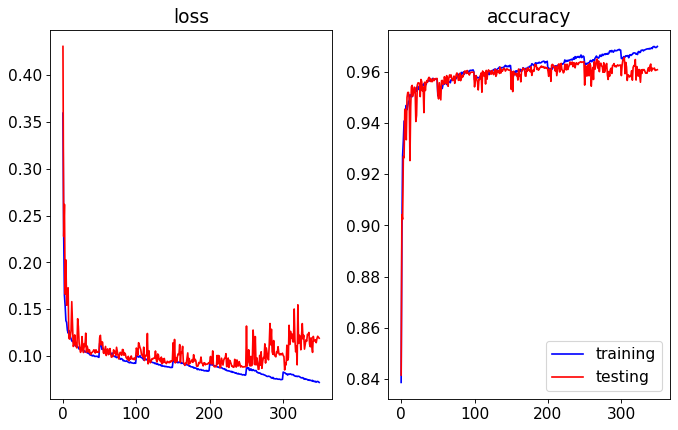

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.65it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


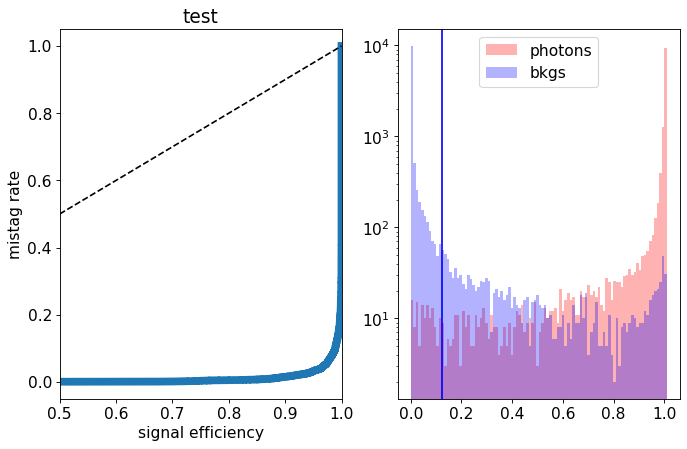

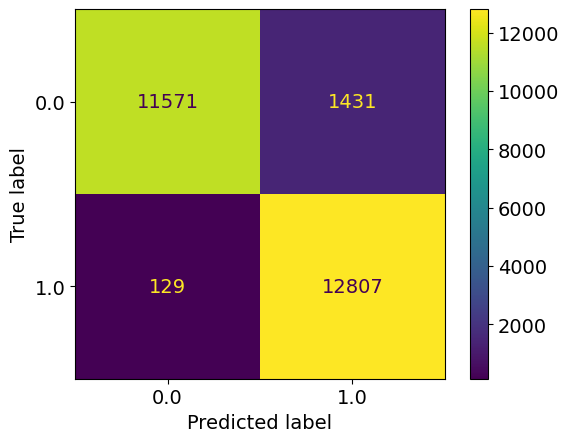

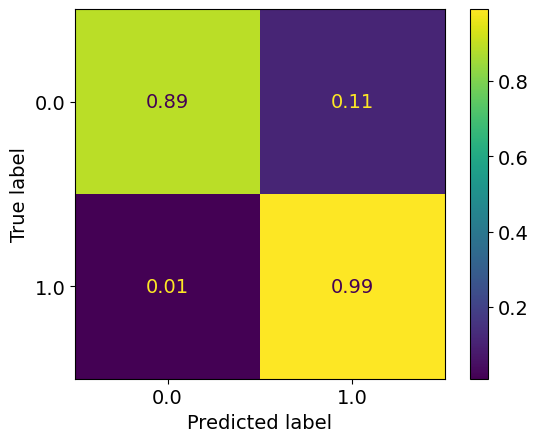

epoch: 350
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:45<00:00,  3.78it/s]


train loss: 0.07961836175164046
train acc: 0.96680516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.77it/s]


test loss: 0.1055111385543238
test acc: 0.9620634
epoch: 351
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.33it/s]


train loss: 0.07975407056725783
train acc: 0.9668822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.48it/s]


test loss: 0.1341468324376778
test acc: 0.95601046
epoch: 352
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.16it/s]


train loss: 0.07912423769604264
train acc: 0.96693045


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.44it/s]


test loss: 0.10677839620885524
test acc: 0.9613309
epoch: 353
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.07807238376295636
train acc: 0.96711355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.10443307798017155
test acc: 0.9636441
epoch: 354
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.23it/s]


train loss: 0.07964647563465069
train acc: 0.9663232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.83it/s]


test loss: 0.11591231856833804
test acc: 0.96059835
epoch: 355
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07939216296452319
train acc: 0.96690154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.35it/s]


test loss: 0.12551635622300886
test acc: 0.95870924
epoch: 356
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.07938566280668871
train acc: 0.96705574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.53it/s]


test loss: 0.11558136343955994
test acc: 0.9605212
epoch: 357
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.07868788860781345
train acc: 0.9674509


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.91it/s]


test loss: 0.11308951692825014
test acc: 0.9619092
epoch: 358
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.07884157789235859
train acc: 0.9669497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.10270058854737064
test acc: 0.9627959
epoch: 359
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07933789091130902
train acc: 0.9671232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.77it/s]


test loss: 0.10002051844176921
test acc: 0.961755


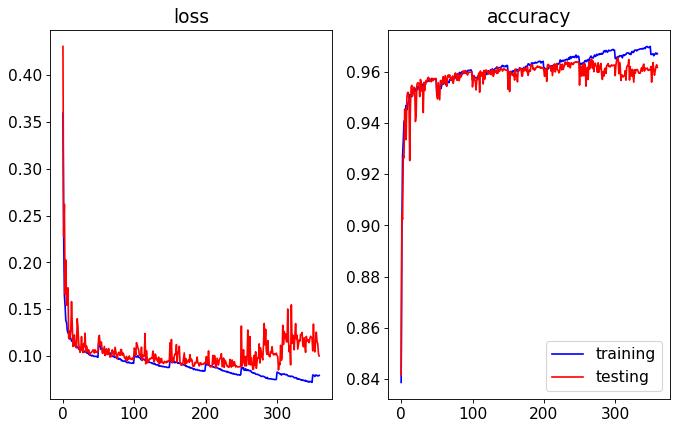

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


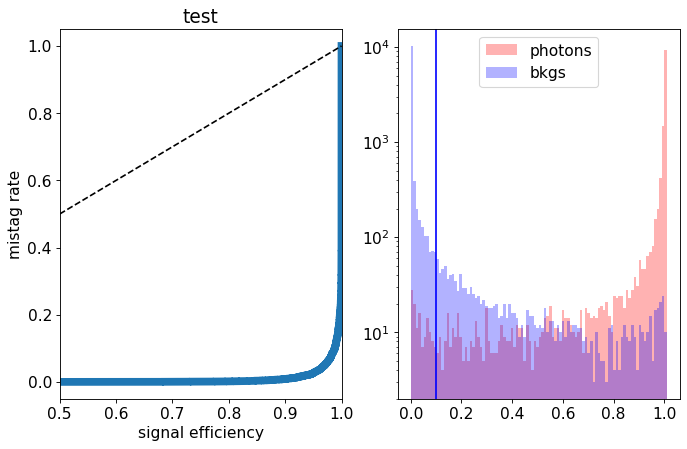

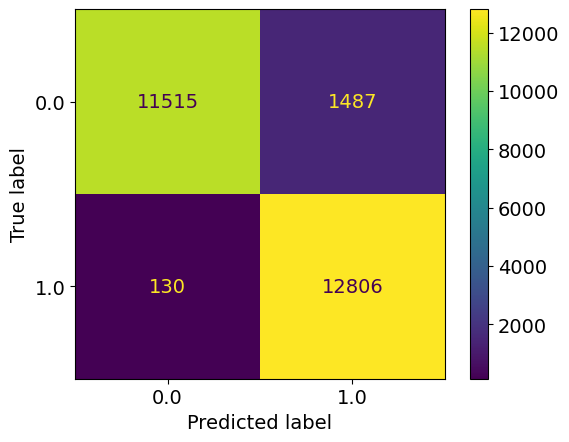

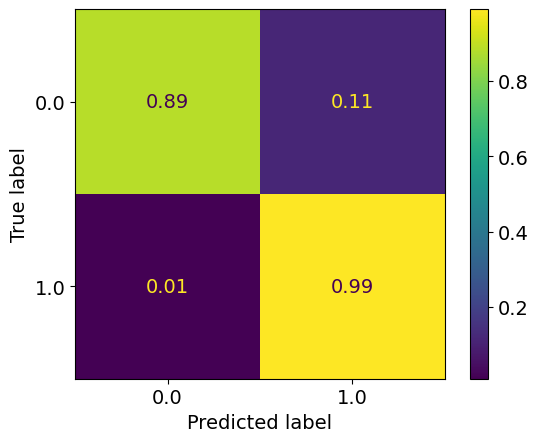

epoch: 360
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.07745050302991978
train acc: 0.9669208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.153998281637376
test acc: 0.9553936
epoch: 361
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07850448970246866
train acc: 0.9670075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.13346159305762162
test acc: 0.9584008
epoch: 362
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.07785705793541291
train acc: 0.96714246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.69it/s]


test loss: 0.14948335527019066
test acc: 0.9563575
epoch: 363
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.15it/s]


train loss: 0.07725371403156678
train acc: 0.96765333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.79it/s]


test loss: 0.11333991231566126
test acc: 0.9599815
epoch: 364
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.07729556413658092
train acc: 0.9679714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.28it/s]


test loss: 0.09944276122206991
test acc: 0.9637983
epoch: 365
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.13it/s]


train loss: 0.07686015582411965
train acc: 0.9677979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.68it/s]


test loss: 0.13379941034046086
test acc: 0.9604056
epoch: 366
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.07735428399261023
train acc: 0.96768224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.55it/s]


test loss: 0.11546307700601491
test acc: 0.9609839
epoch: 367
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.17it/s]


train loss: 0.07664236198098673
train acc: 0.9681449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.09251781392165205
test acc: 0.9638754
epoch: 368
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.07659481052373875
train acc: 0.9684437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.1226906513964588
test acc: 0.9584779
epoch: 369
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:44<00:00,  3.90it/s]


train loss: 0.07612785231860388
train acc: 0.96843404


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.63it/s]


test loss: 0.12315637804567814
test acc: 0.95859355


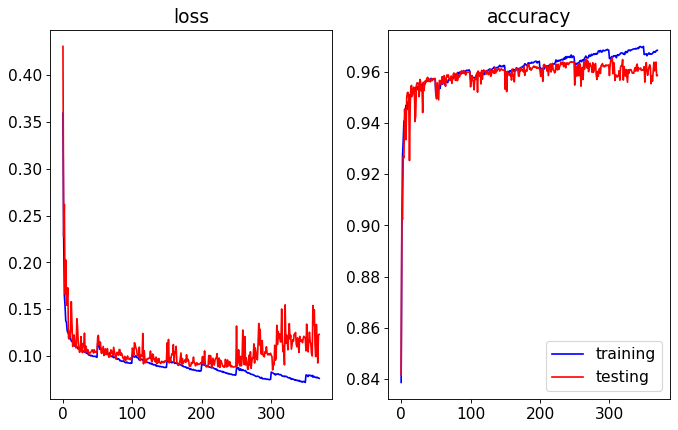

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.73it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


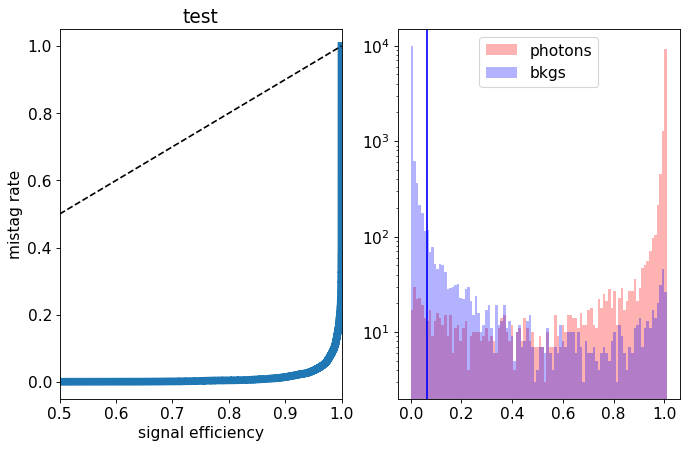

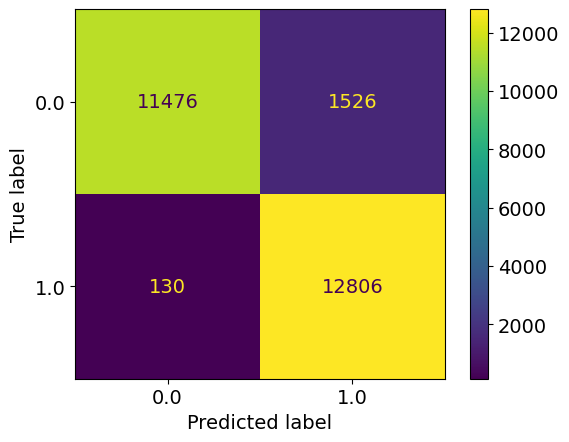

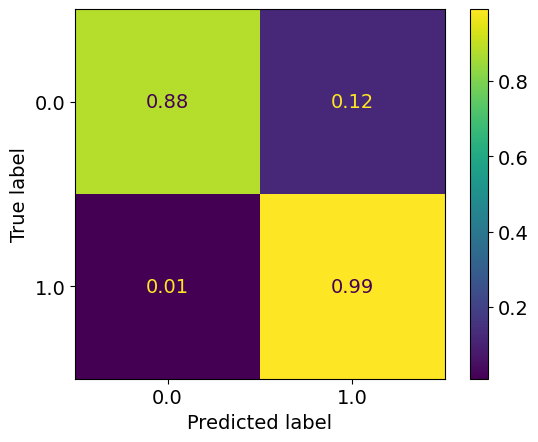

epoch: 370
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:43<00:00,  3.97it/s]


train loss: 0.07593738612842697
train acc: 0.96876174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.11687276343053038
test acc: 0.9602899
epoch: 371
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:43<00:00,  3.98it/s]


train loss: 0.075764234613821
train acc: 0.9685015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.89it/s]


test loss: 0.11695174322548238
test acc: 0.9613694
epoch: 372
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:44<00:00,  3.89it/s]


train loss: 0.07583893372574983
train acc: 0.9679714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.1023972395976836
test acc: 0.96383685
epoch: 373
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.07561091824590815
train acc: 0.96830875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.60it/s]


test loss: 0.11543610988354142
test acc: 0.9609839
epoch: 374
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:47<00:00,  3.65it/s]


train loss: 0.07510650939593426
train acc: 0.96888703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.15135209016840567
test acc: 0.9578225
epoch: 375
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07503679239681002
train acc: 0.968781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.11507007259536874
test acc: 0.96059835
epoch: 376
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:44<00:00,  3.89it/s]


train loss: 0.07387850386214394
train acc: 0.9689738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.78it/s]


test loss: 0.10101642188700763
test acc: 0.9639525
epoch: 377
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:43<00:00,  3.98it/s]


train loss: 0.07370574358915317
train acc: 0.9688678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.14690602367574518
test acc: 0.95789963
epoch: 378
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07327265740302256
train acc: 0.96921474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.12869169088927182
test acc: 0.9605212
epoch: 379
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07355210393925622
train acc: 0.9693786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.1020150523294102
test acc: 0.96333563


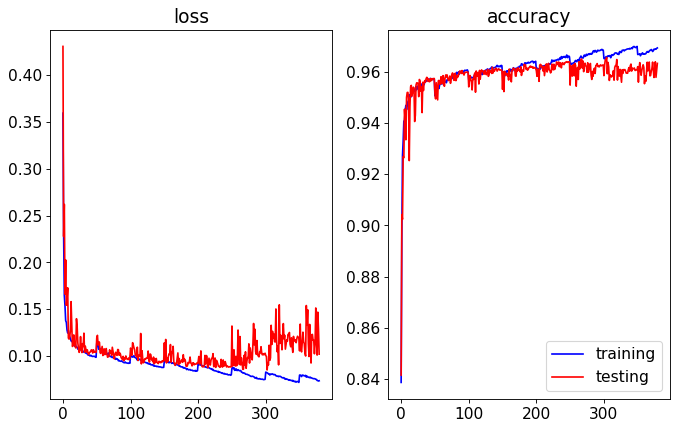

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.58it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


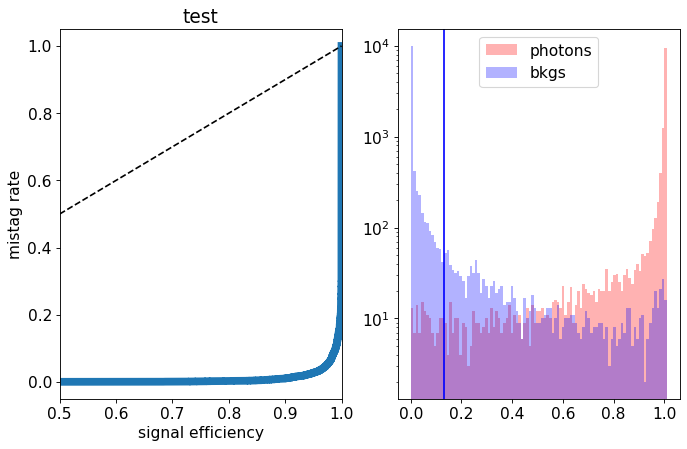

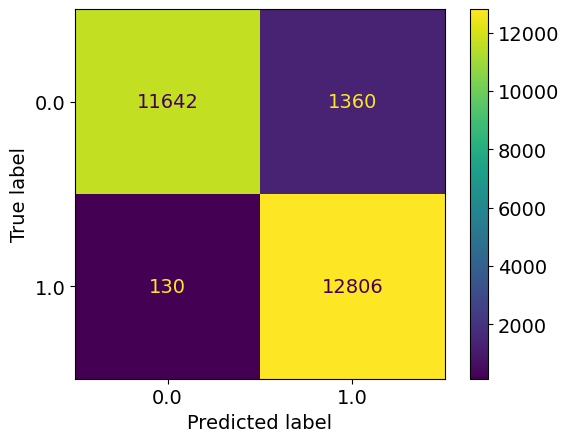

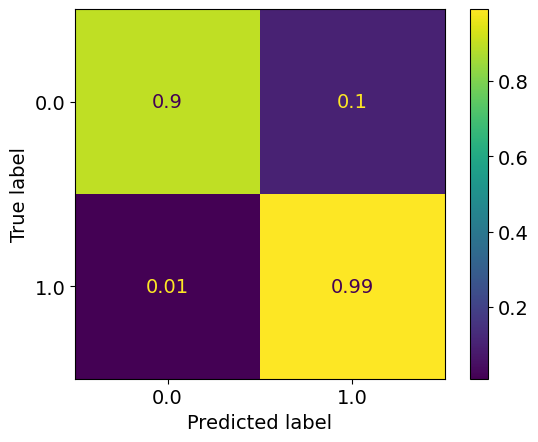

epoch: 380
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.0731247033859264
train acc: 0.969369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.130265099927783
test acc: 0.96017426
epoch: 381
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.07268106407685086
train acc: 0.96998584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.10496848372911866
test acc: 0.96441513
epoch: 382
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.0728672277936012
train acc: 0.96921474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.12637557478790934
test acc: 0.9614465
epoch: 383
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.07263444256403542
train acc: 0.96951354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.05it/s]


test loss: 0.13642976365306161
test acc: 0.9605212
epoch: 384
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07228885435989138
train acc: 0.96983165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.09479148592799902
test acc: 0.965032
epoch: 385
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.07191288772690503
train acc: 0.97043884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.11843094703826038
test acc: 0.9624104
epoch: 386
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07247275981858287
train acc: 0.96977377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.13772754007103769
test acc: 0.96059835
epoch: 387
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07119860919999939
train acc: 0.970381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.11949086849662391
test acc: 0.9625646
epoch: 388
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.07195881883360747
train acc: 0.9697545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.84it/s]


test loss: 0.15260813402181322
test acc: 0.9597502
epoch: 389
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07157032023792322
train acc: 0.9699376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.1513043101876974
test acc: 0.95978874


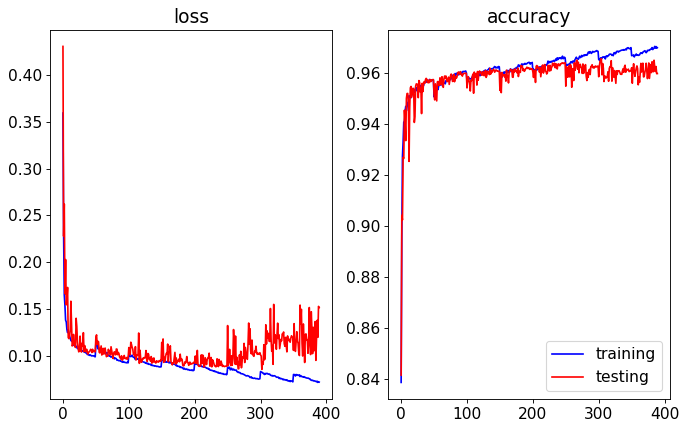

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.74it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


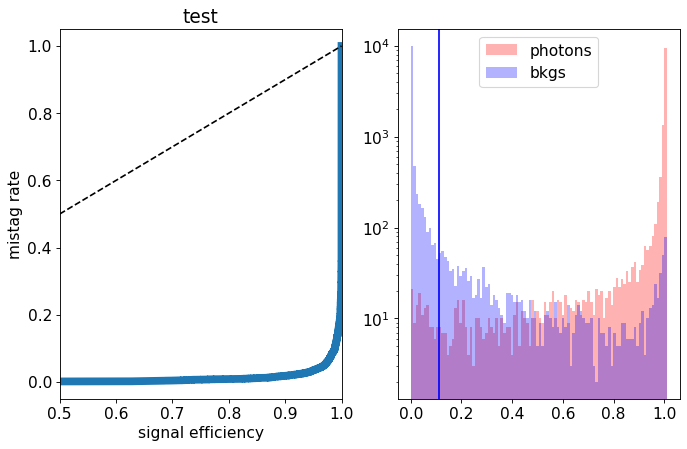

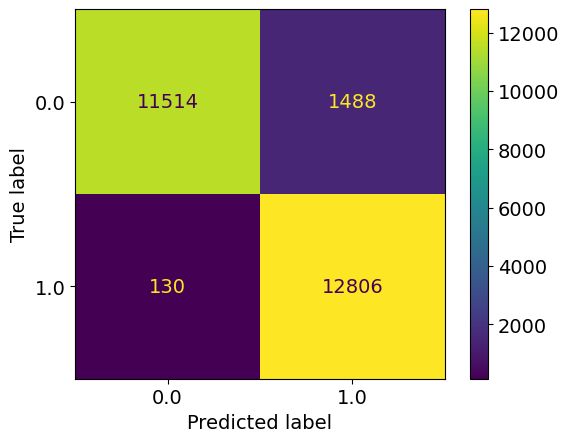

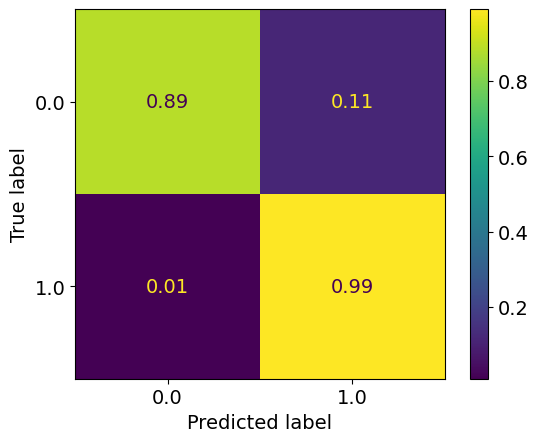

epoch: 390
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07069767895289239
train acc: 0.9703521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.52it/s]


test loss: 0.13826067864217542
test acc: 0.96117663
epoch: 391
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07112375741576873
train acc: 0.97058344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.12355191599239003
test acc: 0.96302724
epoch: 392
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07092578999827363
train acc: 0.9703328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.57it/s]


test loss: 0.12064385109327057
test acc: 0.9631429
epoch: 393
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.07083503189200611
train acc: 0.97062194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.14393543181094257
test acc: 0.960714
epoch: 394
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07051582970371136
train acc: 0.9702653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.146015475588766
test acc: 0.9609453
epoch: 395
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.06979548595199696
train acc: 0.97094965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.78it/s]


test loss: 0.13865161390805786
test acc: 0.96125376
epoch: 396
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.24it/s]


train loss: 0.07089528415588975
train acc: 0.9705063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.13909403251653368
test acc: 0.9614851
epoch: 397
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.07059654914316414
train acc: 0.97037137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.14278667623346503
test acc: 0.9613309
epoch: 398
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.0703455712969248
train acc: 0.9705352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.1449084085496989
test acc: 0.96125376
epoch: 399
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07082981043468321
train acc: 0.96995693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.14156228964301673
test acc: 0.96125376


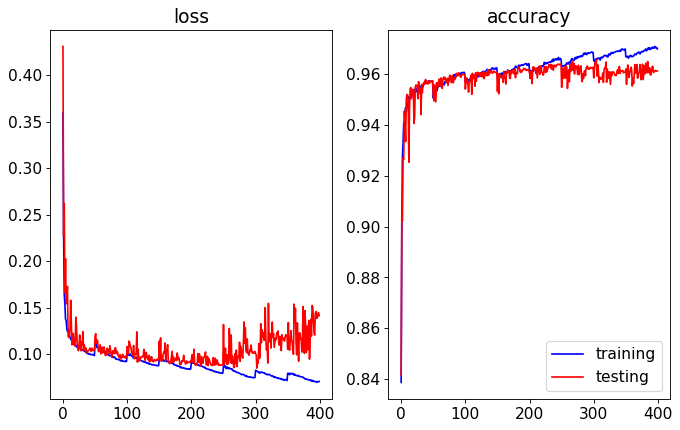

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


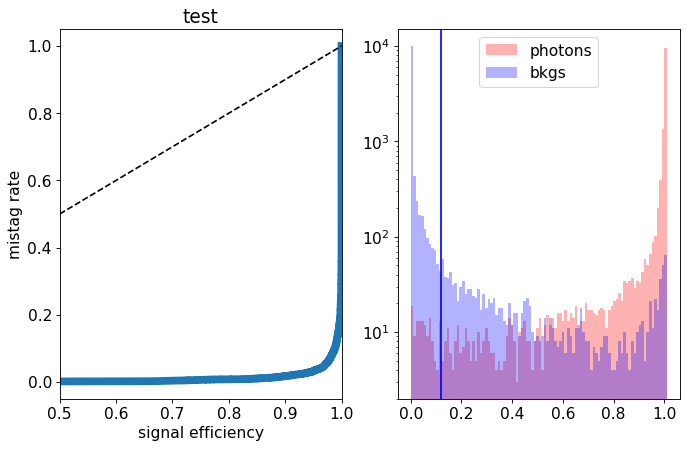

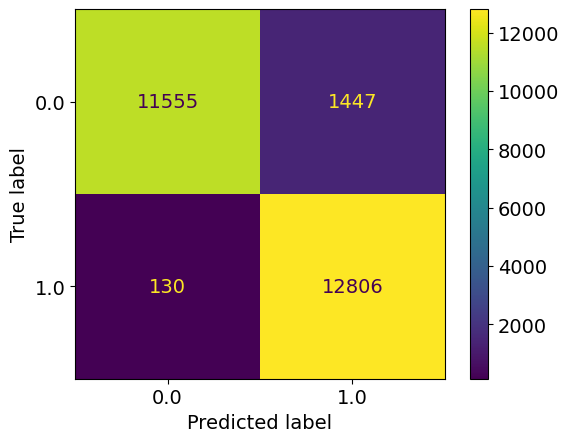

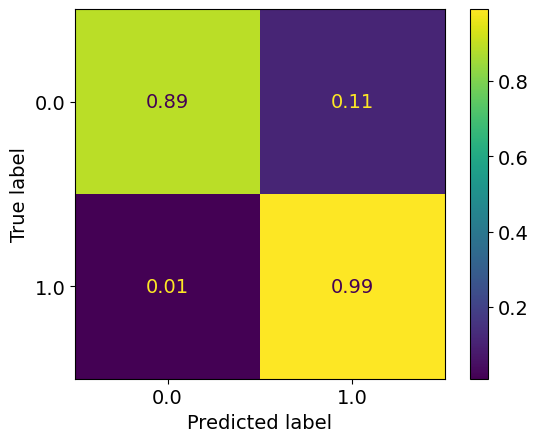

epoch: 400
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.07785255985194547
train acc: 0.96749914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.10651172629811546
test acc: 0.9599044
epoch: 401
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.40it/s]


train loss: 0.07823498504010239
train acc: 0.96752805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.72it/s]


test loss: 0.13892514817416668
test acc: 0.95454544
epoch: 402
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07719460609934234
train acc: 0.9679907


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.10827229942449114
test acc: 0.9619092
epoch: 403
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.0774845268383536
train acc: 0.9675955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.69it/s]


test loss: 0.09878416706553915
test acc: 0.9629887
epoch: 404
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07741349046199308
train acc: 0.9672774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.10005076568235051
test acc: 0.9620248
epoch: 405
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07711985143106108
train acc: 0.96789426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.81it/s]


test loss: 0.12357091463424942
test acc: 0.9589791
epoch: 406
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.07616280682514169
train acc: 0.9680967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.70it/s]


test loss: 0.09996246495707468
test acc: 0.962526
epoch: 407
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.0766822952626413
train acc: 0.9679039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.11980634775351394
test acc: 0.96140796
epoch: 408
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07628247929963074
train acc: 0.96846294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.11638770895925435
test acc: 0.96248746
epoch: 409
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07647916691840728
train acc: 0.9679617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.11221538501029665
test acc: 0.9637983


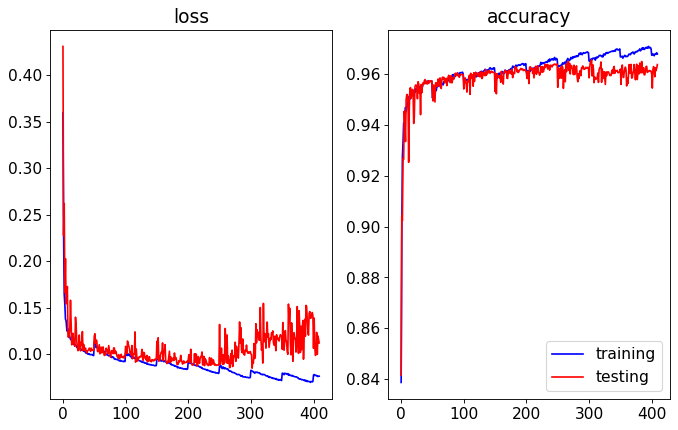

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


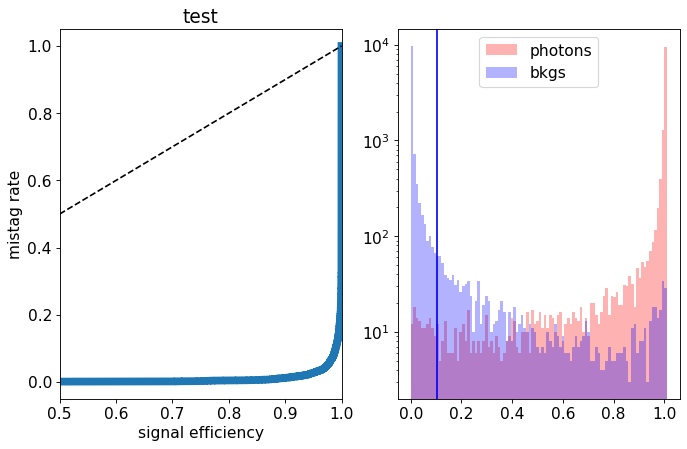

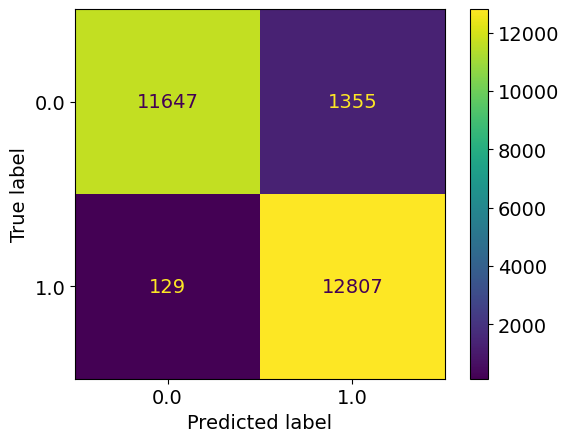

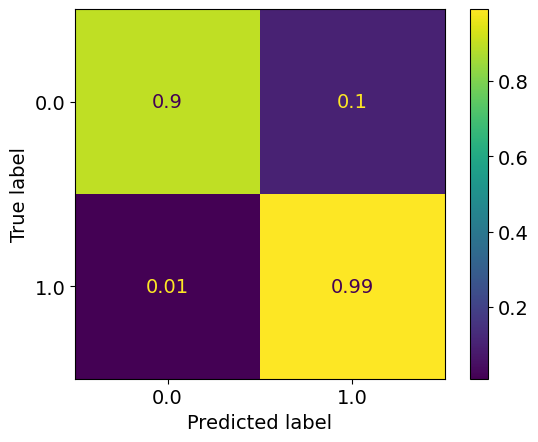

epoch: 410
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07674648100241072
train acc: 0.9677497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.11879506410861557
test acc: 0.95951885
epoch: 411
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.0756403567818548
train acc: 0.9681738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.09379243520511822
test acc: 0.96410674
epoch: 412
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.07518717103955373
train acc: 0.9686461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.05it/s]


test loss: 0.1920048463242975
test acc: 0.9533503
epoch: 413
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.07579143767411999
train acc: 0.968222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.12037556406787851
test acc: 0.96210194
epoch: 414
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07422552671218884
train acc: 0.9689834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.11989531835371797
test acc: 0.9612923
epoch: 415
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.0756311162100362
train acc: 0.96861714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.14242959962311116
test acc: 0.95813096
epoch: 416
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.0743412538889171
train acc: 0.9691762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.77it/s]


test loss: 0.11926894558762963
test acc: 0.95967305
epoch: 417
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.07511401512374767
train acc: 0.9689738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.85it/s]


test loss: 0.13360613432120194
test acc: 0.95813096
epoch: 418
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.38it/s]


train loss: 0.07480499378776964
train acc: 0.9692533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.67it/s]


test loss: 0.1146585958247835
test acc: 0.96210194
epoch: 419
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07368244786310747
train acc: 0.96893525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.13499323083934459
test acc: 0.960367


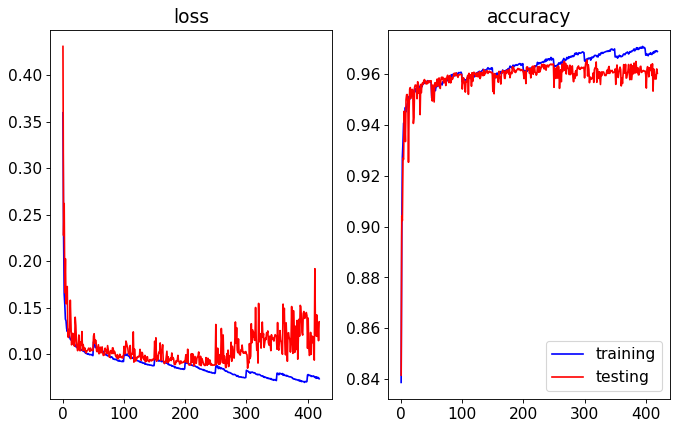

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


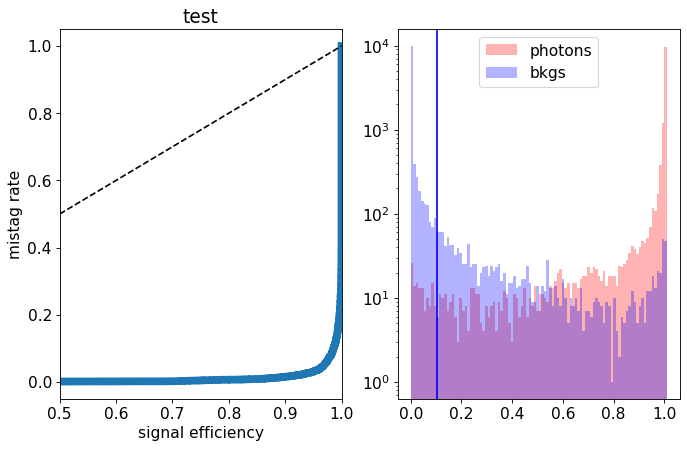

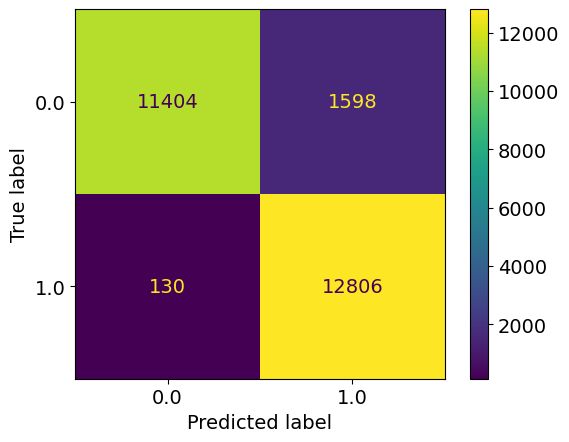

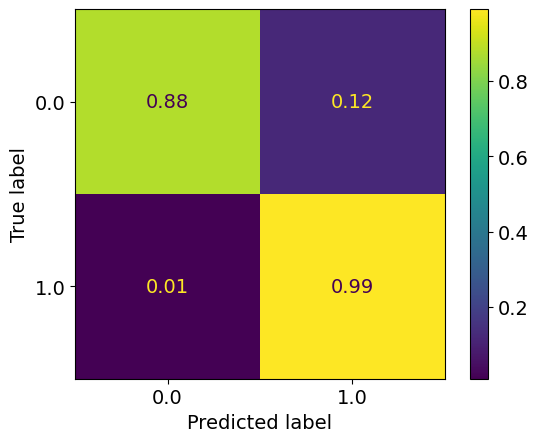

epoch: 420
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07359931157158979
train acc: 0.9695521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.1315711433575912
test acc: 0.96109957
epoch: 421
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07355453136425487
train acc: 0.96951354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.73it/s]


test loss: 0.12394784306260673
test acc: 0.96002007
epoch: 422
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.19it/s]


train loss: 0.07312186493005367
train acc: 0.9696485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.48it/s]


test loss: 0.12800449183718723
test acc: 0.95628035
epoch: 423
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.35it/s]


train loss: 0.07294414745848303
train acc: 0.9695521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.52it/s]


test loss: 0.13583379018713126
test acc: 0.9591333
epoch: 424
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.21it/s]


train loss: 0.07262814716796655
train acc: 0.96957135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.56it/s]


test loss: 0.10884260521693663
test acc: 0.96372116
epoch: 425
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.07220080787735868
train acc: 0.97014004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.09918619827790694
test acc: 0.9648778
epoch: 426
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07224746194878065
train acc: 0.9697256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.124370680952614
test acc: 0.9616007
epoch: 427
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07207085293410831
train acc: 0.9699184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.10952665225010026
test acc: 0.9615622
epoch: 428
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.07133252679698729
train acc: 0.9706316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.05it/s]


test loss: 0.17191571166569536
test acc: 0.9571671
epoch: 429
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.07137036274020382
train acc: 0.9703232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.81it/s]


test loss: 0.15911190516569398
test acc: 0.95963454


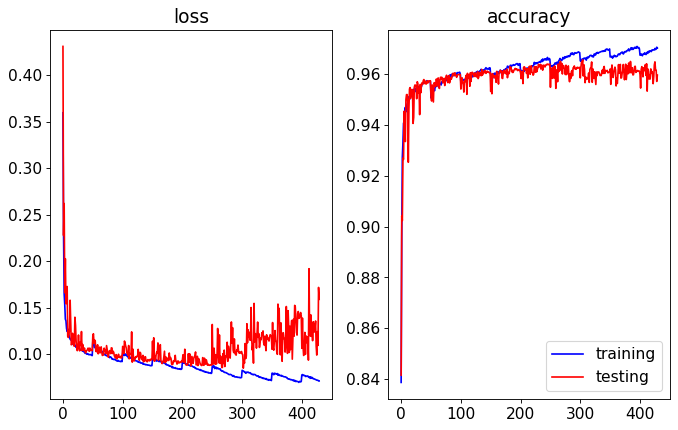

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


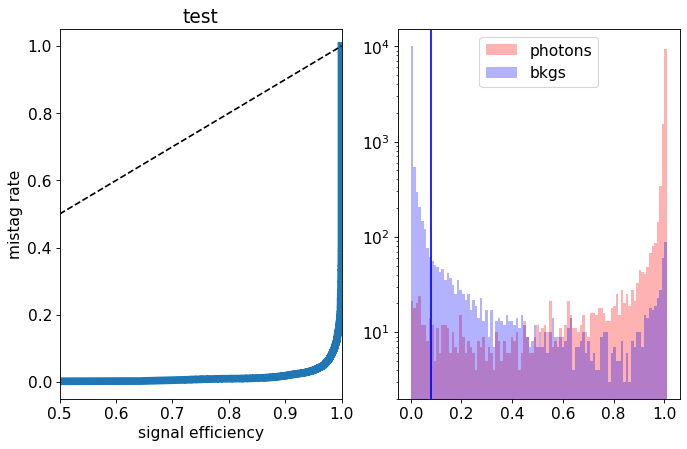

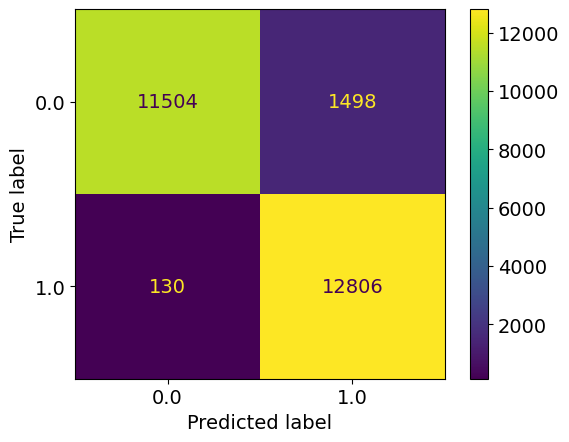

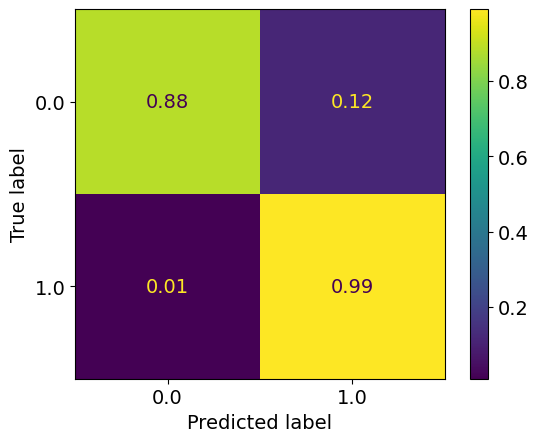

epoch: 430
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.07077019125481561
train acc: 0.97052556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.16088203306902538
test acc: 0.95859355
epoch: 431
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.0702613221987479
train acc: 0.9706798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.86it/s]


test loss: 0.1724693588912487
test acc: 0.9577454
epoch: 432
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07002487950931395
train acc: 0.9708629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.12584060498259284
test acc: 0.9615622
epoch: 433
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.07007705734644322
train acc: 0.9702461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.12855074199085886
test acc: 0.9613309
epoch: 434
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.06992884398023518
train acc: 0.9714027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.05it/s]


test loss: 0.11719110743565993
test acc: 0.9620248
epoch: 435
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.06926704714925302
train acc: 0.9709786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.53it/s]


test loss: 0.12774471142752605
test acc: 0.96167785
epoch: 436
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.06938076180788134
train acc: 0.9712292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.93it/s]


test loss: 0.1370893299410289
test acc: 0.96102244
epoch: 437
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.06912302064327146
train acc: 0.9711425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.14593127522278915
test acc: 0.9602899
epoch: 438
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.06865462757690105
train acc: 0.97136414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.14277909238907424
test acc: 0.96002007
epoch: 439
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.06876634685807145
train acc: 0.9713159


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.05it/s]


test loss: 0.15528716333210468
test acc: 0.9600586


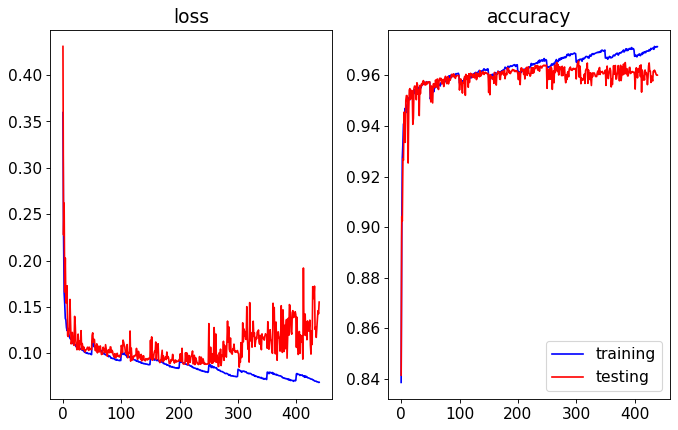

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


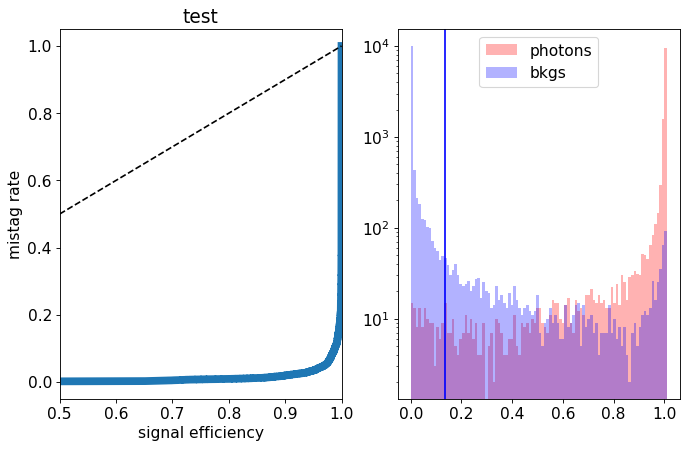

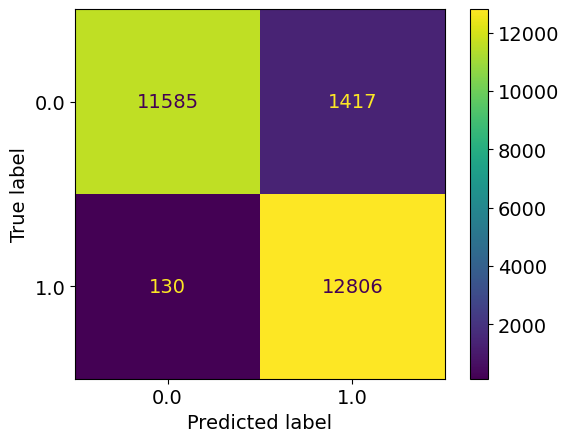

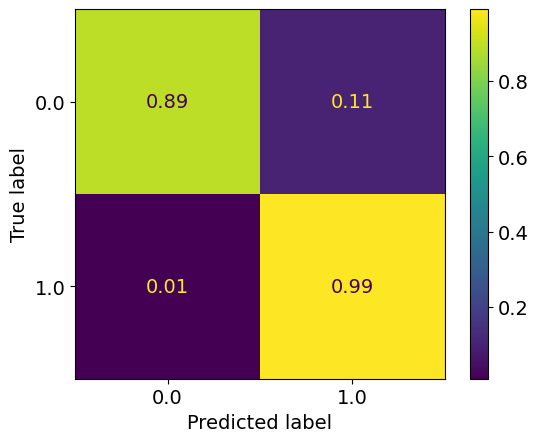

epoch: 440
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.06847504877372285
train acc: 0.9714798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.15524639104577628
test acc: 0.96044415
epoch: 441
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.06786934499537324
train acc: 0.9716051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s]


test loss: 0.14697886715558442
test acc: 0.96032846
epoch: 442
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.06764812698598542
train acc: 0.9717882


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.16325073418292133
test acc: 0.9594417
epoch: 443
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.06873268489806639
train acc: 0.97126776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.99it/s]


test loss: 0.15062456781213934
test acc: 0.9601357
epoch: 444
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.06856429587640514
train acc: 0.9714123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.14620237932963806
test acc: 0.9609068
epoch: 445
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.39it/s]


train loss: 0.06852562749230792
train acc: 0.9713834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.1437874719161879
test acc: 0.96075255
epoch: 446
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.06774267209747623
train acc: 0.9714894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.14103937132114713
test acc: 0.96113807
epoch: 447
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.06722830492206391
train acc: 0.971769


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.14075498181310567
test acc: 0.96125376
epoch: 448
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.06758401346947417
train acc: 0.97166294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.13839651508764786
test acc: 0.96113807
epoch: 449
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.06760389937055593
train acc: 0.9714991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.13943689824505287
test acc: 0.96113807


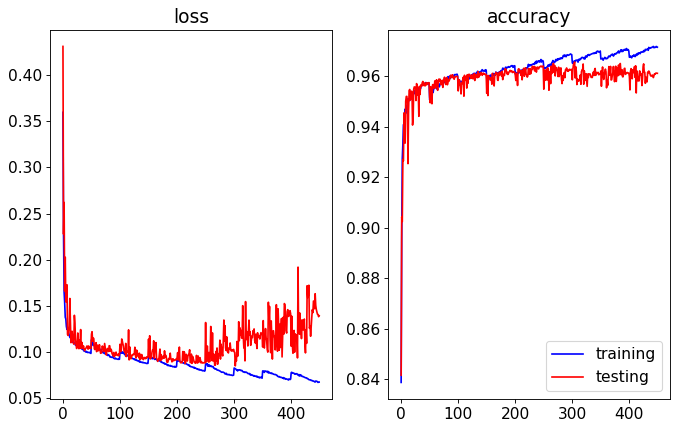

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


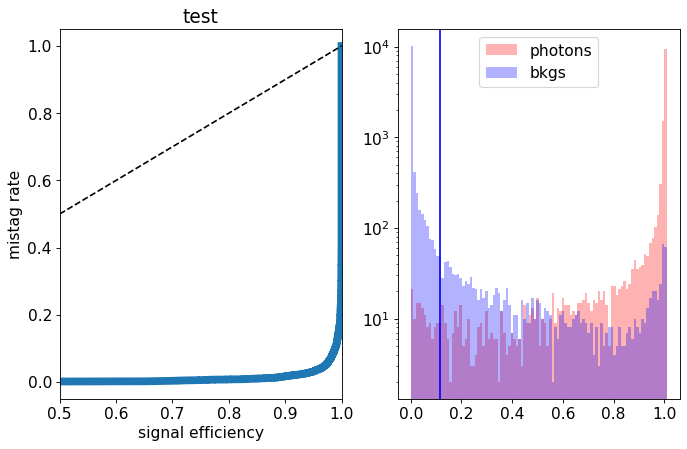

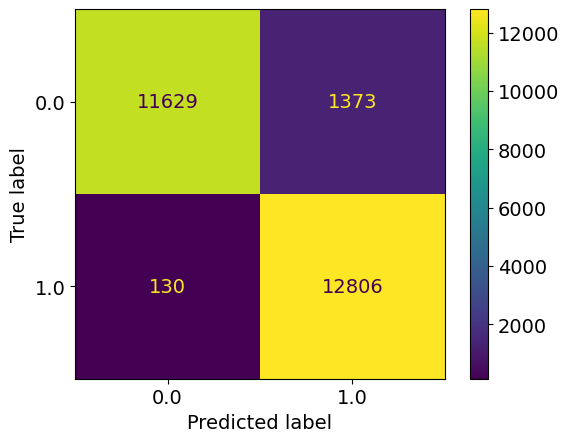

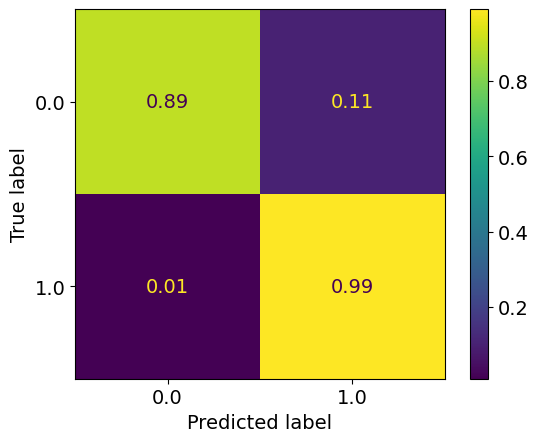

epoch: 450
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07571704629700997
train acc: 0.9686557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.21268905665386806
test acc: 0.95454544
epoch: 451
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07589615773775674
train acc: 0.96848226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.69it/s]


test loss: 0.1533871509812095
test acc: 0.9568972
epoch: 452
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.07494759103121786
train acc: 0.9688967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.11615235934203322
test acc: 0.9612923
epoch: 453
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.07638509149496266
train acc: 0.9677979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.49it/s]


test loss: 0.10096975593742999
test acc: 0.9631429
epoch: 454
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07428684018853772
train acc: 0.9692726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.09785589508034966
test acc: 0.96410674
epoch: 455
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.07477951807782829
train acc: 0.96863645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.14466434581713242
test acc: 0.96125376
epoch: 456
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.44it/s]


train loss: 0.07483827070779883
train acc: 0.96893525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]


test loss: 0.17035954699597575
test acc: 0.95643455
epoch: 457
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07457649369718712
train acc: 0.9688292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.51it/s]


test loss: 0.11942870466207917
test acc: 0.9604827
epoch: 458
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.37it/s]


train loss: 0.07593074809178452
train acc: 0.9686846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.09403151366859674
test acc: 0.96372116
epoch: 459
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.24it/s]


train loss: 0.07377907340926242
train acc: 0.9693497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.1541794938119975
test acc: 0.95786107


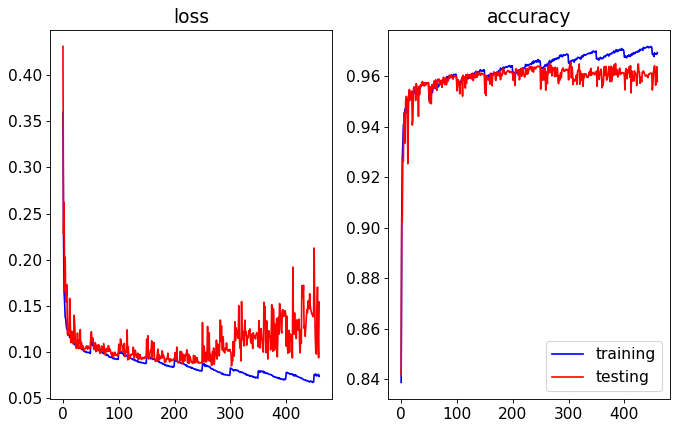

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.00it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


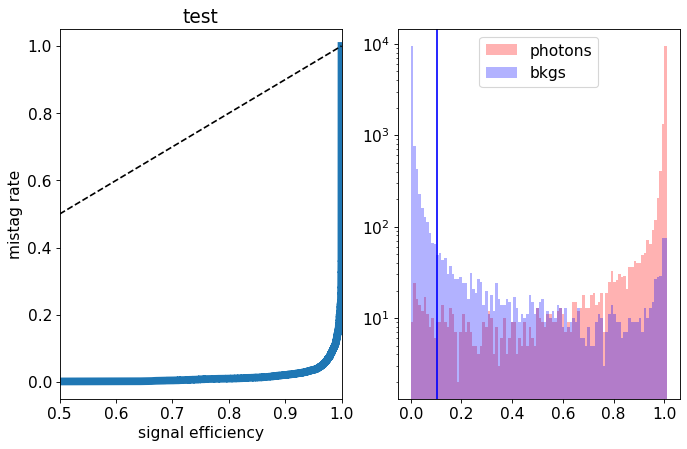

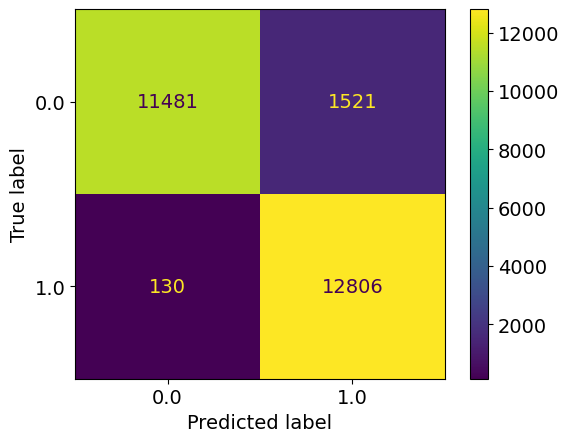

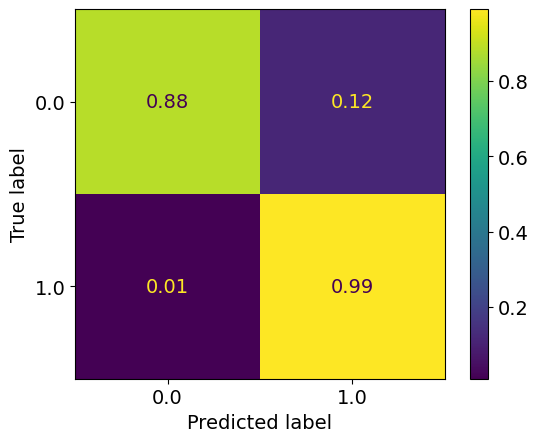

epoch: 460
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.0738083017139421
train acc: 0.9692726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.90it/s]


test loss: 0.11997150646691973
test acc: 0.9600586
epoch: 461
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.17it/s]


train loss: 0.07336769627697895
train acc: 0.96953285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.72it/s]


test loss: 0.15609371645206754
test acc: 0.95843935
epoch: 462
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.36it/s]


train loss: 0.07330563584762502
train acc: 0.9695232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.55it/s]


test loss: 0.12039384415203874
test acc: 0.9620634
epoch: 463
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.21it/s]


train loss: 0.07267013226630371
train acc: 0.9696967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.12700210545550694
test acc: 0.9621405
epoch: 464
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07264521420863322
train acc: 0.9694557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.53it/s]


test loss: 0.12796751418235627
test acc: 0.9602514
epoch: 465
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07351332175077041
train acc: 0.96920514


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.11732812242751772
test acc: 0.9614851
epoch: 466
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07197584521908292
train acc: 0.9703328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.76it/s]


test loss: 0.12930535220287062
test acc: 0.9598273
epoch: 467
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.07238031516788322
train acc: 0.9702364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.14559419402344662
test acc: 0.9601357
epoch: 468
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.07223521866378067
train acc: 0.9696003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.16222110018134117
test acc: 0.95778394
epoch: 469
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.07126200511362511
train acc: 0.97073764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.13323898943649096
test acc: 0.9600586


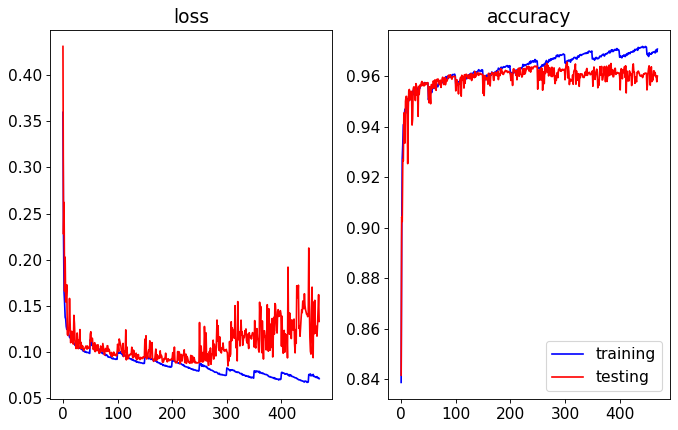

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


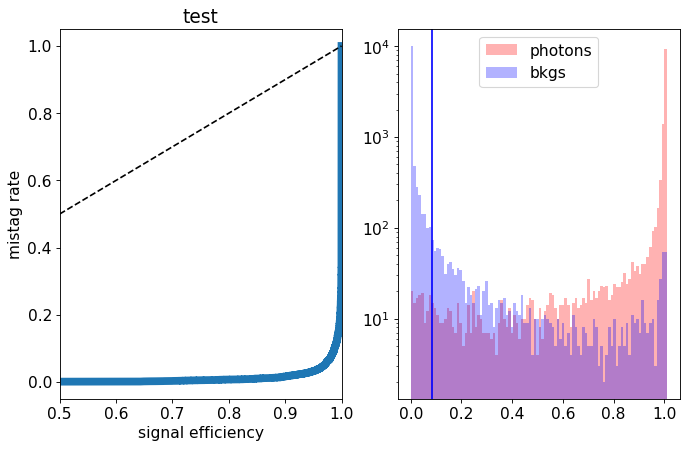

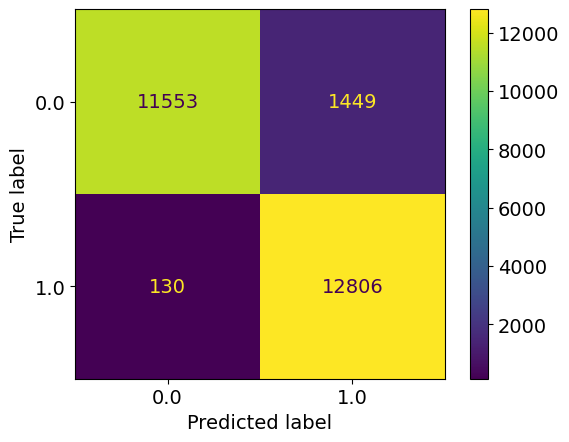

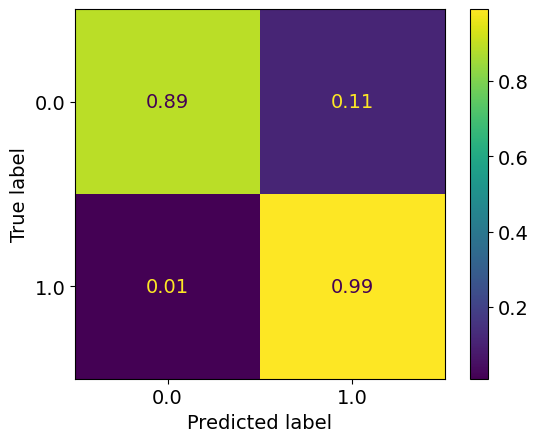

epoch: 470
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.26it/s]


train loss: 0.07115048564152221
train acc: 0.970381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.15915130417455325
test acc: 0.9589791
epoch: 471
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.41it/s]


train loss: 0.07210160415038208
train acc: 0.9702461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.88it/s]


test loss: 0.16928542591631413
test acc: 0.95547074
epoch: 472
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.07010530486616785
train acc: 0.9711039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.17720781503753227
test acc: 0.95793813
epoch: 473
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.07059763214750096
train acc: 0.9705063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.50it/s]


test loss: 0.14939736439423126
test acc: 0.9605598
epoch: 474
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.07026527326747861
train acc: 0.97061235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.06it/s]


test loss: 0.12843294255435467
test acc: 0.9609453
epoch: 475
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.06988330872331051
train acc: 0.9703328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.65it/s]


test loss: 0.21390737186778674
test acc: 0.95574063
epoch: 476
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.06941148556898095
train acc: 0.97129667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.13726696405898442
test acc: 0.9616007
epoch: 477
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.0685467523215823
train acc: 0.97127736


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.09it/s]


test loss: 0.15702749577096917
test acc: 0.96044415
epoch: 478
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.06824609124763853
train acc: 0.9713834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.87it/s]


test loss: 0.16584187932312489
test acc: 0.9594803
epoch: 479
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.06821797338093637
train acc: 0.9718075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.91it/s]


test loss: 0.1799588609825481
test acc: 0.95886344


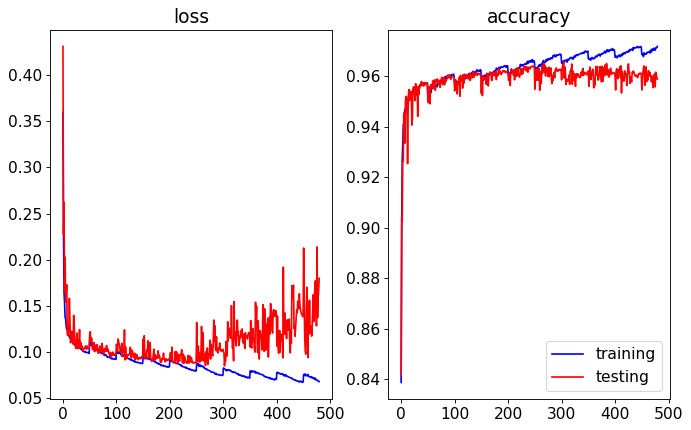

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


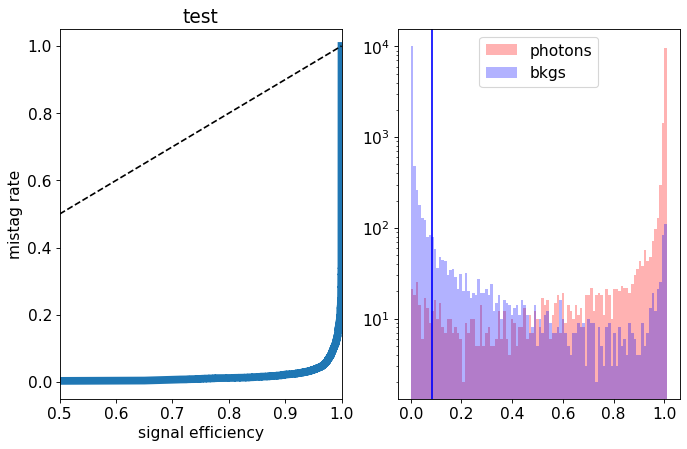

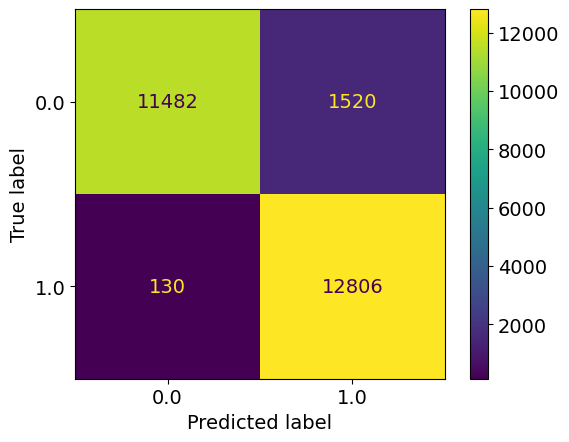

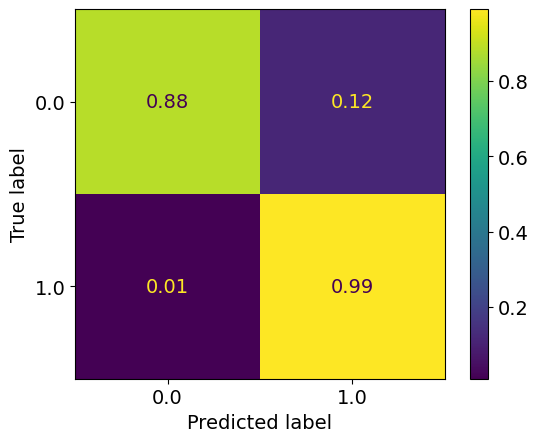

epoch: 480
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.06765978074917904
train acc: 0.97217375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.15883599797433073
test acc: 0.95901763
epoch: 481
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.28it/s]


train loss: 0.0676946503492449
train acc: 0.9721641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.15919232639399442
test acc: 0.95967305
epoch: 482
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.0673024491595395
train acc: 0.97223157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.14448295973918654
test acc: 0.95936465
epoch: 483
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.06675735014797635
train acc: 0.971981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.92it/s]


test loss: 0.13333179149776697
test acc: 0.9607911
epoch: 484
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.06671521519822192
train acc: 0.97223157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.15668439560315825
test acc: 0.9590562
epoch: 485
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.06619883018594257
train acc: 0.9729063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.96it/s]


test loss: 0.13302757997404446
test acc: 0.9598658
epoch: 486
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.06544602875506257
train acc: 0.9725111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.1493192616511475
test acc: 0.95909476
epoch: 487
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.0662121131284044
train acc: 0.9726942


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.16182836416092786
test acc: 0.95886344
epoch: 488
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.43it/s]


train loss: 0.06581454980321702
train acc: 0.9725786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.16723220219666307
test acc: 0.9577454
epoch: 489
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.30it/s]


train loss: 0.06556163803604297
train acc: 0.97254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]


test loss: 0.1560866278172894
test acc: 0.9594032


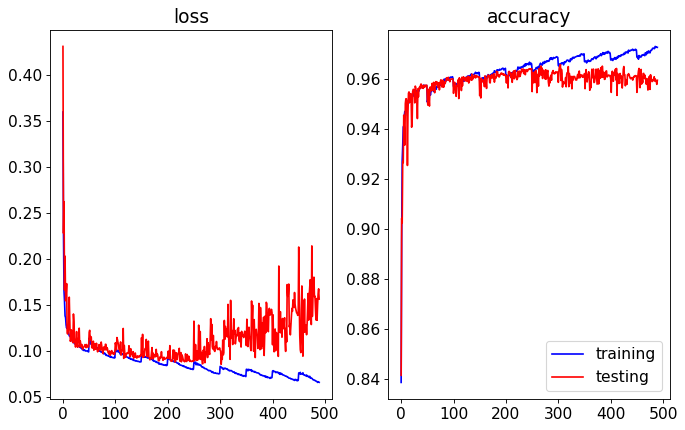

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.04it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


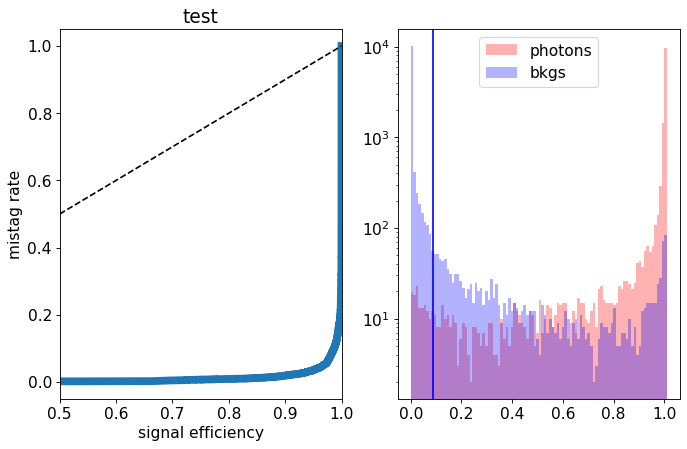

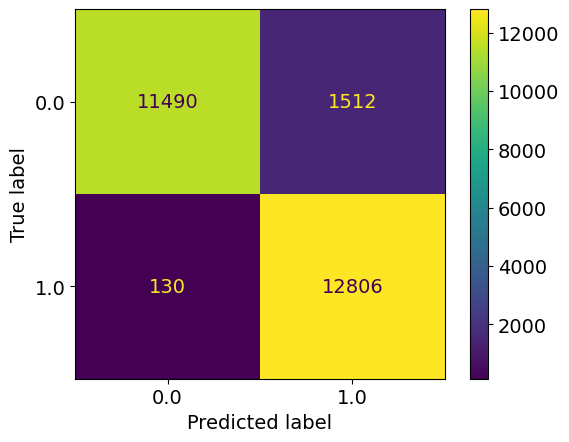

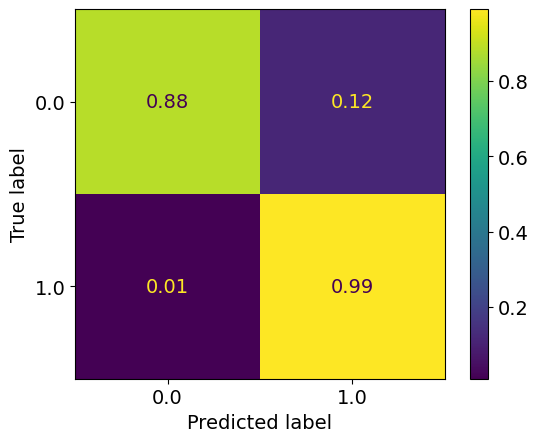

epoch: 490
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.06511658270751809
train acc: 0.97327256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.16182854314419357
test acc: 0.95855504
epoch: 491
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.39it/s]


train loss: 0.06551567434920053
train acc: 0.97277135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.66it/s]


test loss: 0.16453556868840347
test acc: 0.95870924
epoch: 492
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.06488161506077458
train acc: 0.9734364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.97it/s]


test loss: 0.14530306631191212
test acc: 0.9599815
epoch: 493
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.0651183645806216
train acc: 0.9730219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.03it/s]


test loss: 0.14524888501248576
test acc: 0.9599815
epoch: 494
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.27it/s]


train loss: 0.06413319799510729
train acc: 0.9733593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.15277377888560295
test acc: 0.9597116
epoch: 495
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.06479065494902561
train acc: 0.9732051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.89it/s]


test loss: 0.15725561400706117
test acc: 0.9593261
epoch: 496
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.25it/s]


train loss: 0.0647621192899398
train acc: 0.9726557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.01it/s]


test loss: 0.15363313647156412
test acc: 0.95963454
epoch: 497
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:38<00:00,  4.44it/s]


train loss: 0.06411790197467529
train acc: 0.97334963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.98it/s]


test loss: 0.15559777566655117
test acc: 0.959596
epoch: 498
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:40<00:00,  4.29it/s]


train loss: 0.06459779057630224
train acc: 0.9730219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.02it/s]


test loss: 0.1621530315076763
test acc: 0.95951885
epoch: 499
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:39<00:00,  4.42it/s]


train loss: 0.0640779687791546
train acc: 0.9737834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.95it/s]


test loss: 0.15539057468148795
test acc: 0.9594803


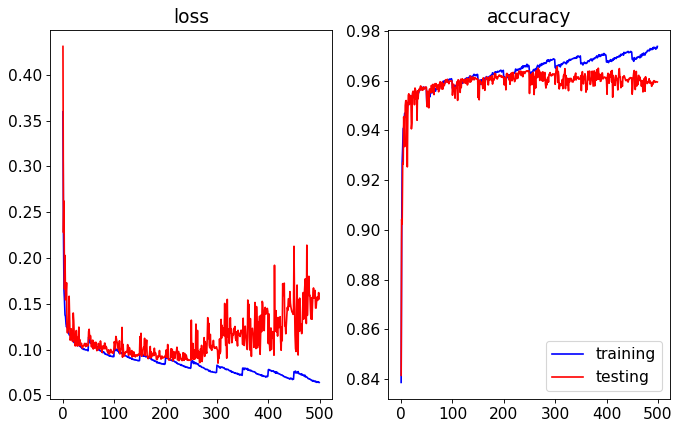

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


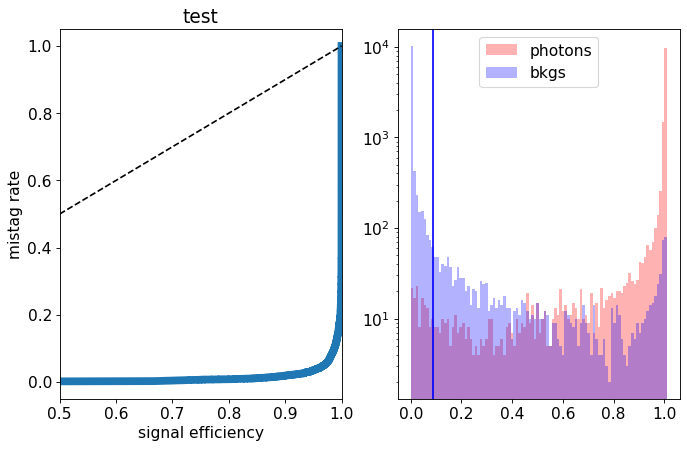

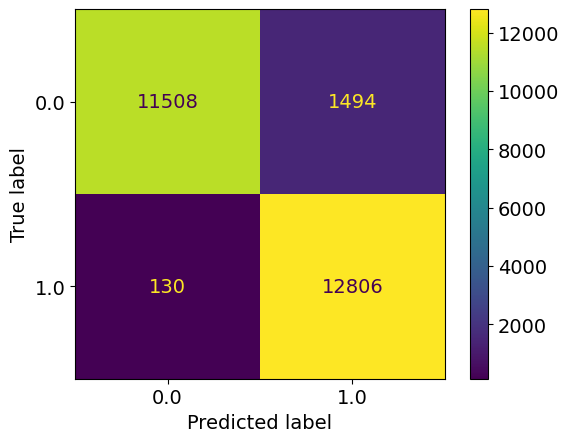

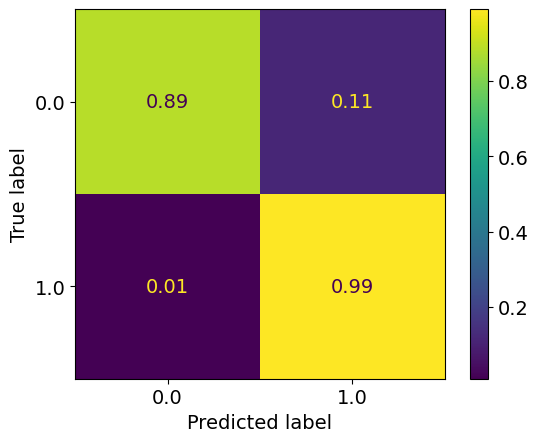

In [15]:
from tqdm import tqdm as tqdm


checkpoint_dir ="/home/llr/cms/cappati/HGC_models/PID_phopi/trainings/outdir_models_30-70_wLowptpho_dropout0p1_dimemb64_test"
os.makedirs(checkpoint_dir, exist_ok=True)


nepoch=500
best_loss = 99999999
best_acc = 0.
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    print("Learning rate:", optimizer.param_groups[0]['lr'])
    loss_t, acc_t = train(epoch)
    losst.append(loss_t)
    acct.append(acc_t)
    loss_v, acc_v = test(epoch)
    loss_epoch = loss_v
    lossv.append(loss_epoch)
    accv.append(acc_v)
    epochs.append(epoch)

    
     
    
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    
#     if loss_epoch < best_loss:
#         best_loss = loss_epoch
#         print('new best test loss:',best_loss)
#         torch.save(checkpoint,
#                    os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    
    
    if acc_v > best_acc:
        print('new best acc:',acc_v)
        best_acc = acc_v
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_bestacc.pth.tar' ))
    
    if ((epoch+1)%10 == 0):
        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        
        ax0.plot(np.array(epochs),np.array(losst),c='b',label='training')
        ax0.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        ax0.title.set_text("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.legend()
        #plt.show()
        ax1.plot(np.array(epochs),np.array(acct),c='b',label='training')
        ax1.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        ax1.title.set_text("accuracy")
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        
        
        model.eval()
        scores = []
        trues = []
        true_preds, num_preds = 0., 0.
        for data in tqdm(testloader): ### change to loaderDNN for DNN
                datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                optimizer.zero_grad()
                #label = label.to(torch.long).squeeze()
                result = model(datax, masks, info3d)
                scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
                trues.append(label.detach().cpu().numpy().flatten())
        
        
        truesa = np.hstack(trues)
        scoresa = np.hstack(scores)
        fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
        aucv = metrics.auc(fpr, tpr)

        tpr90,fpr90,threshold90 = 0,0,0
        for i,j,k in zip(tpr,fpr,thresholds):
            if i >0.99:
                tpr90 = i
                fpr90 = j
                threshold90 = k
                break

        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        plt.rcParams['font.size'] = '14'
        ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
        ax0.set_xlabel("signal efficiency")
        ax0.set_ylabel("mistag rate")
        ax0.set_xlim([0.5,1])
        ax0.plot([0.,1], [0.,1], 'k--')
        ax0.title.set_text("test")
        plt.legend()
        #ax.text(0.6,0.6,aucv,)
        #plt.yscale("log")
        
        ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
        ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
        ax1.axvline(threshold90,c="b")
        plt.yscale("log")
        plt.legend()
        plt.show()

        
        
        
        
        
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
        plt.show()
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
        plt.show()
        

In [16]:
#print(epoch_size)

In [17]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
scores = []
trues = []
true_preds, num_preds = 0., 0.
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        optimizer.zero_grad()
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
        trues.append(label.detach().cpu().numpy().flatten())
        #break

  2%|██▋                                                                                                                 | 1/44 [00:00<00:14,  2.90it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.16it/s]


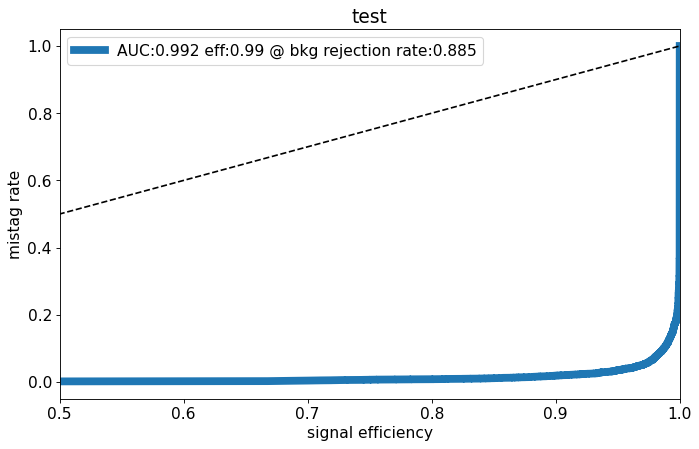

In [18]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.hstack(trues), np.hstack(scores), pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.99:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break

fig, ax = plt.subplots(figsize=(10, 6),dpi=80)
plt.rcParams['font.size'] = '14'
ax.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax.set_xlabel("signal efficiency")
ax.set_ylabel("mistag rate")
ax.set_xlim([0.5,1])
ax.plot([0.,1], [0.,1], 'k--')
ax.title.set_text("test")
#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
plt.legend()
plt.show()

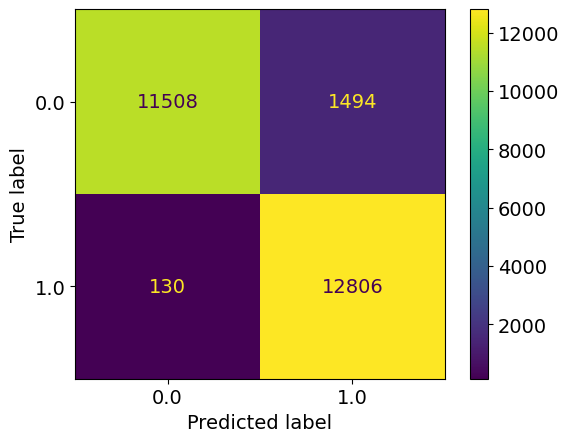

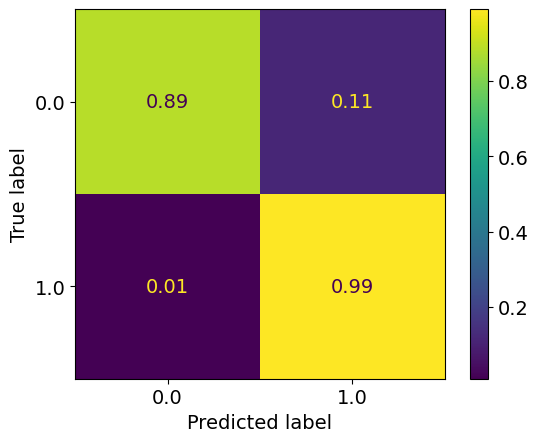

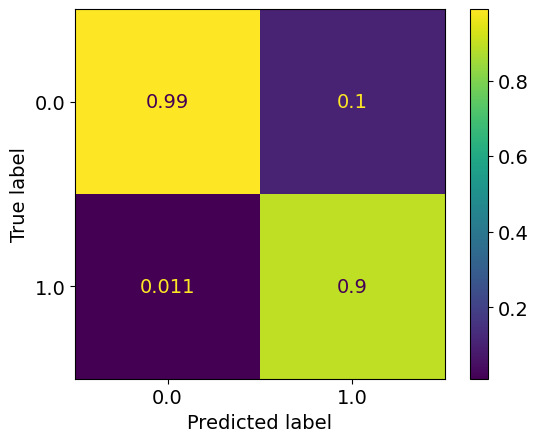

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix(np.hstack(trues), np.where(np.hstack(scores)>0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="pred")
plt.show()